# Testing

Contines Coverage Path Planning tests for a single robot, not DARP.

**Important Metrics**
- Redundancy ($R$): percentage of points that are in excess of the visited points $V$, $L_{cpath}$ is the length of the coverage path. $R = \frac{L_{cpath}}{V} - 1$
- Coverage ($C$): percentage of points covered of the total that can be covered, $P_{nobs}$ are the number of points on the map that aren't obstacles. $C = \frac{V}{P_{nobs}}$
    

In [8]:
# Global Import
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path

# Local imports
from cpp_algorithms import wavefront

from cpp_algorithms.testers import single_robot_multiple, single_robot_single
from cpp_algorithms.testers import imshow, get_random_coords, is_valid, is_bounded, get_area_map, get_all_area_maps
from cpp_algorithms.testers import imshow, generate_no_obs_area_map, generate_point_obstacles

from cpp_algorithms.coverage_path import has_isolated_areas
from cpp_algorithms.fuel_path.constants import OB, NO
from cpp_algorithms.fuel_path.fuel_path import splice_paths, get_fuel_paths
from cpp_algorithms.fuel_path.dist_matrix import dist_fill

## Run Tests

In [17]:
# Required for animations.
# Don't forget to close the figure.
%matplotlib notebook 
area_maps = get_all_area_maps("./test_maps/")
point_maps = [generate_point_obstacles(am,p=0.05) for am in generate_no_obs_area_map()]

In [20]:
point_maps = [generate_point_obstacles(am,p=0.05) for am in generate_no_obs_area_map()]
for p in point_maps:
    print(f"{p.shape} : {has_isolated_areas(p)}",end =" ")

(32, 32) : False (50, 50) : False (50, 144) : False (144, 255) : False (256, 256) : False 

### Wavefront Algorithm

#### Without fuel paths.

In [4]:
"""
Using prepainted area_maps
"""
%time wavefront_non_fuel_test_am = single_robot_multiple(wavefront, area_maps, no_end=True, fuel_paths=False)
"""cp_compute_time is in miliseconds"""
wavefront_non_fuel_test_am


CPU times: user 25.3 s, sys: 142 ms, total: 25.4 s
Wall time: 25.9 s


cp_compute_time  success  points_to_visit  obstacle_points  \
0          0.103377     True              716              308   
1          0.044060     True              689              335   
2          0.039281     True              639              385   
3          0.048845     True              654              370   
4          0.057563     True              794              230   
5          0.061015     True              725              299   
6          0.058403     True              723              301   
7          0.143846     True              610              414   
8          0.064156     True              772              252   
9          0.097987     True             1529              971   
10         0.128520     True             1318             1182   
11         0.079483     True             1472             1028   
12         0.754606     True             6042             1158   
13         0.582049     True             3680             3520   
14         0.197562     True             4383             2817   
15         0.279604     True             4161             3039   
16         5.655156     True            25866            10998   
17         2.908794     True            24720            12144   
18         2.230727     True            36713              151   
19        12.255931     True            33385            32151   

    points_visited  coverage_path_len  coverage  redundancy  area_shape  
0              716                771       1.0    0.076816    (32, 32)  
1              689                747       1.0    0.084180    (32, 32)  
2              639                687       1.0    0.075117    (32, 32)  
3              654                749       1.0    0.145260    (32, 32)  
4              794                839       1.0    0.056675    (32, 32)  
5              725                780       1.0    0.075862    (32, 32)  
6              723                809       1.0    0.118949    (32, 32)  
7              610                836       1.0    0.370492    (32, 32)  
8              772                846       1.0    0.095855    (32, 32)  
9             1529               1665       1.0    0.088947    (50, 50)  
10            1318               1468       1.0    0.113809    (50, 50)  
11            1472               1562       1.0    0.061141    (50, 50)  
12            6042               6619       1.0    0.095498   (50, 144)  
13            3680               4153       1.0    0.128533   (50, 144)  
14            4383               4401       1.0    0.004107   (50, 144)  
15            4161               4387       1.0    0.054314   (50, 144)  
16           25866              26996       1.0    0.043687  (144, 256)  
17           24720              25401       1.0    0.027549  (144, 256)  
18           36713              36852       1.0    0.003786  (144, 256)  
19           33385              35815       1.0    0.072787  (256, 256)

In [21]:
"""
Using randomly generated point obstacles 
with a probability of 0.04

Note : some tests will fail if there are locked in regions.
or if they are terminated cause of egregious run times.
"""
%time wavefront_non_fuel_test_pm = single_robot_multiple(wavefront, point_maps, no_end=True, fuel_paths=False)
wavefront_non_fuel_test_pm


CPU times: user 2min 3s, sys: 1.03 s, total: 2min 4s
Wall time: 2min 11s


cp_compute_time  success  points_to_visit  obstacle_points  points_visited  \
0         0.119609     True            981.0             43.0           981.0   
1         0.634161     True           2389.0            111.0          2389.0   
2         4.448170     True           6868.0            332.0          6868.0   
3              NaN    False              NaN              NaN             NaN   
4              NaN    False              NaN              NaN             NaN   

   coverage_path_len  coverage  redundancy area_shape  
0             1053.0       1.0    0.073394   (32, 32)  
1             2695.0       1.0    0.128087   (50, 50)  
2             8841.0       1.0    0.287274  (50, 144)  
3                NaN       NaN         NaN        NaN  
4                NaN       NaN         NaN        NaN

##### Animating path movements
Running the test on a single area map with the animation.

<IPython.core.display.Javascript object>


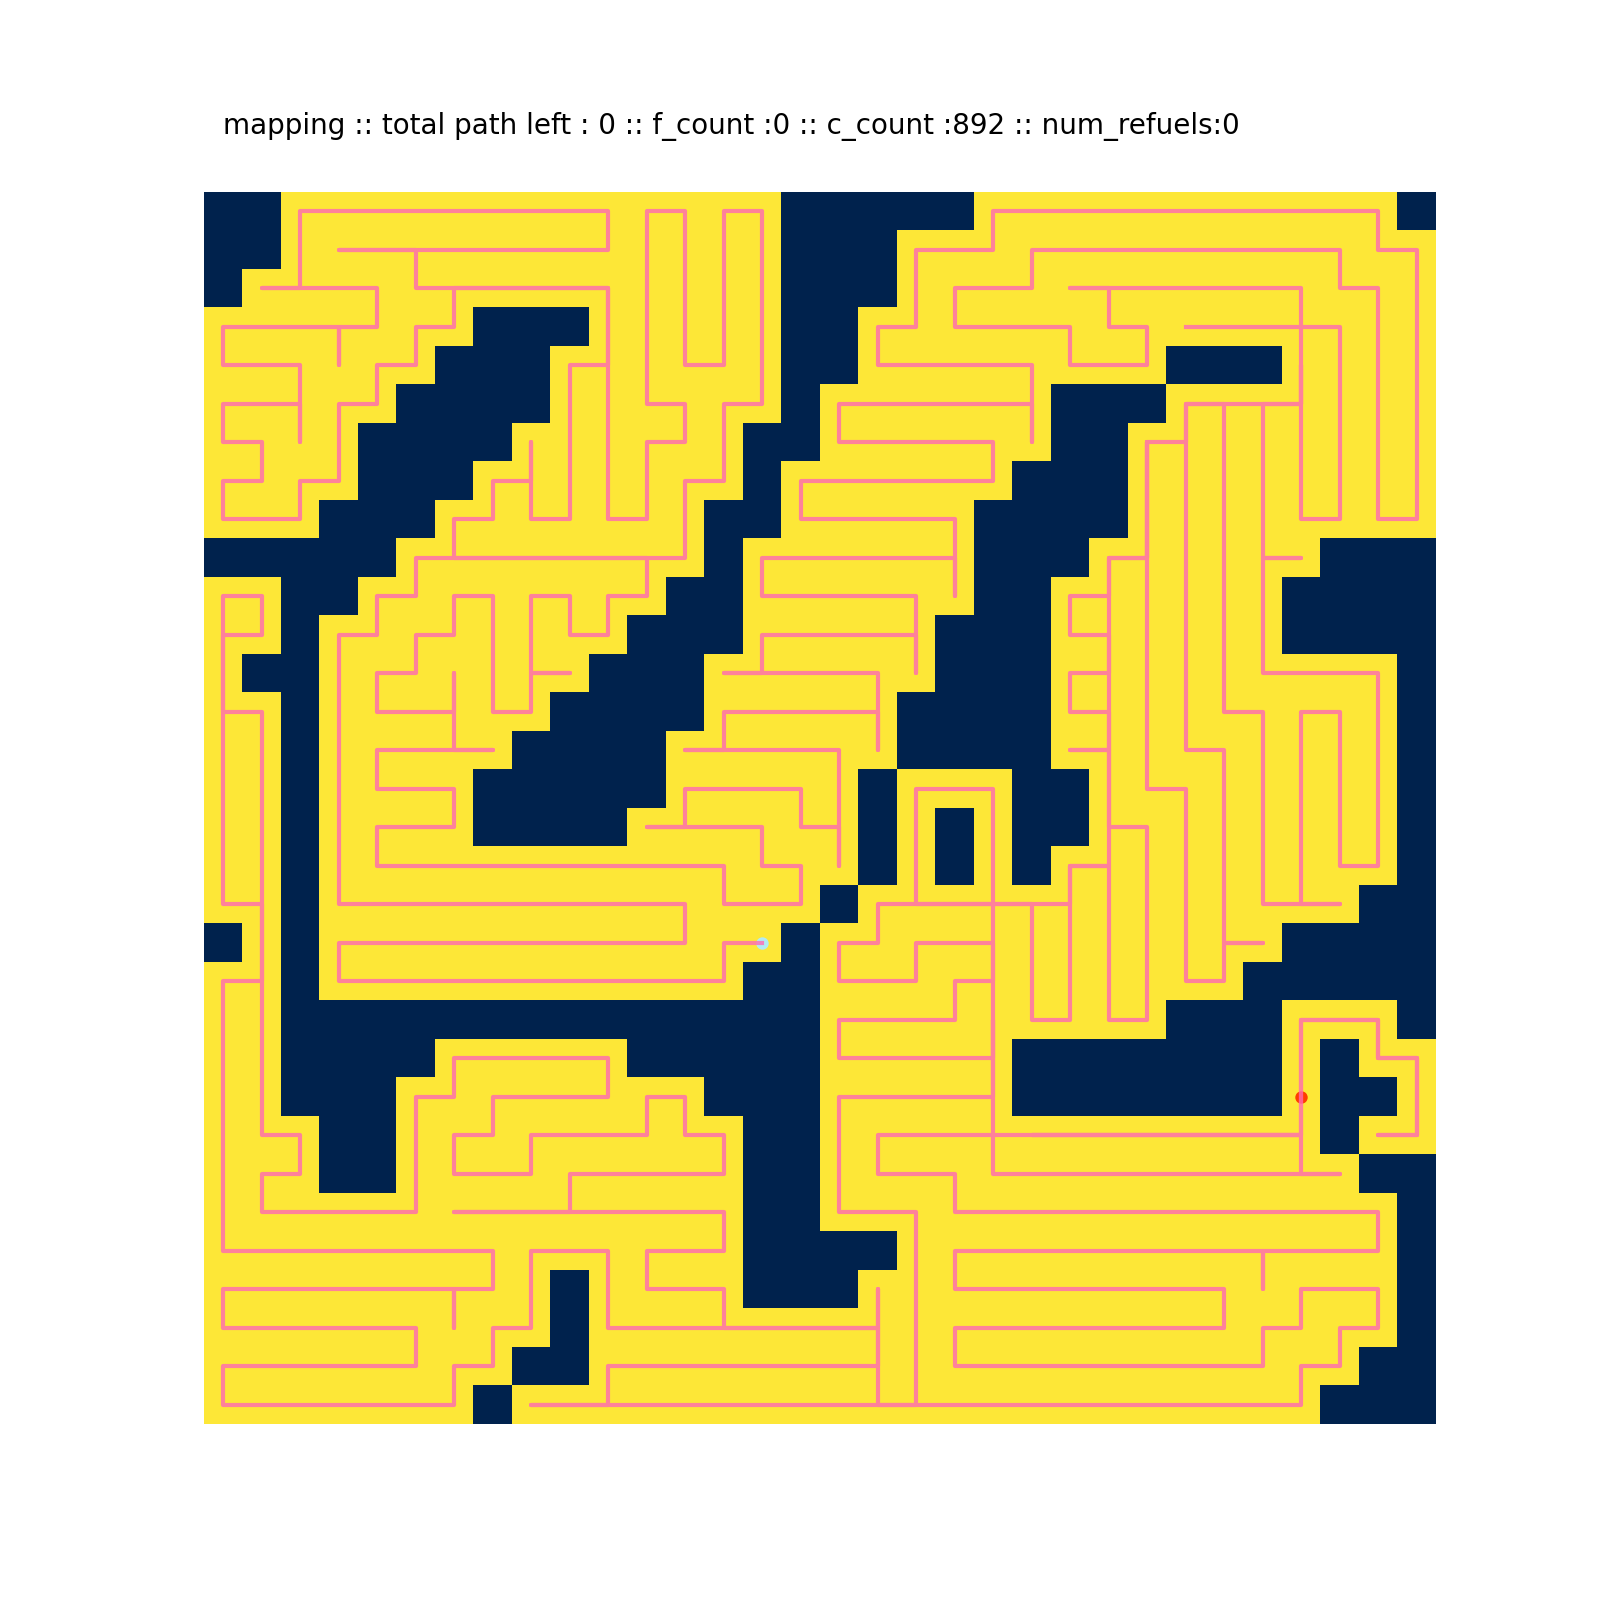

     cp_compute_time : 0.09020400047302246
     points_to_visit : 772
     obstacle_points : 252
      points_visited : 772
   coverage_path_len : 892
            coverage : 1.0
          redundancy : 0.15544041450777213
          area_shape : (32, 32)


In [7]:
metrics, _ = single_robot_single(wavefront, area_maps[8], animate=True, interval=1, fuel_paths=False)

## Testing Fuel Distance Map Generations

**Fuel Distance maps** generated from all the **area maps**
in the `test_maps` folder.  
Black points : Fuel

<IPython.core.display.Javascript object>


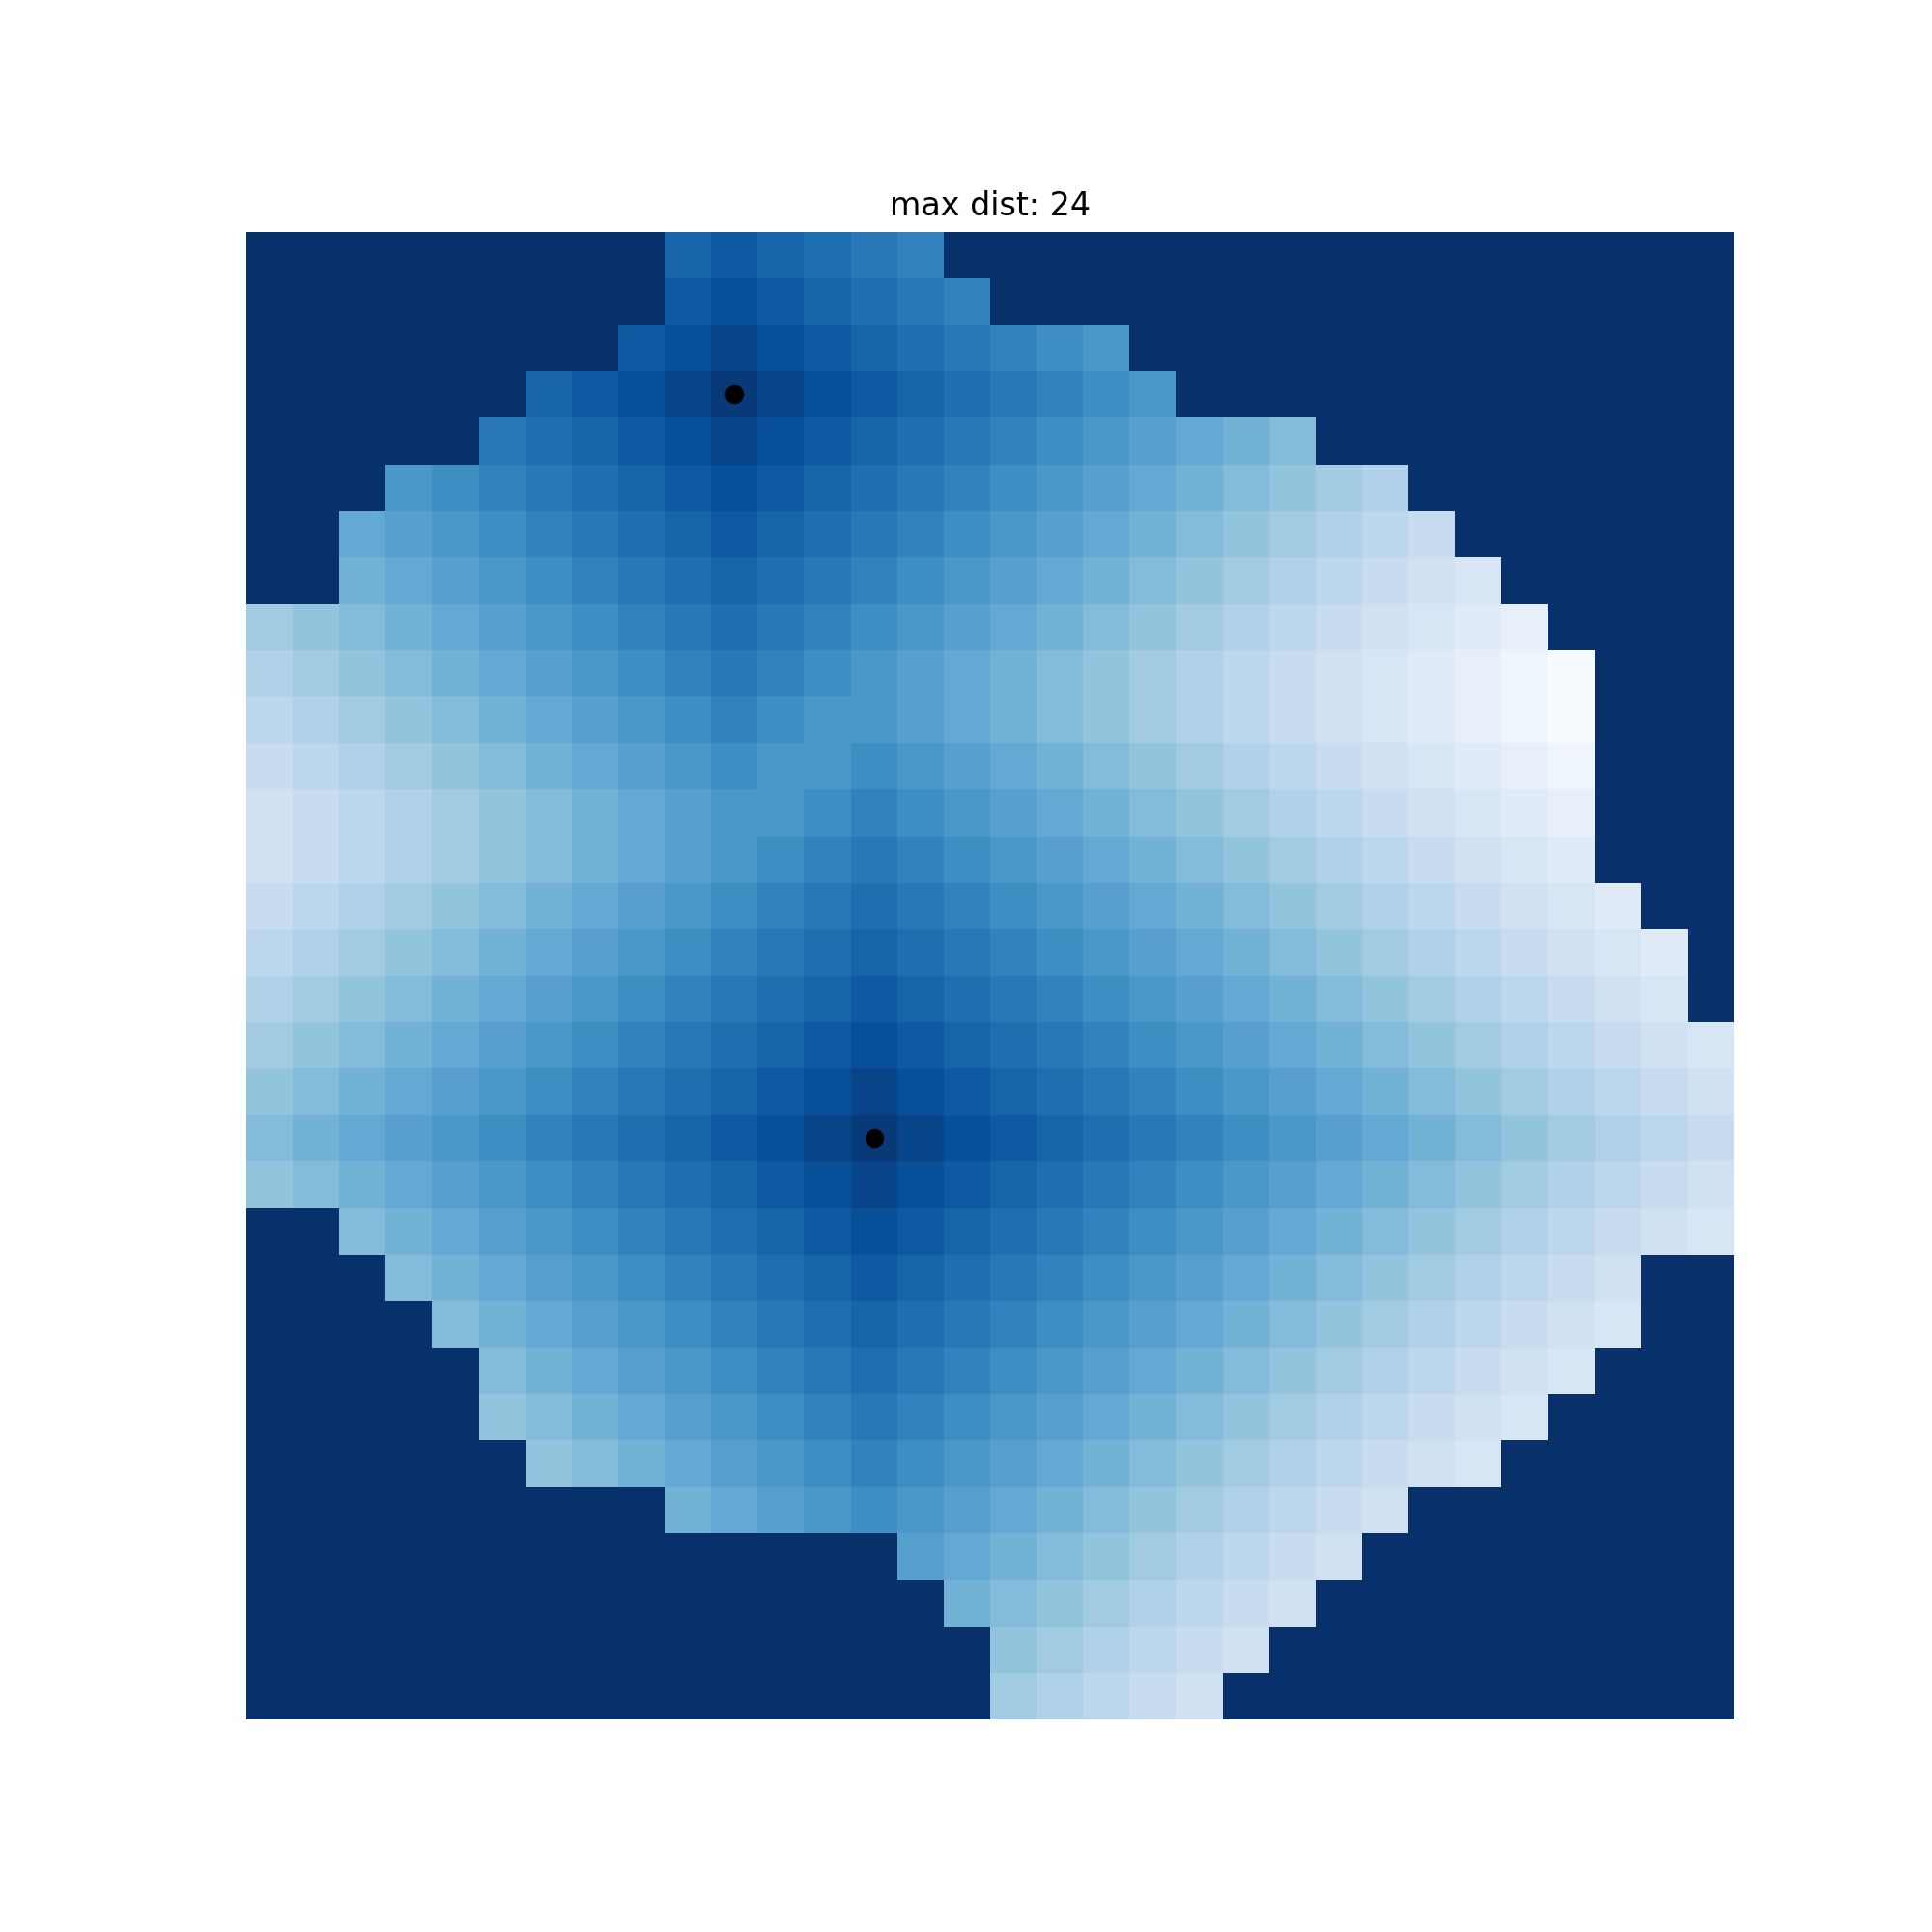

<IPython.core.display.Javascript object>


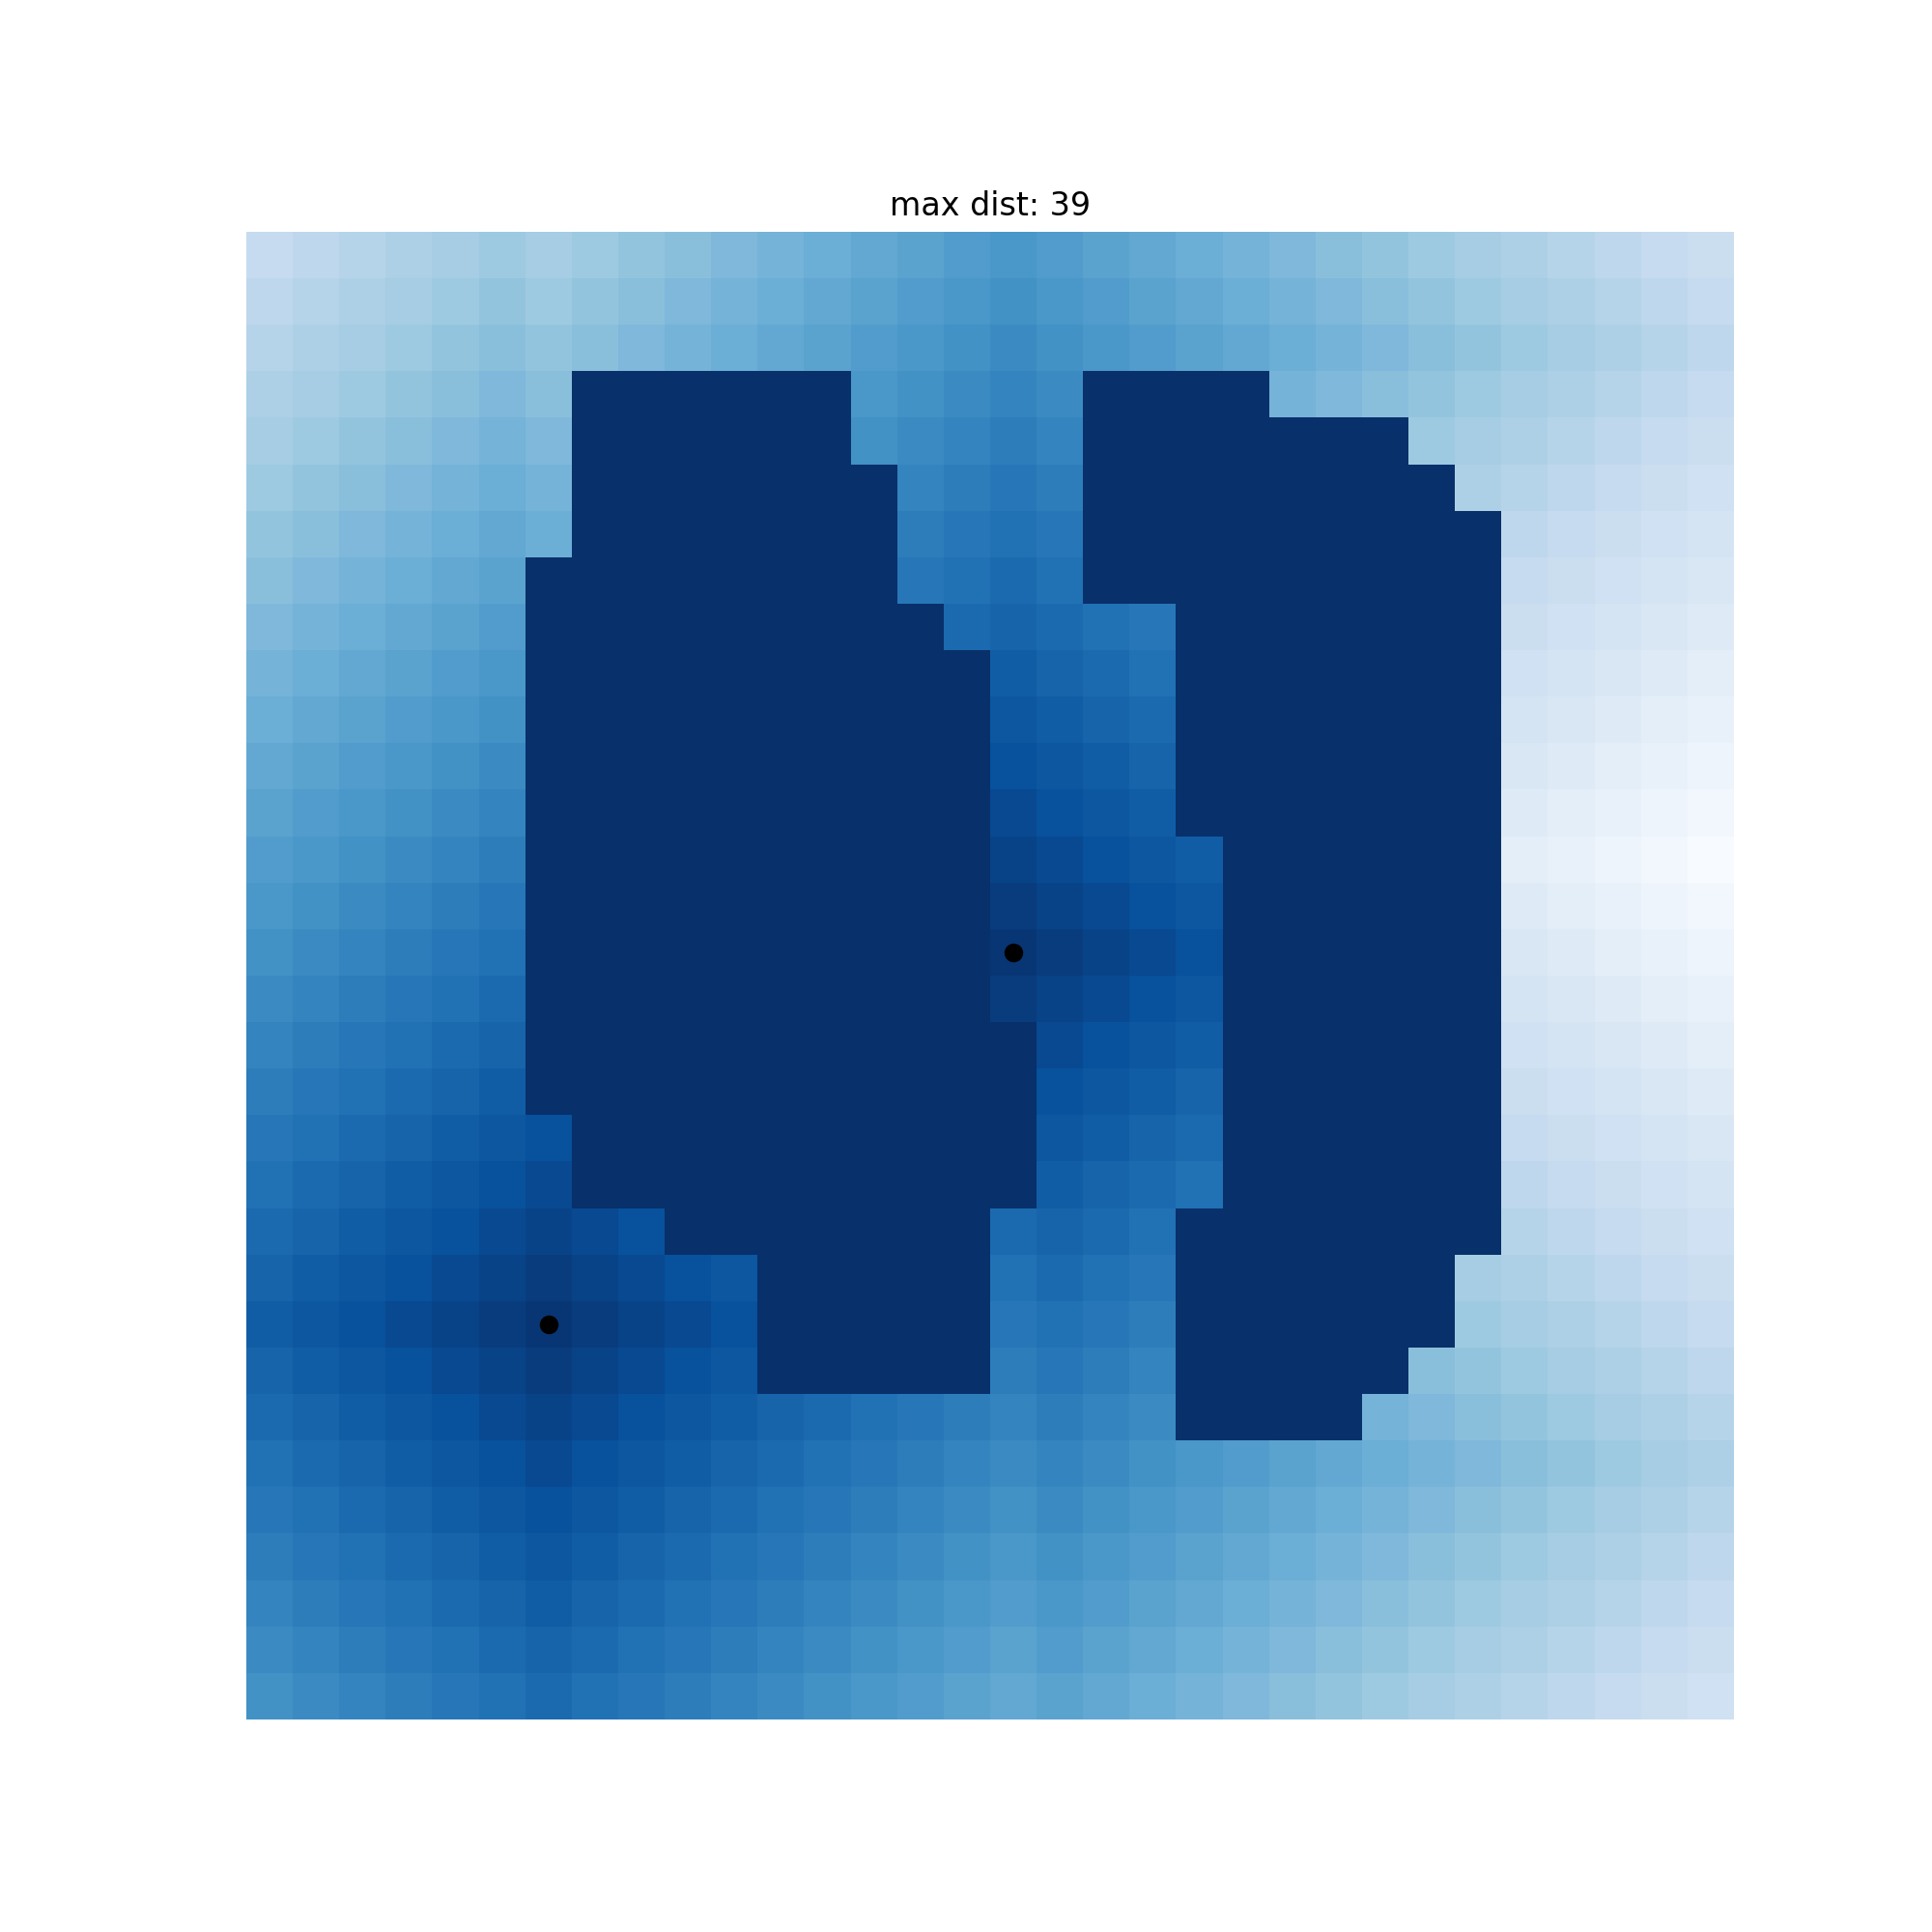

<IPython.core.display.Javascript object>


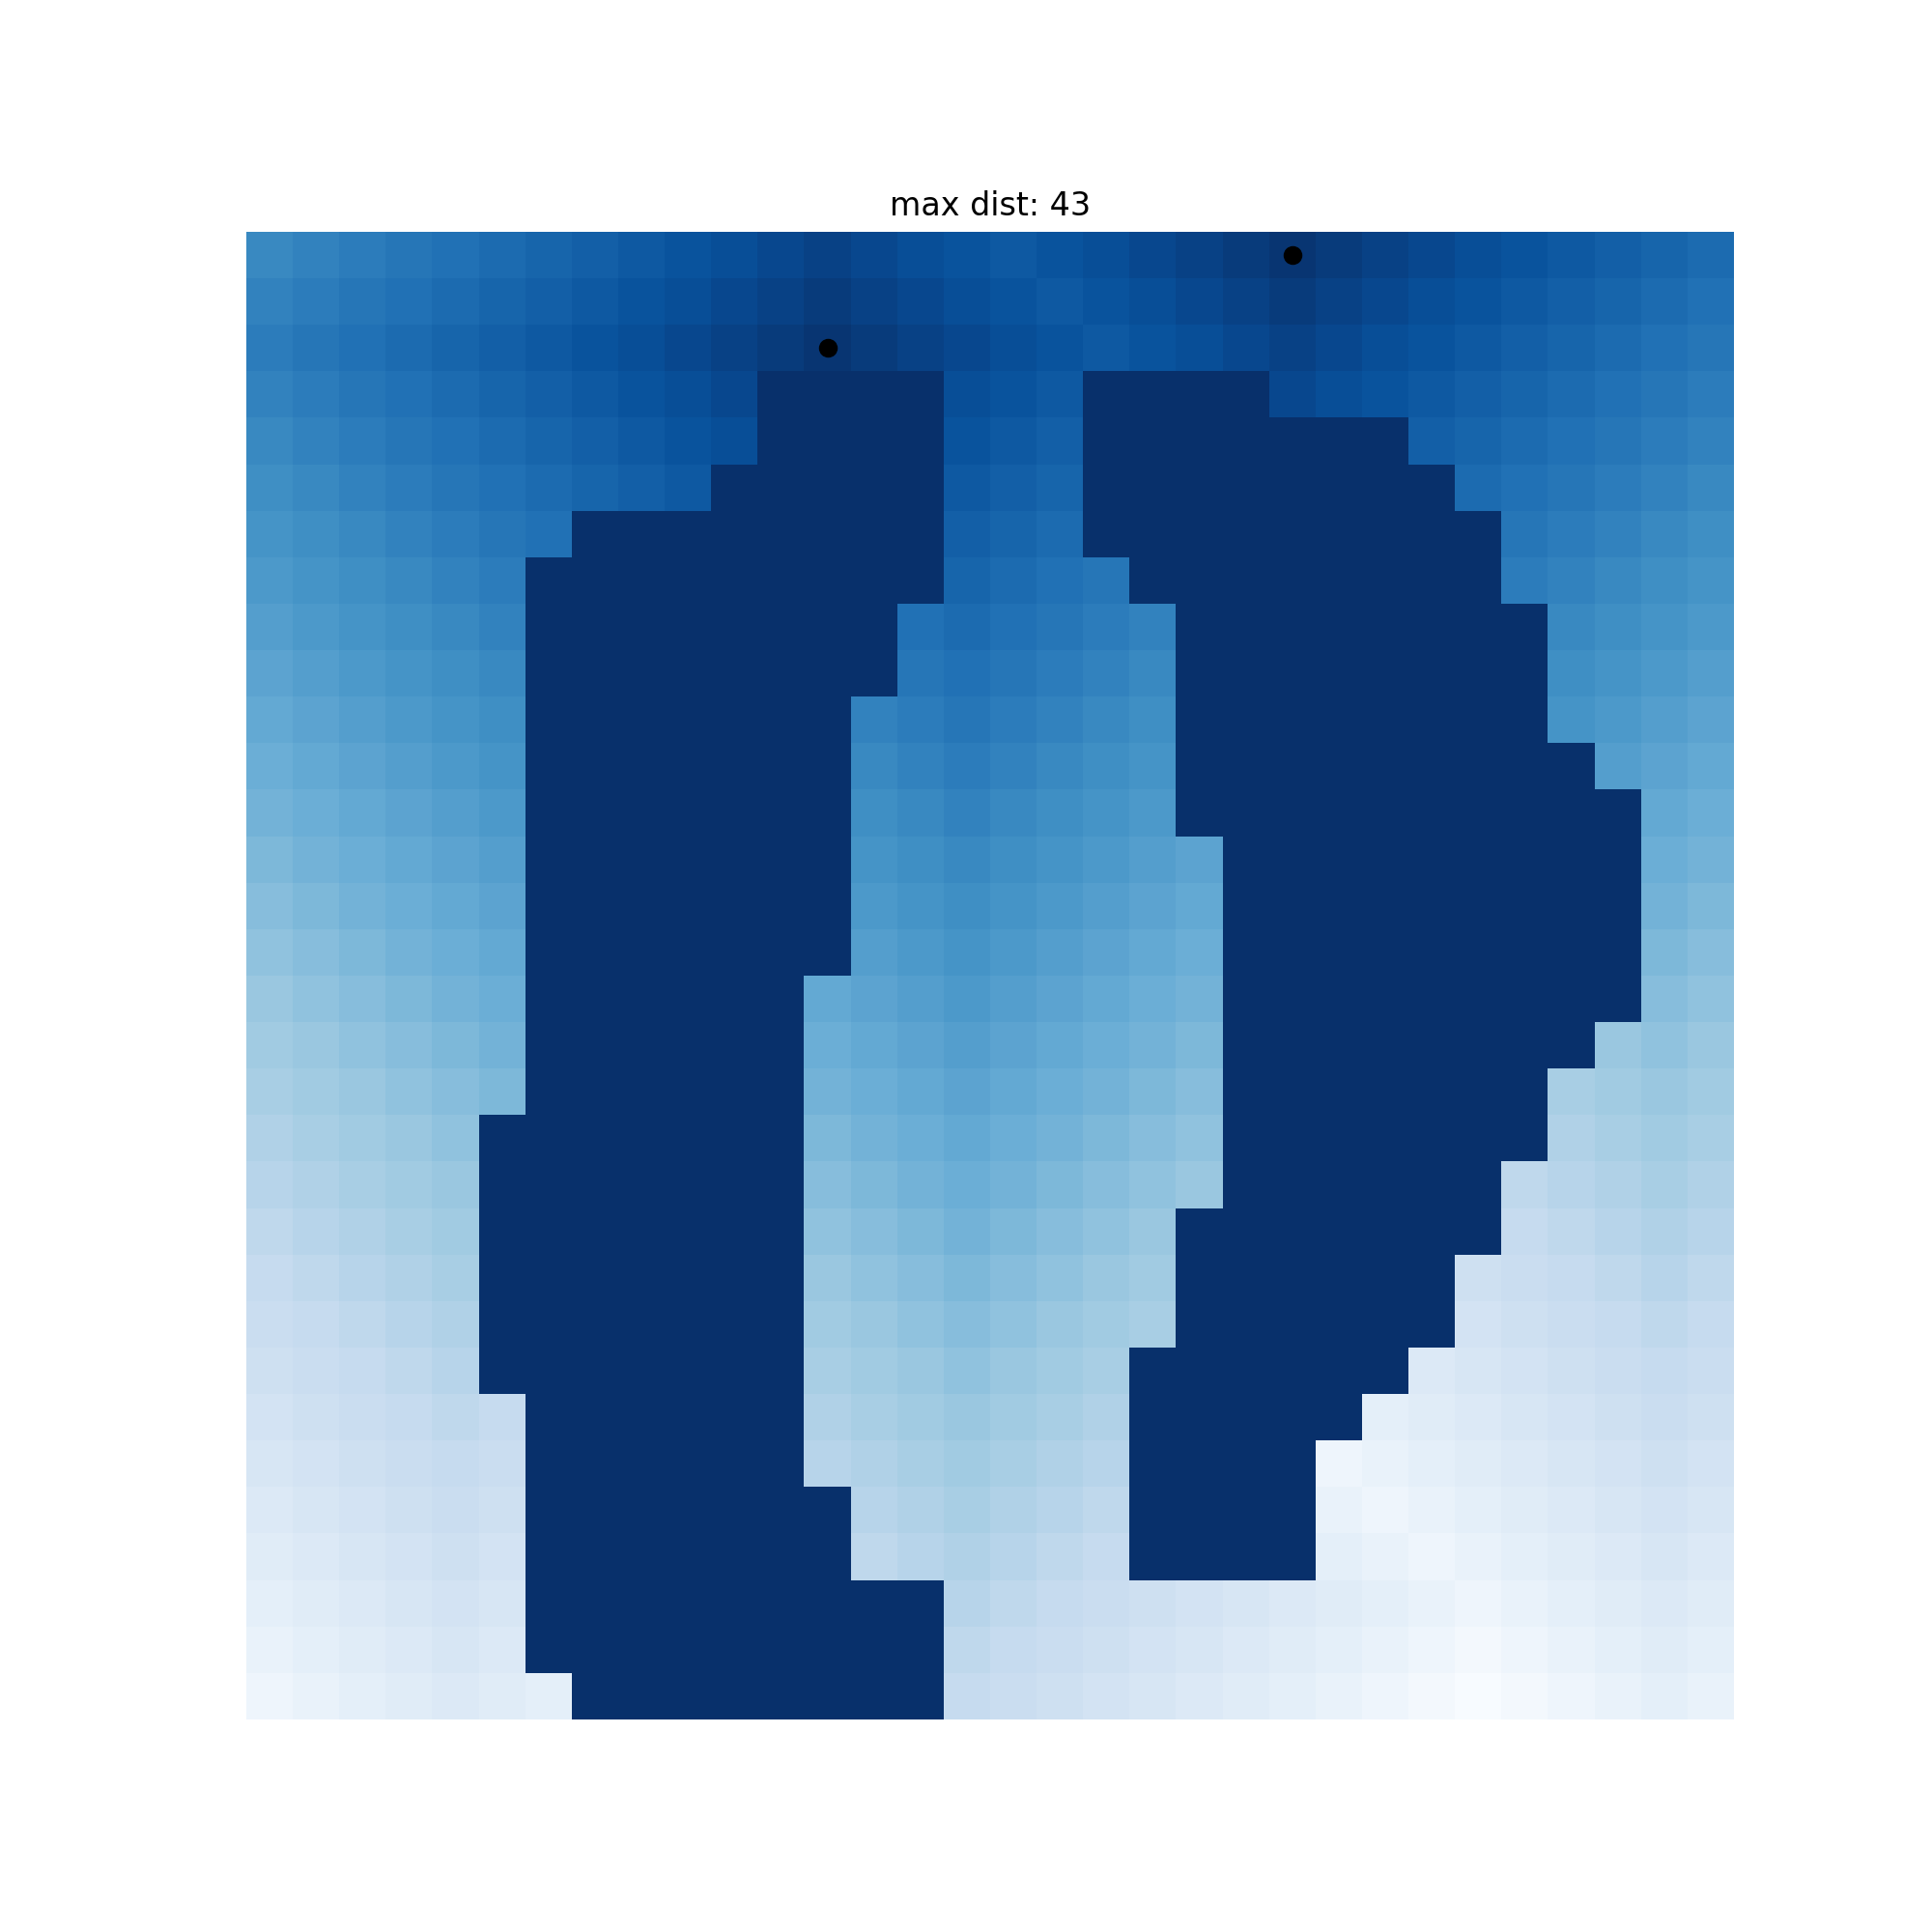

<IPython.core.display.Javascript object>


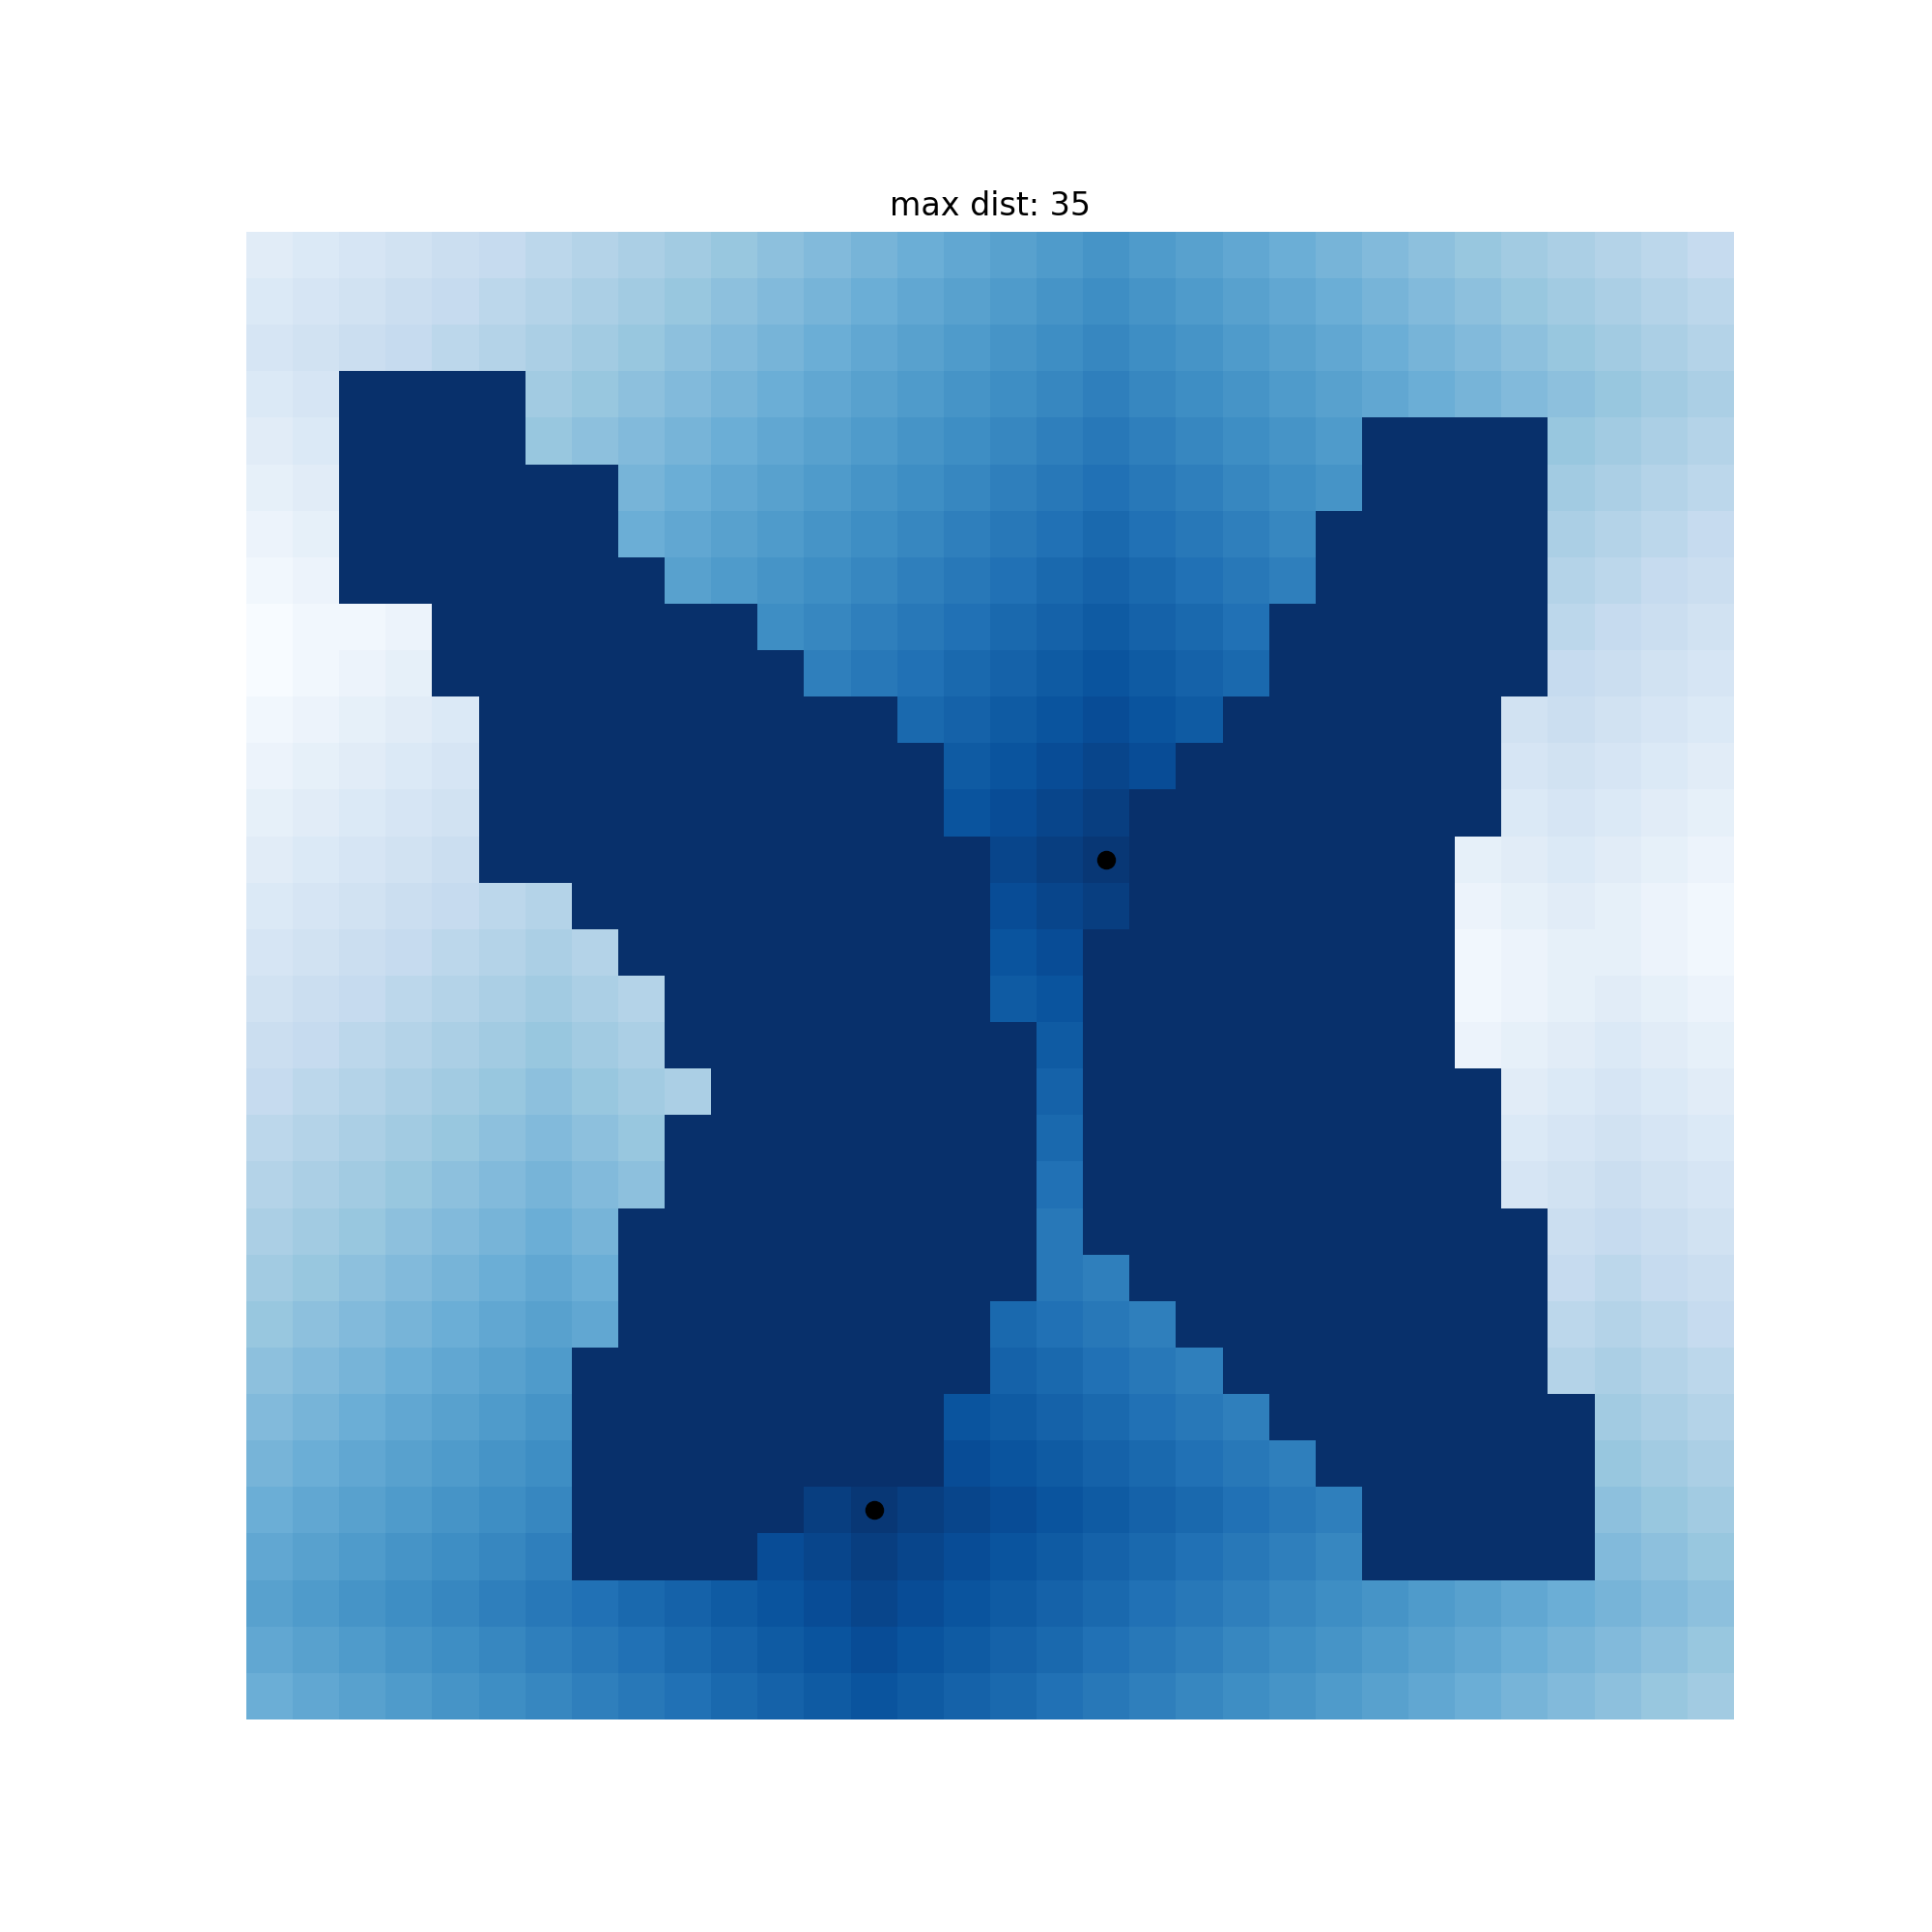

<IPython.core.display.Javascript object>


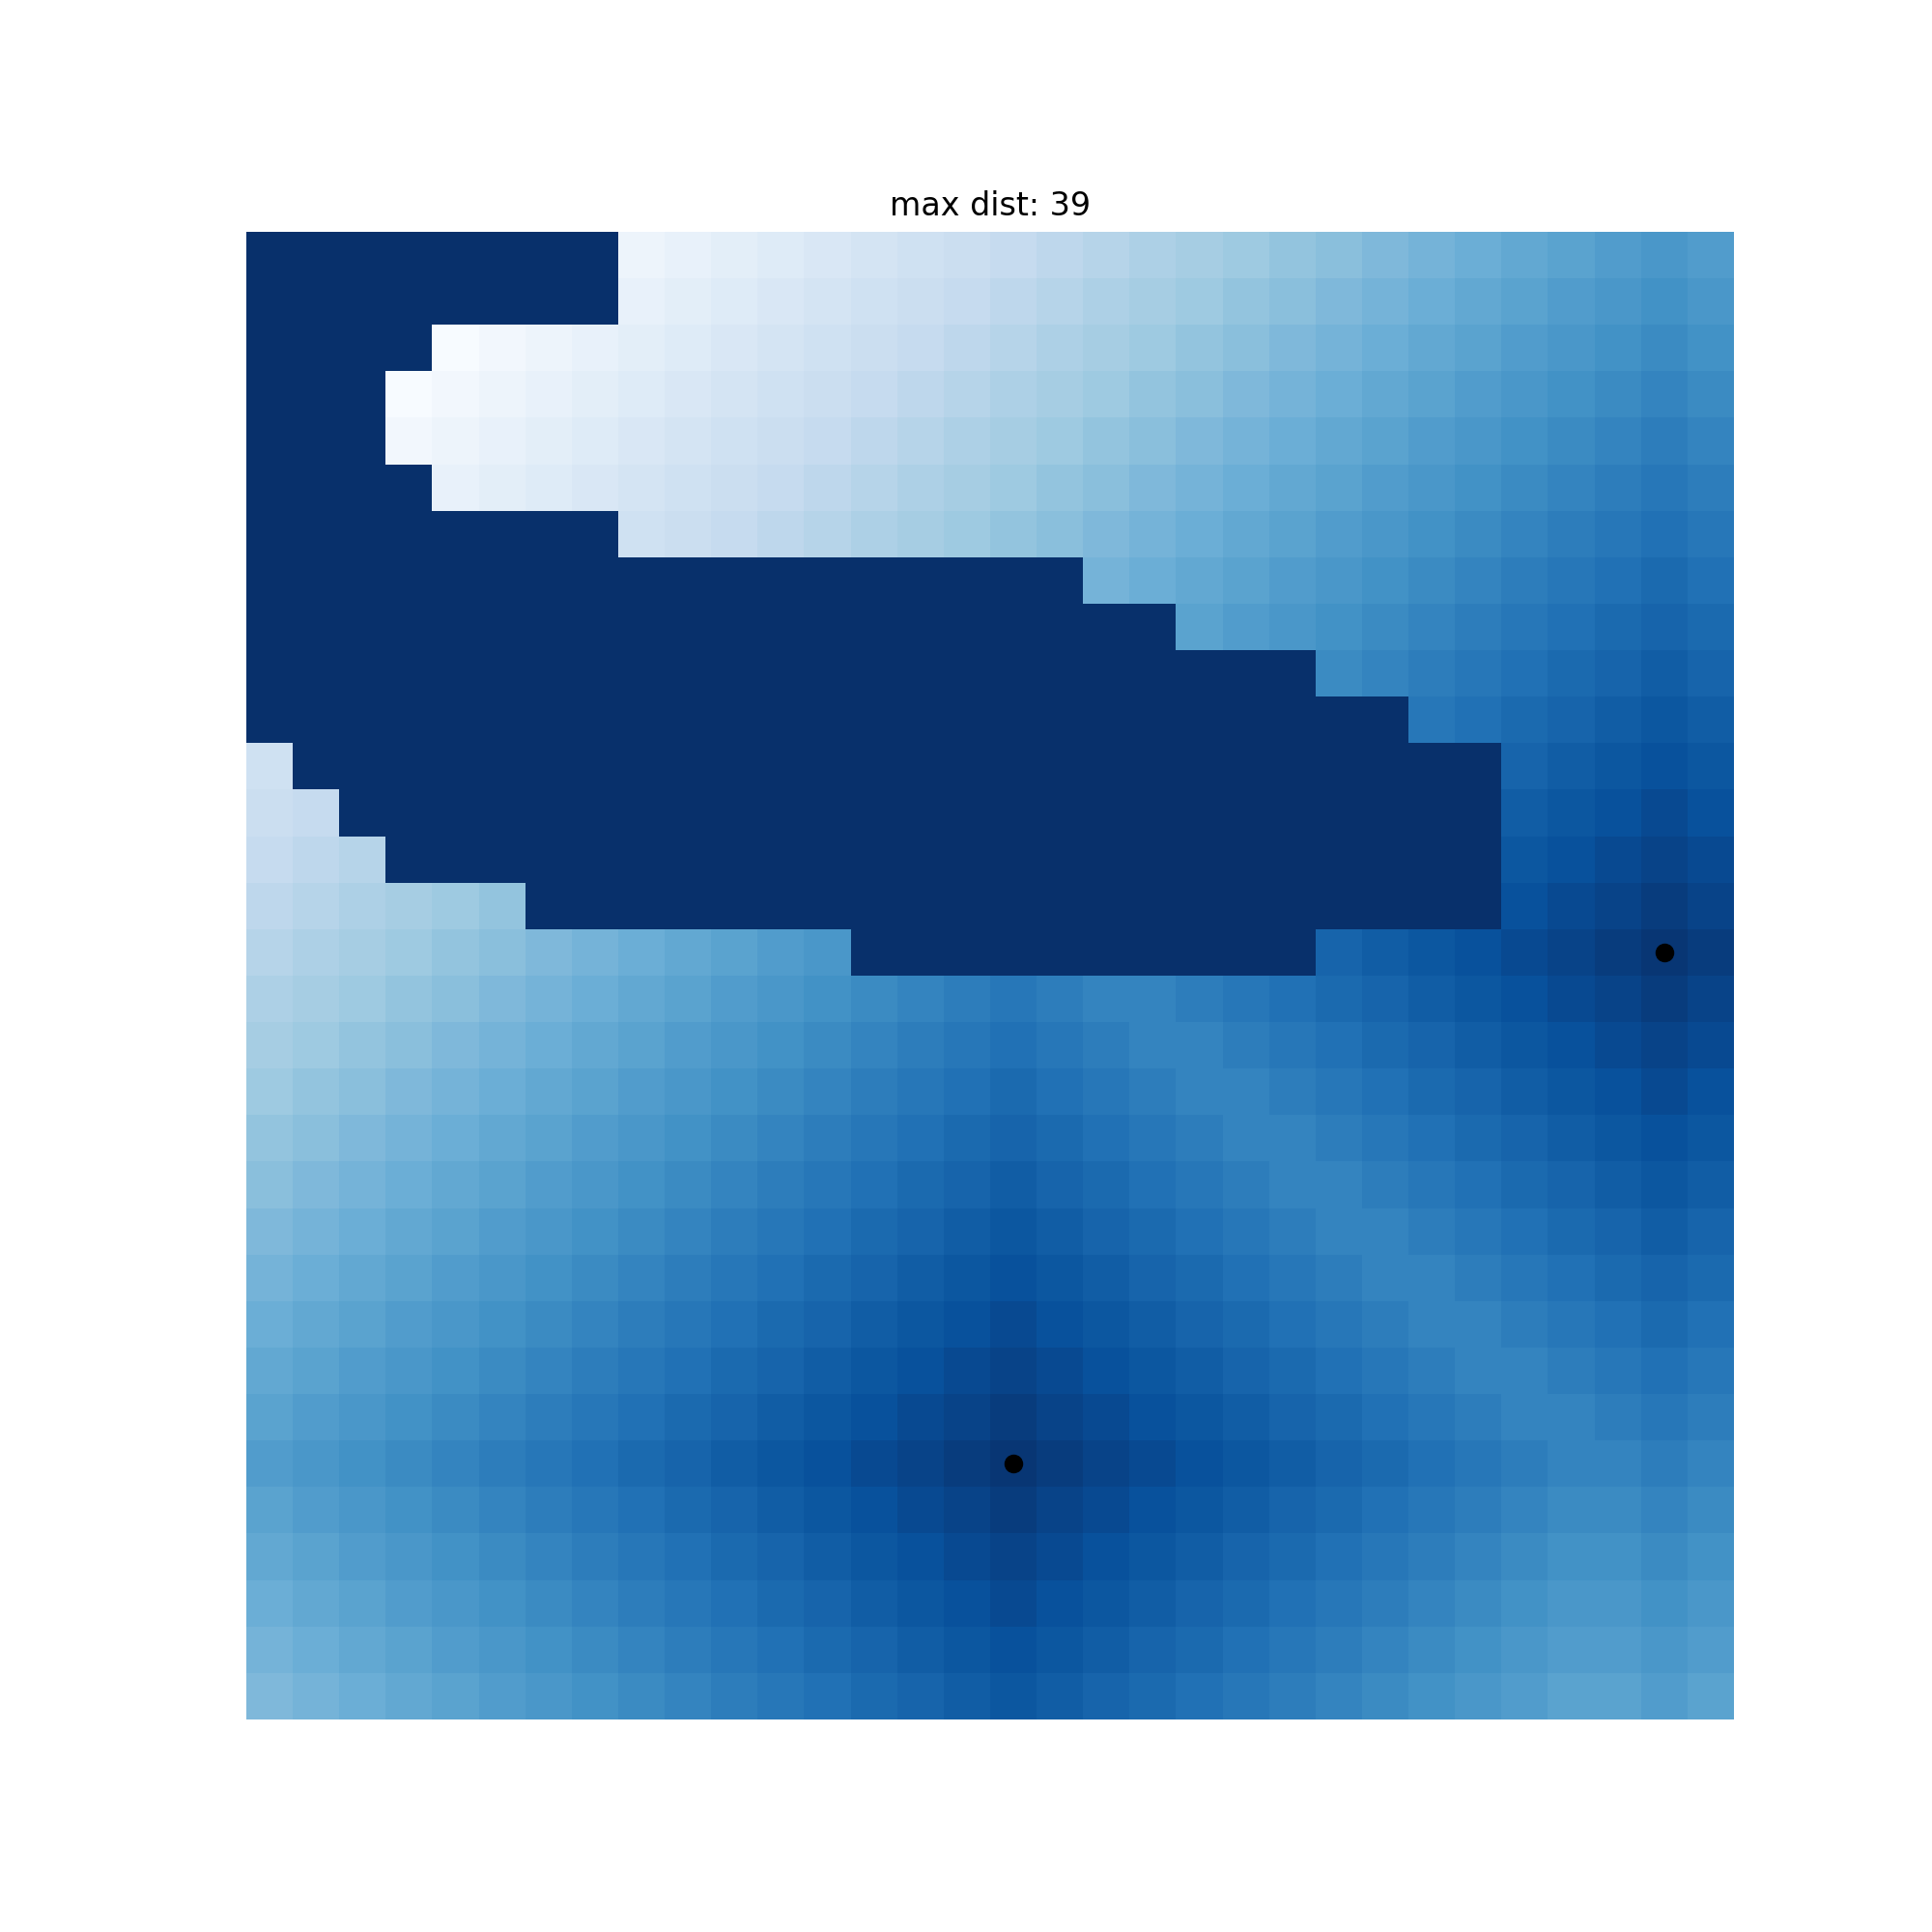

<IPython.core.display.Javascript object>


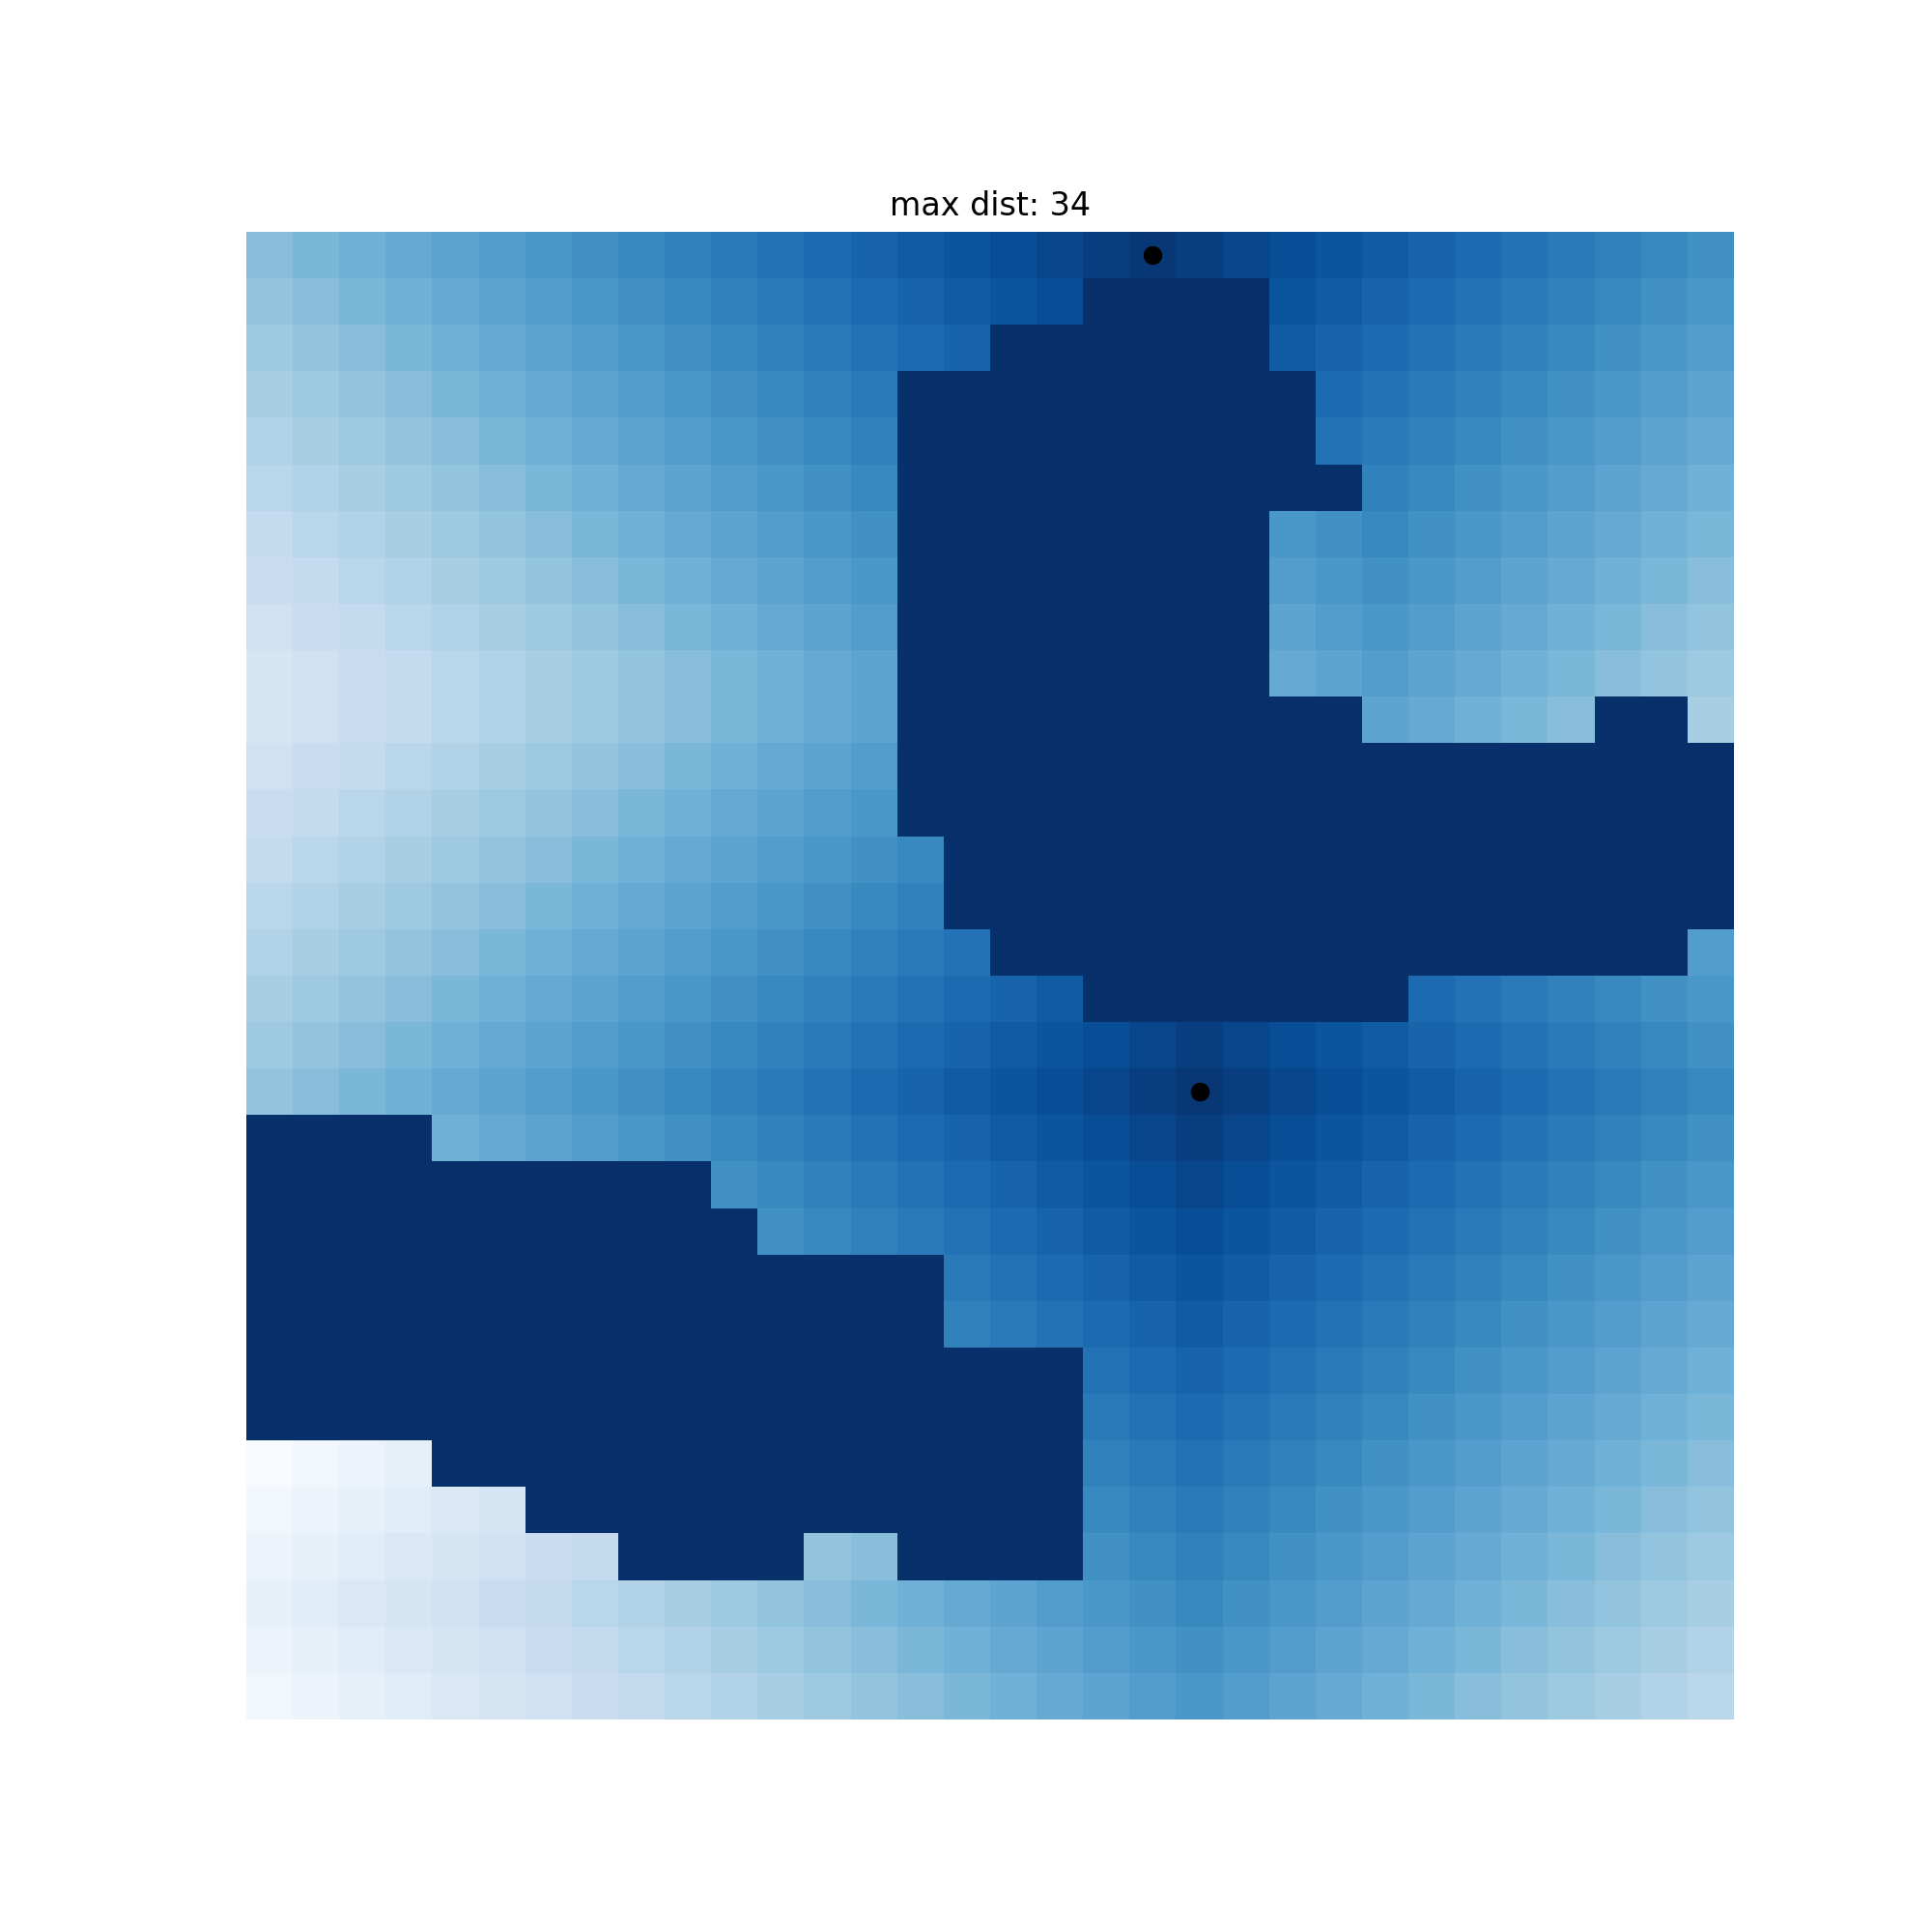

<IPython.core.display.Javascript object>


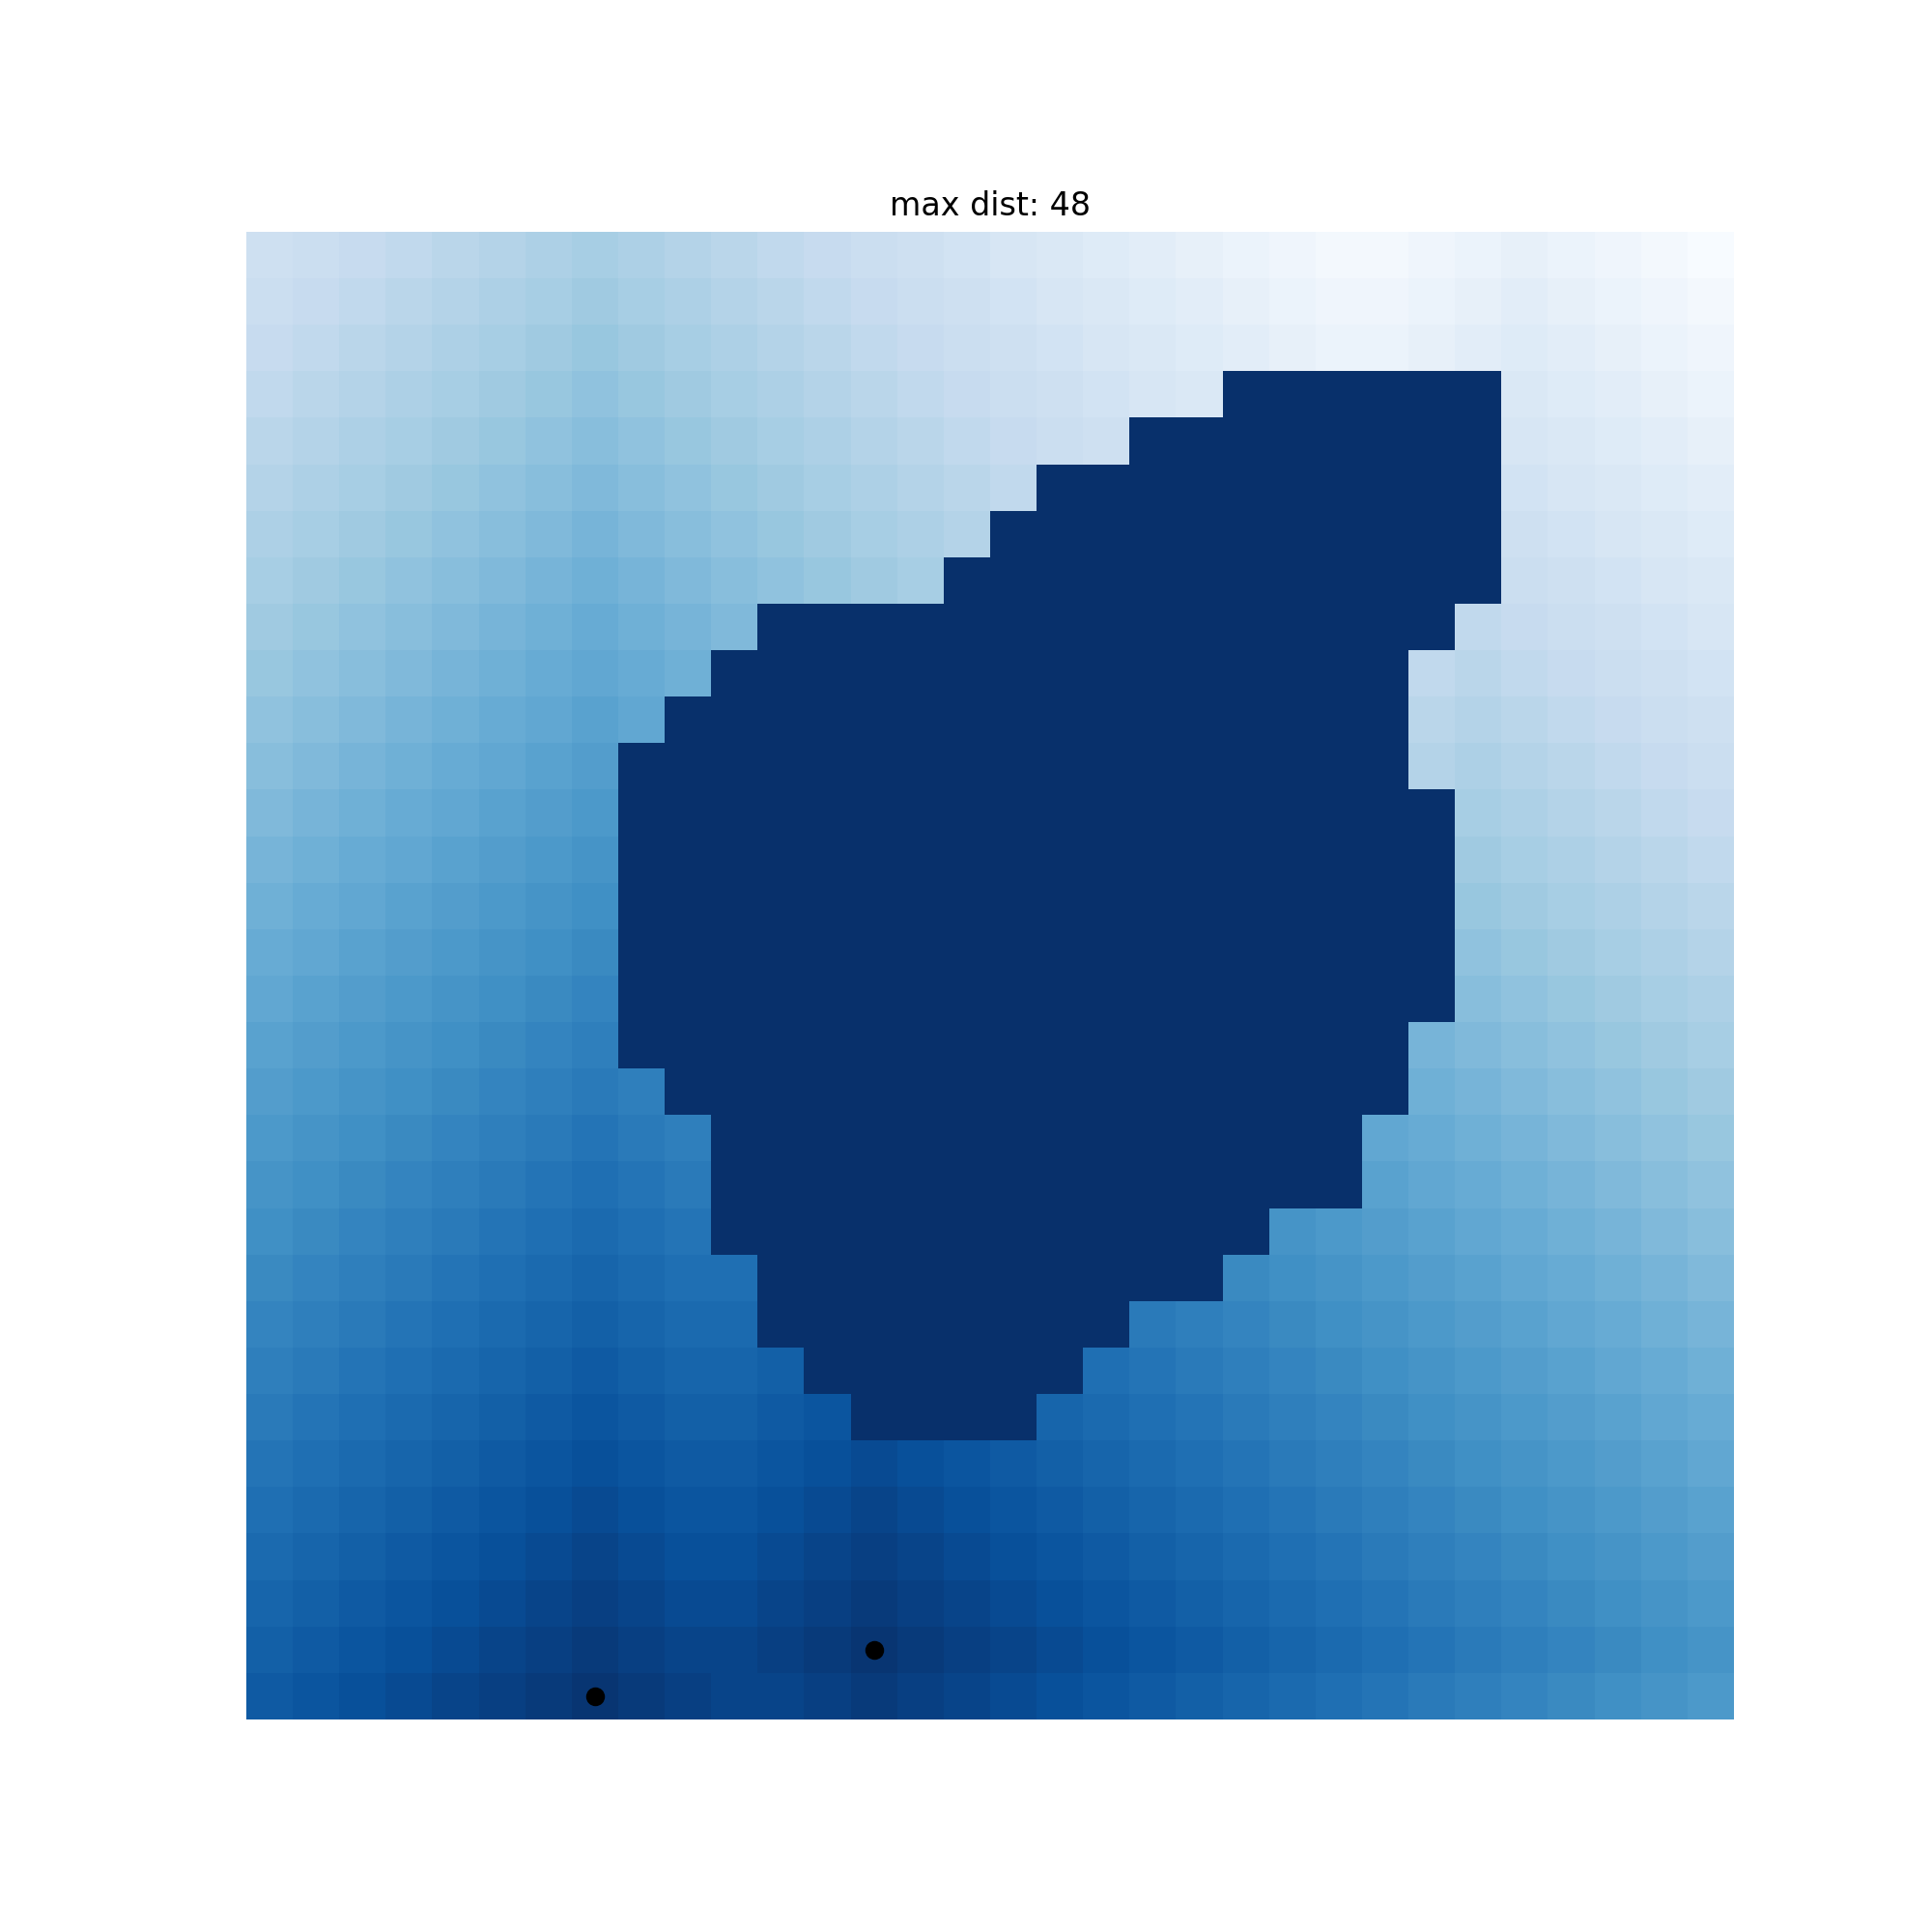

<IPython.core.display.Javascript object>


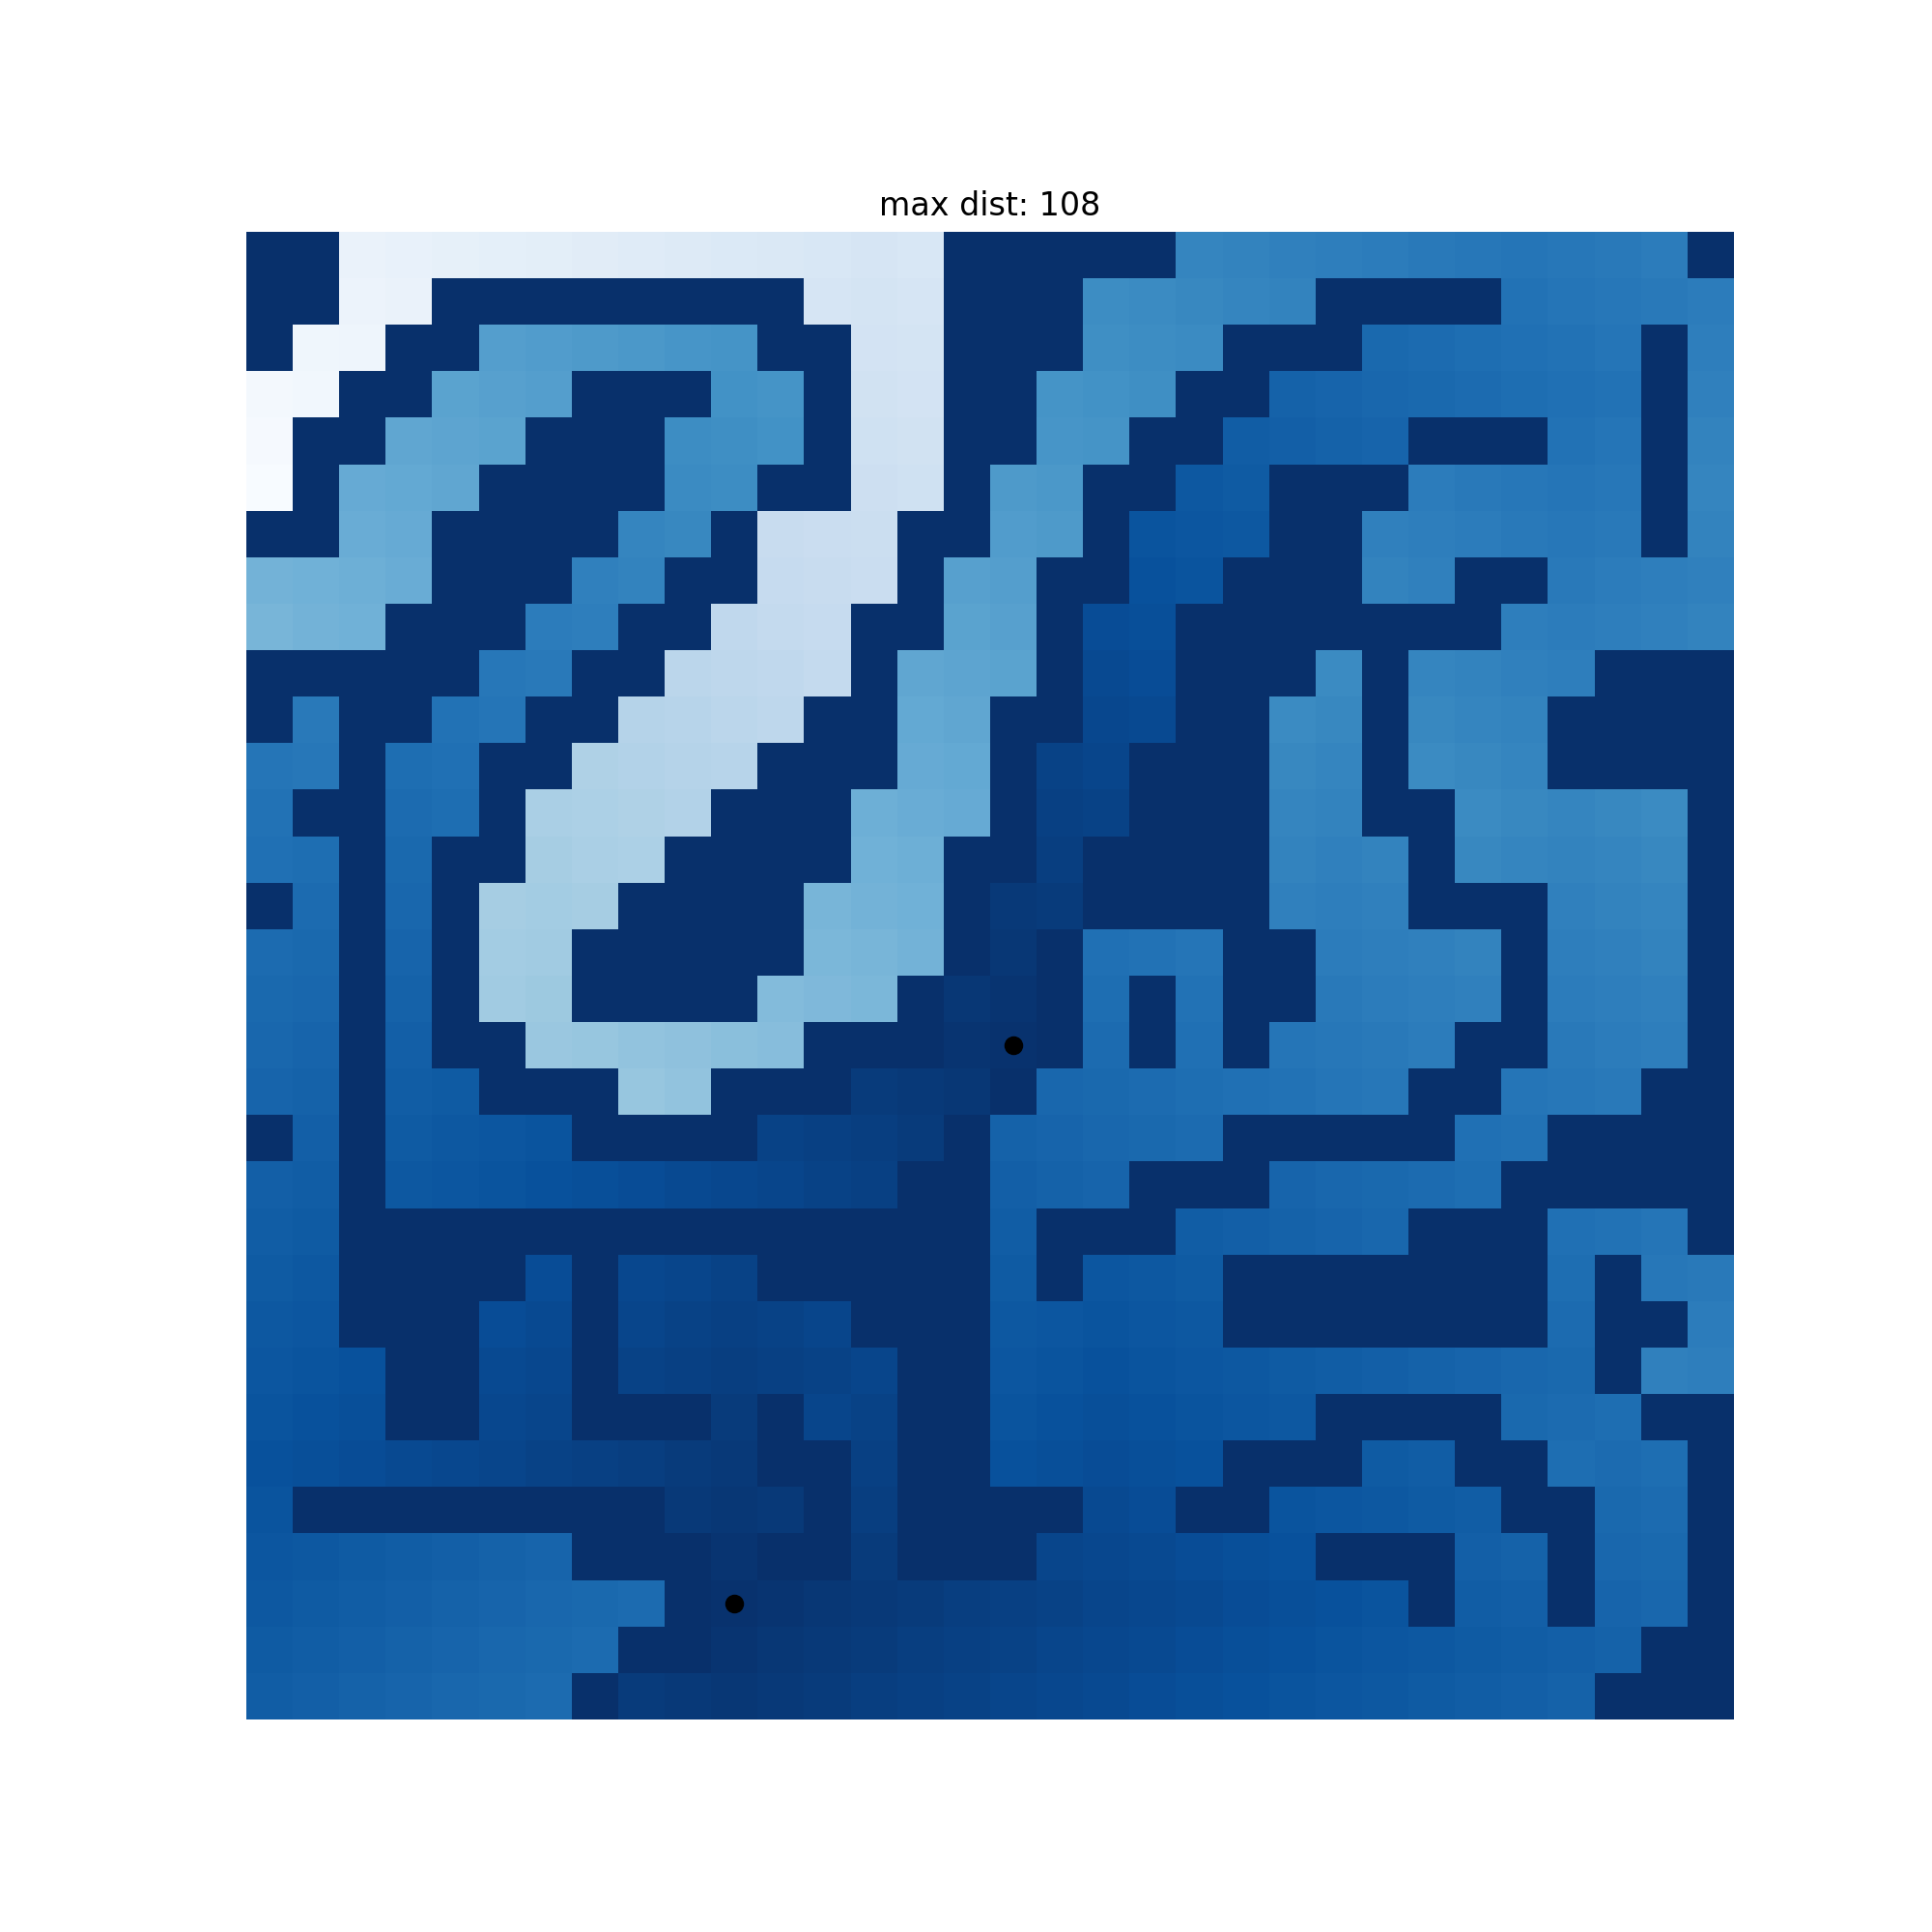

<IPython.core.display.Javascript object>


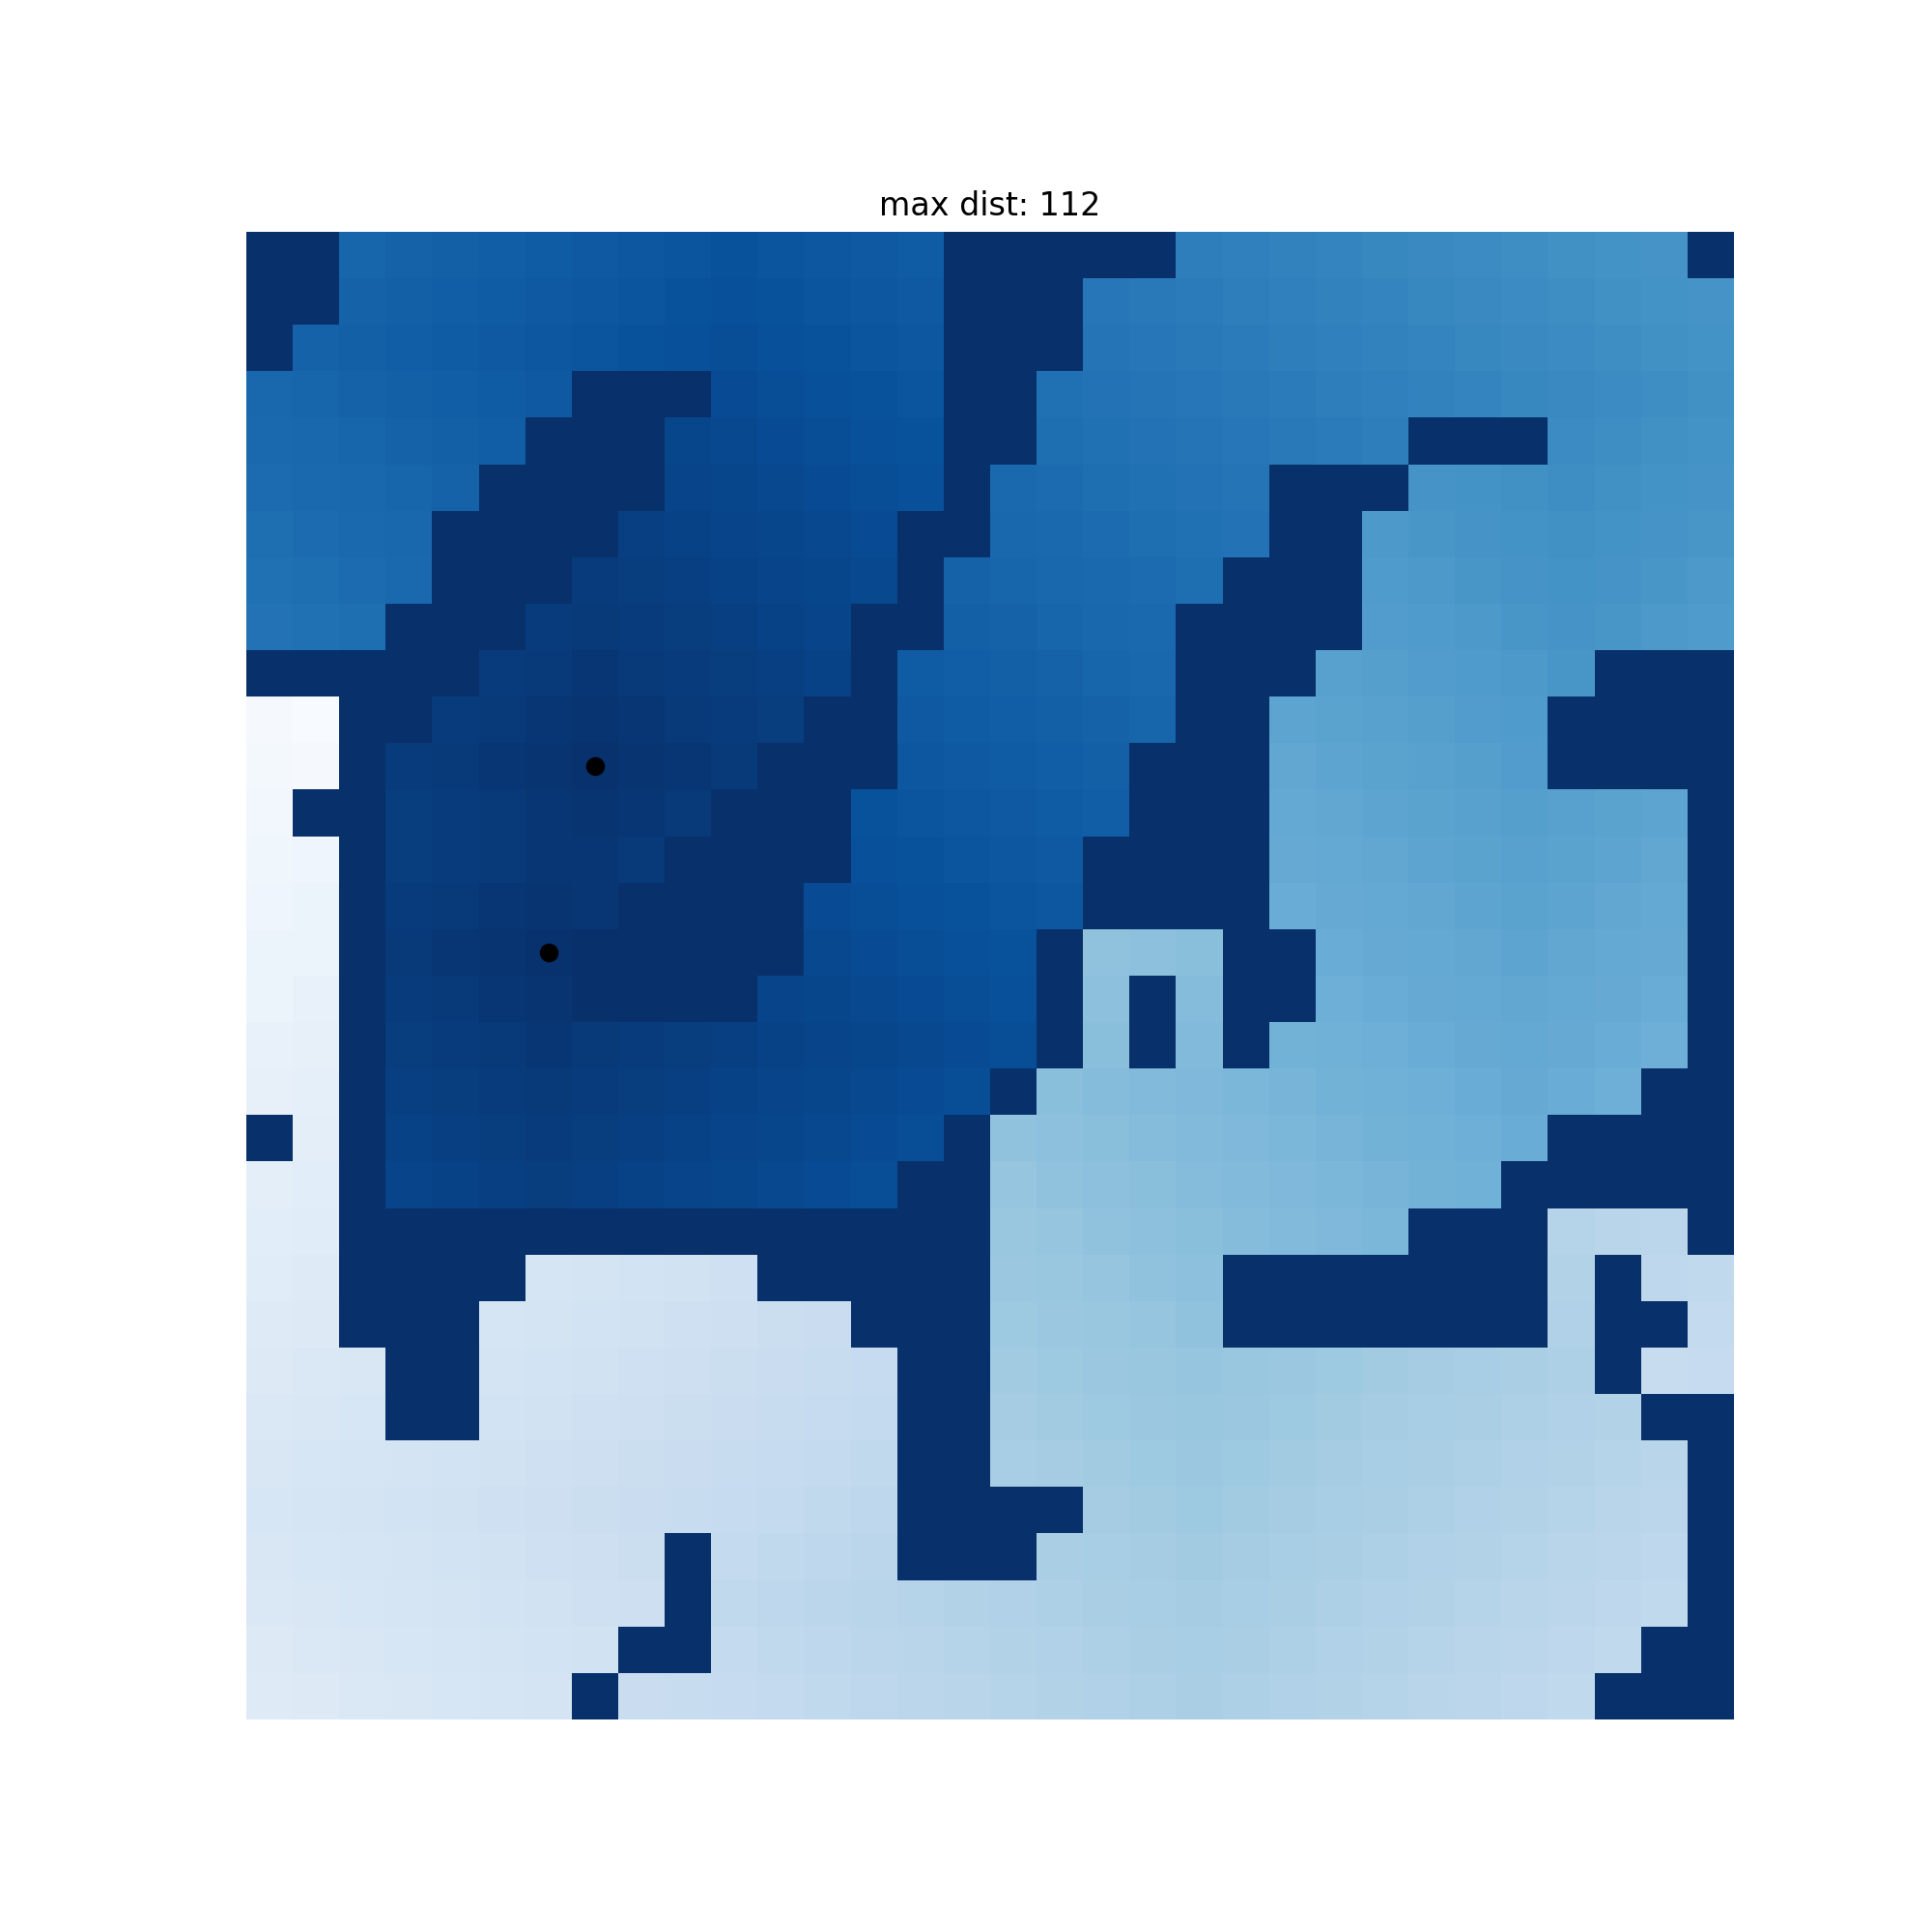

<IPython.core.display.Javascript object>


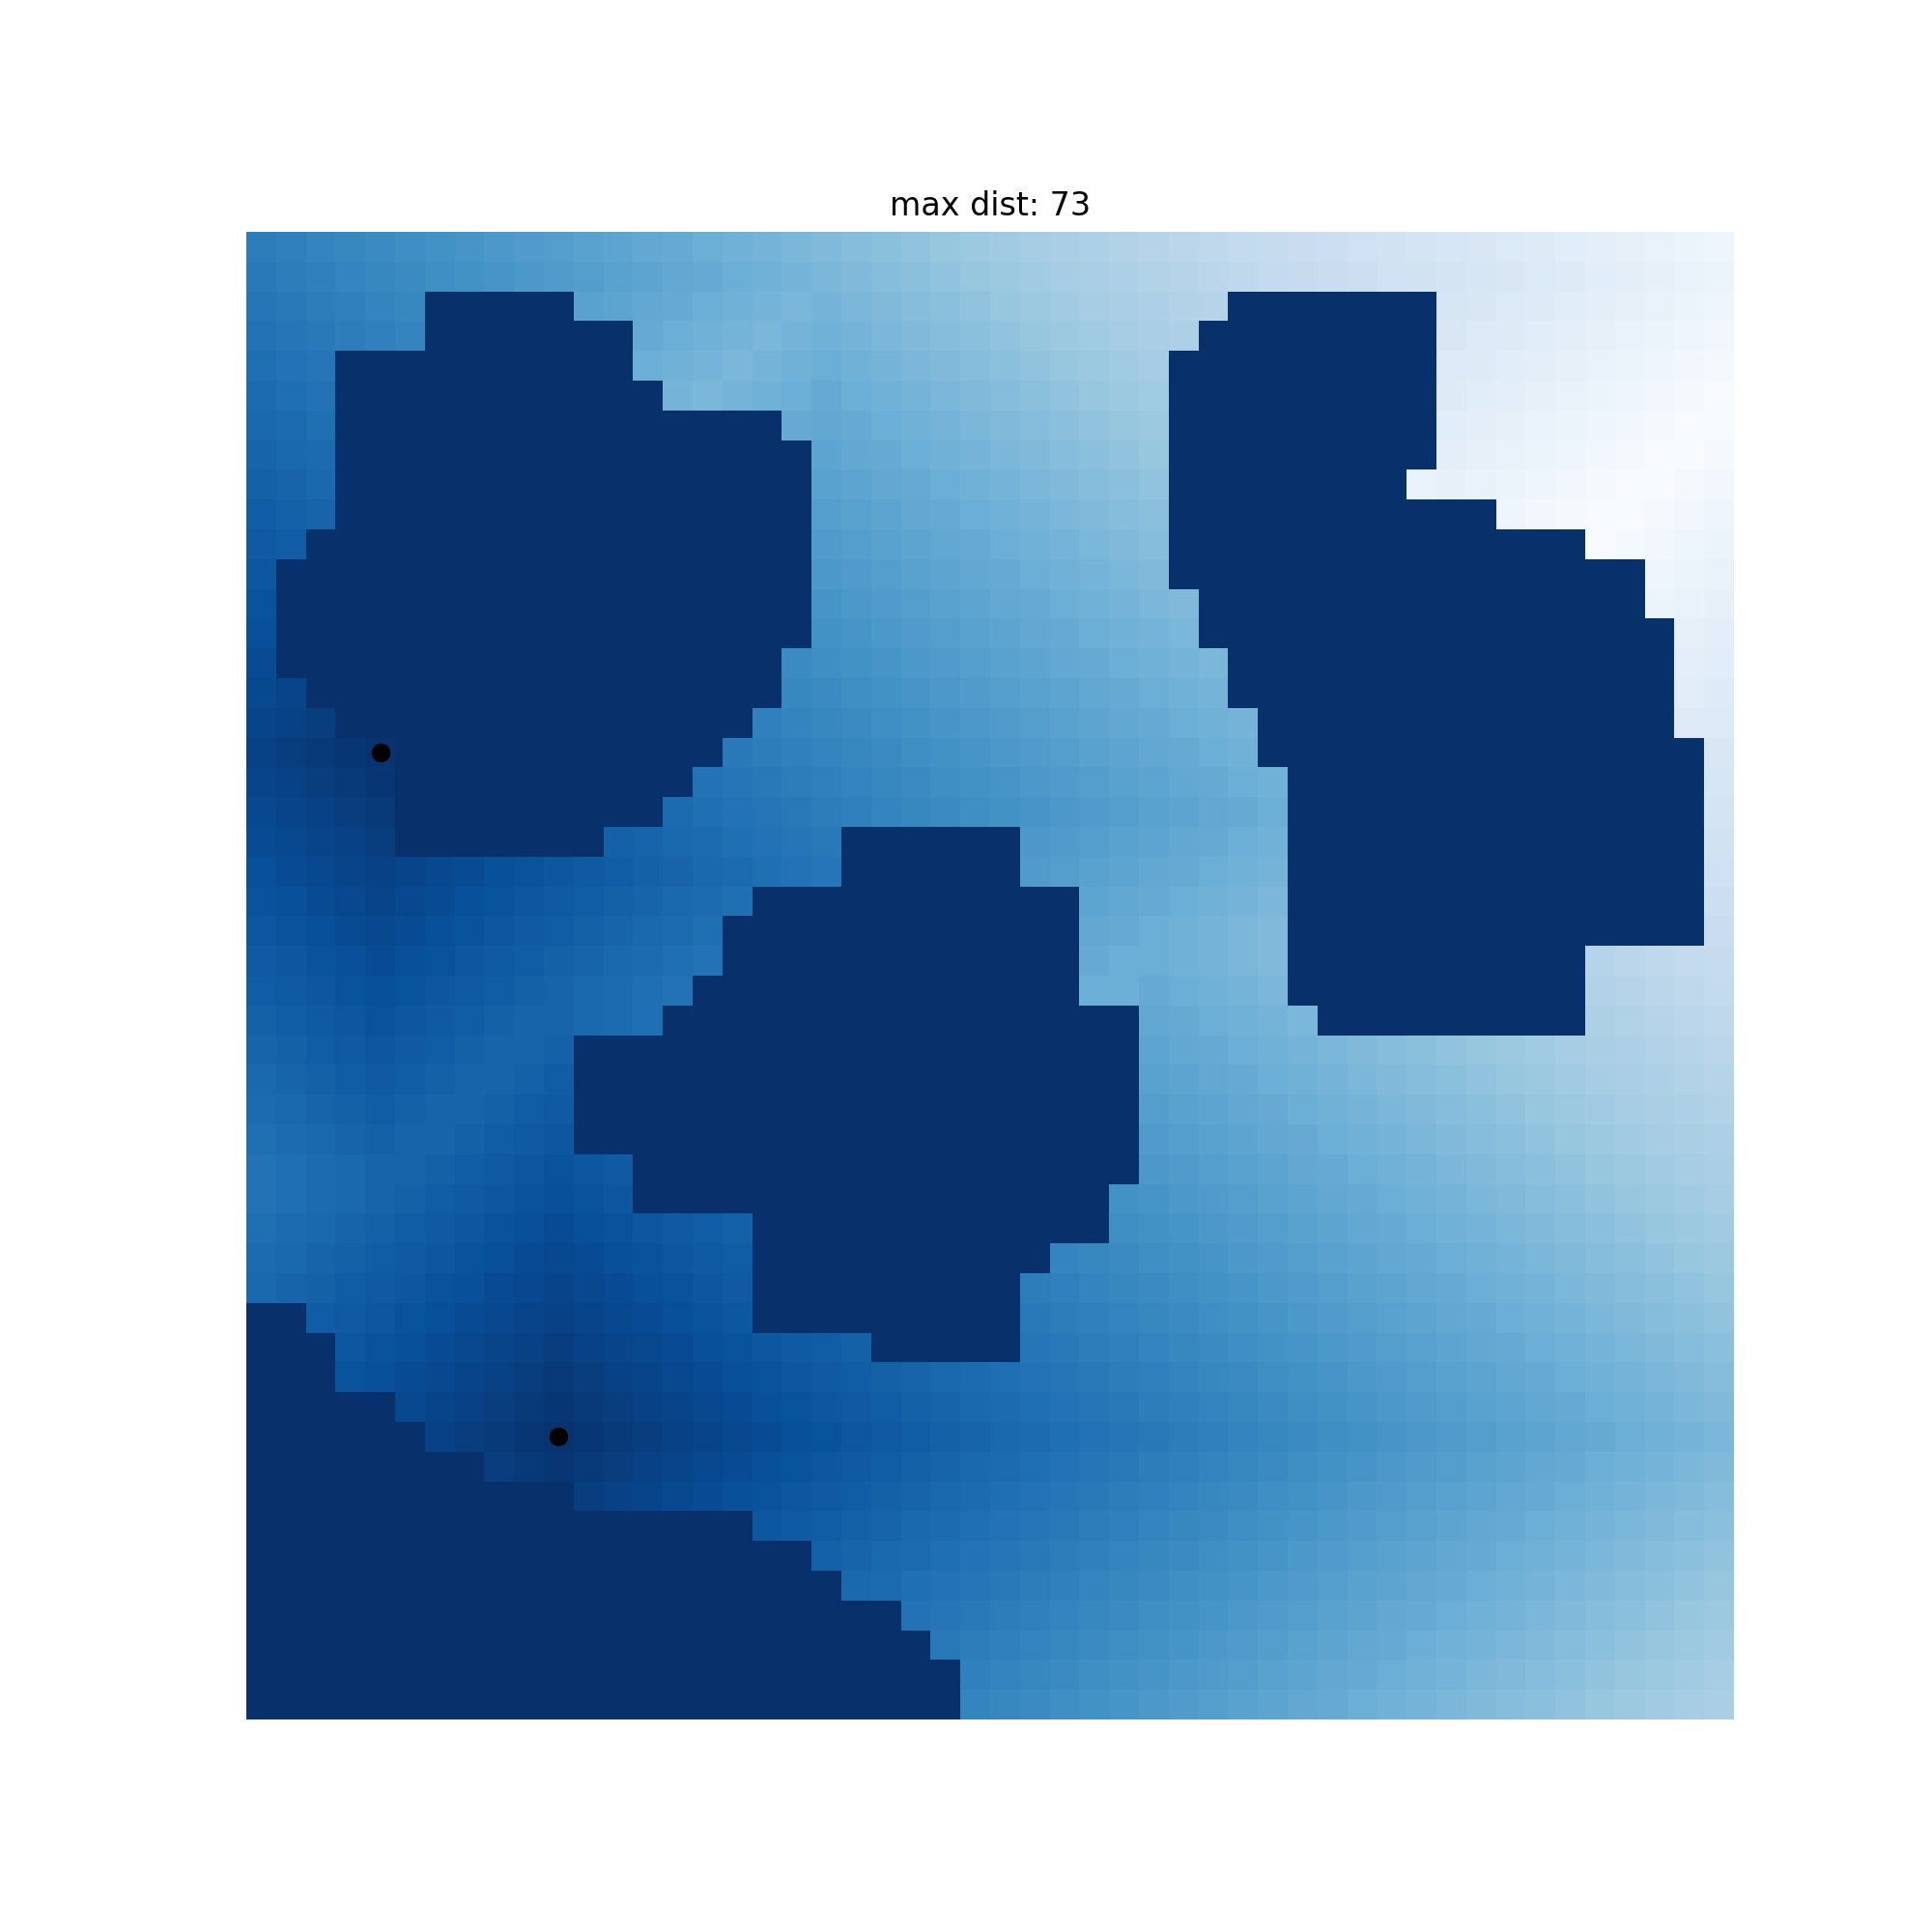

<IPython.core.display.Javascript object>


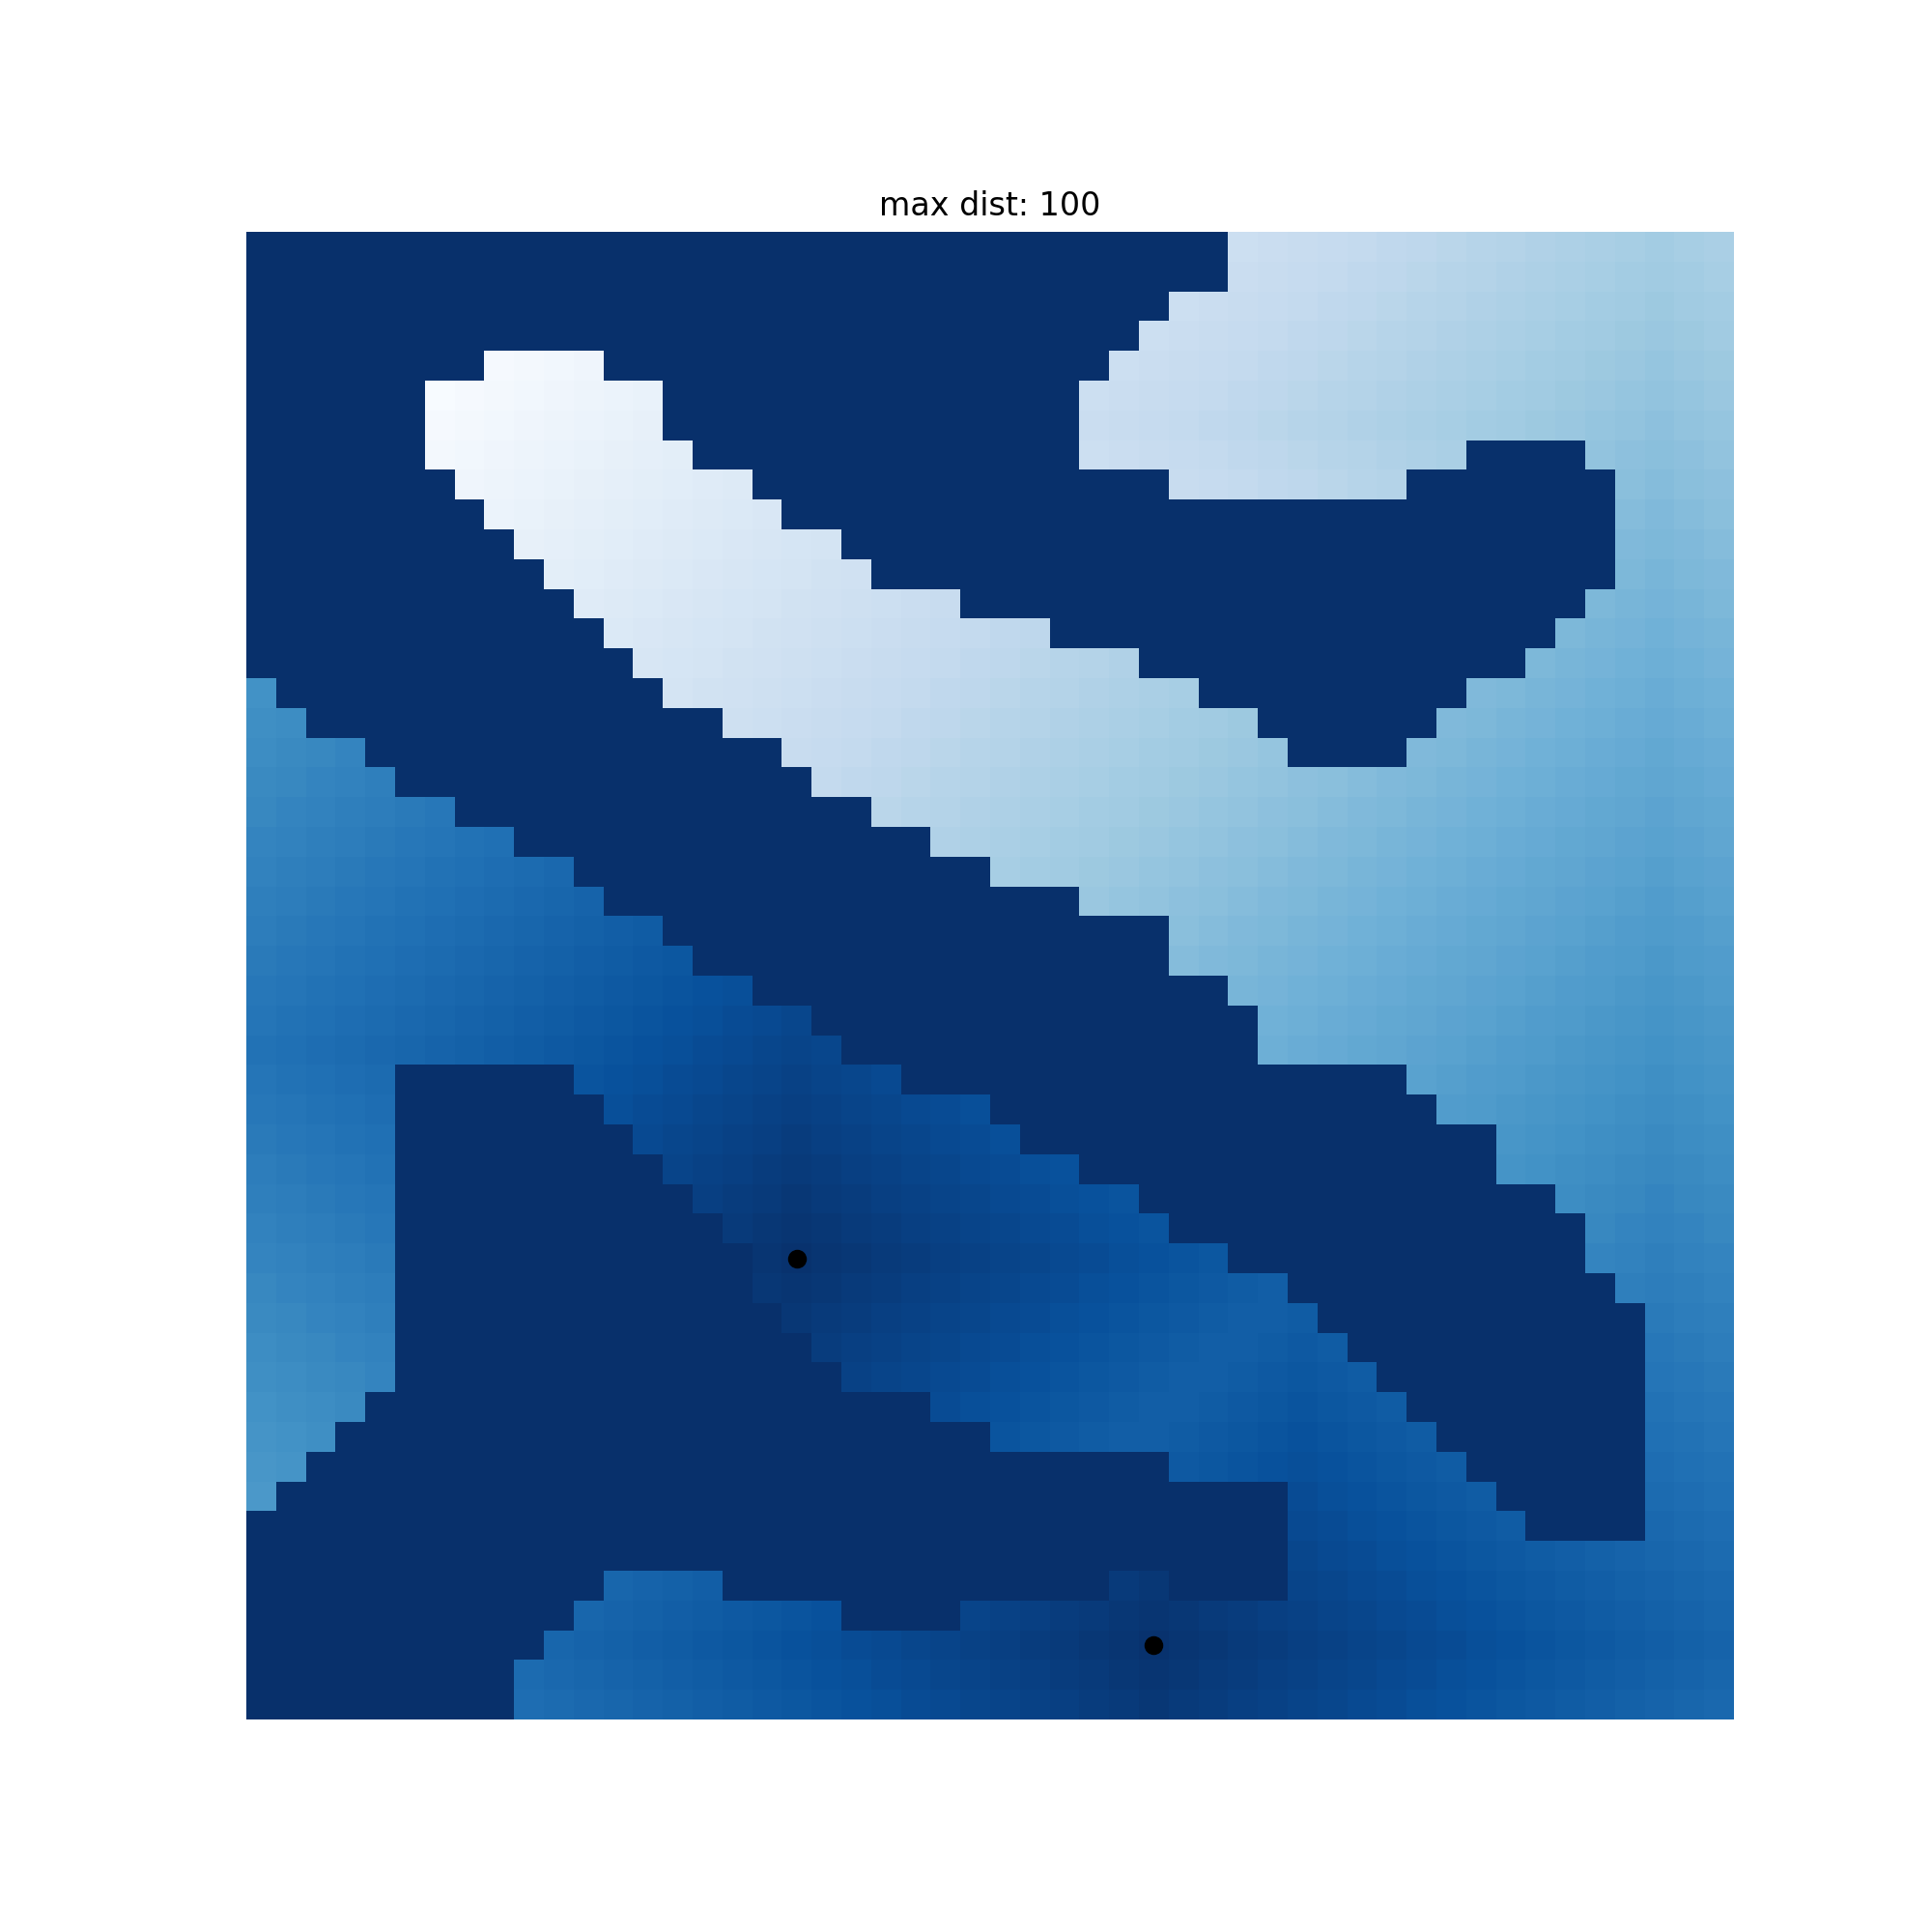

<IPython.core.display.Javascript object>


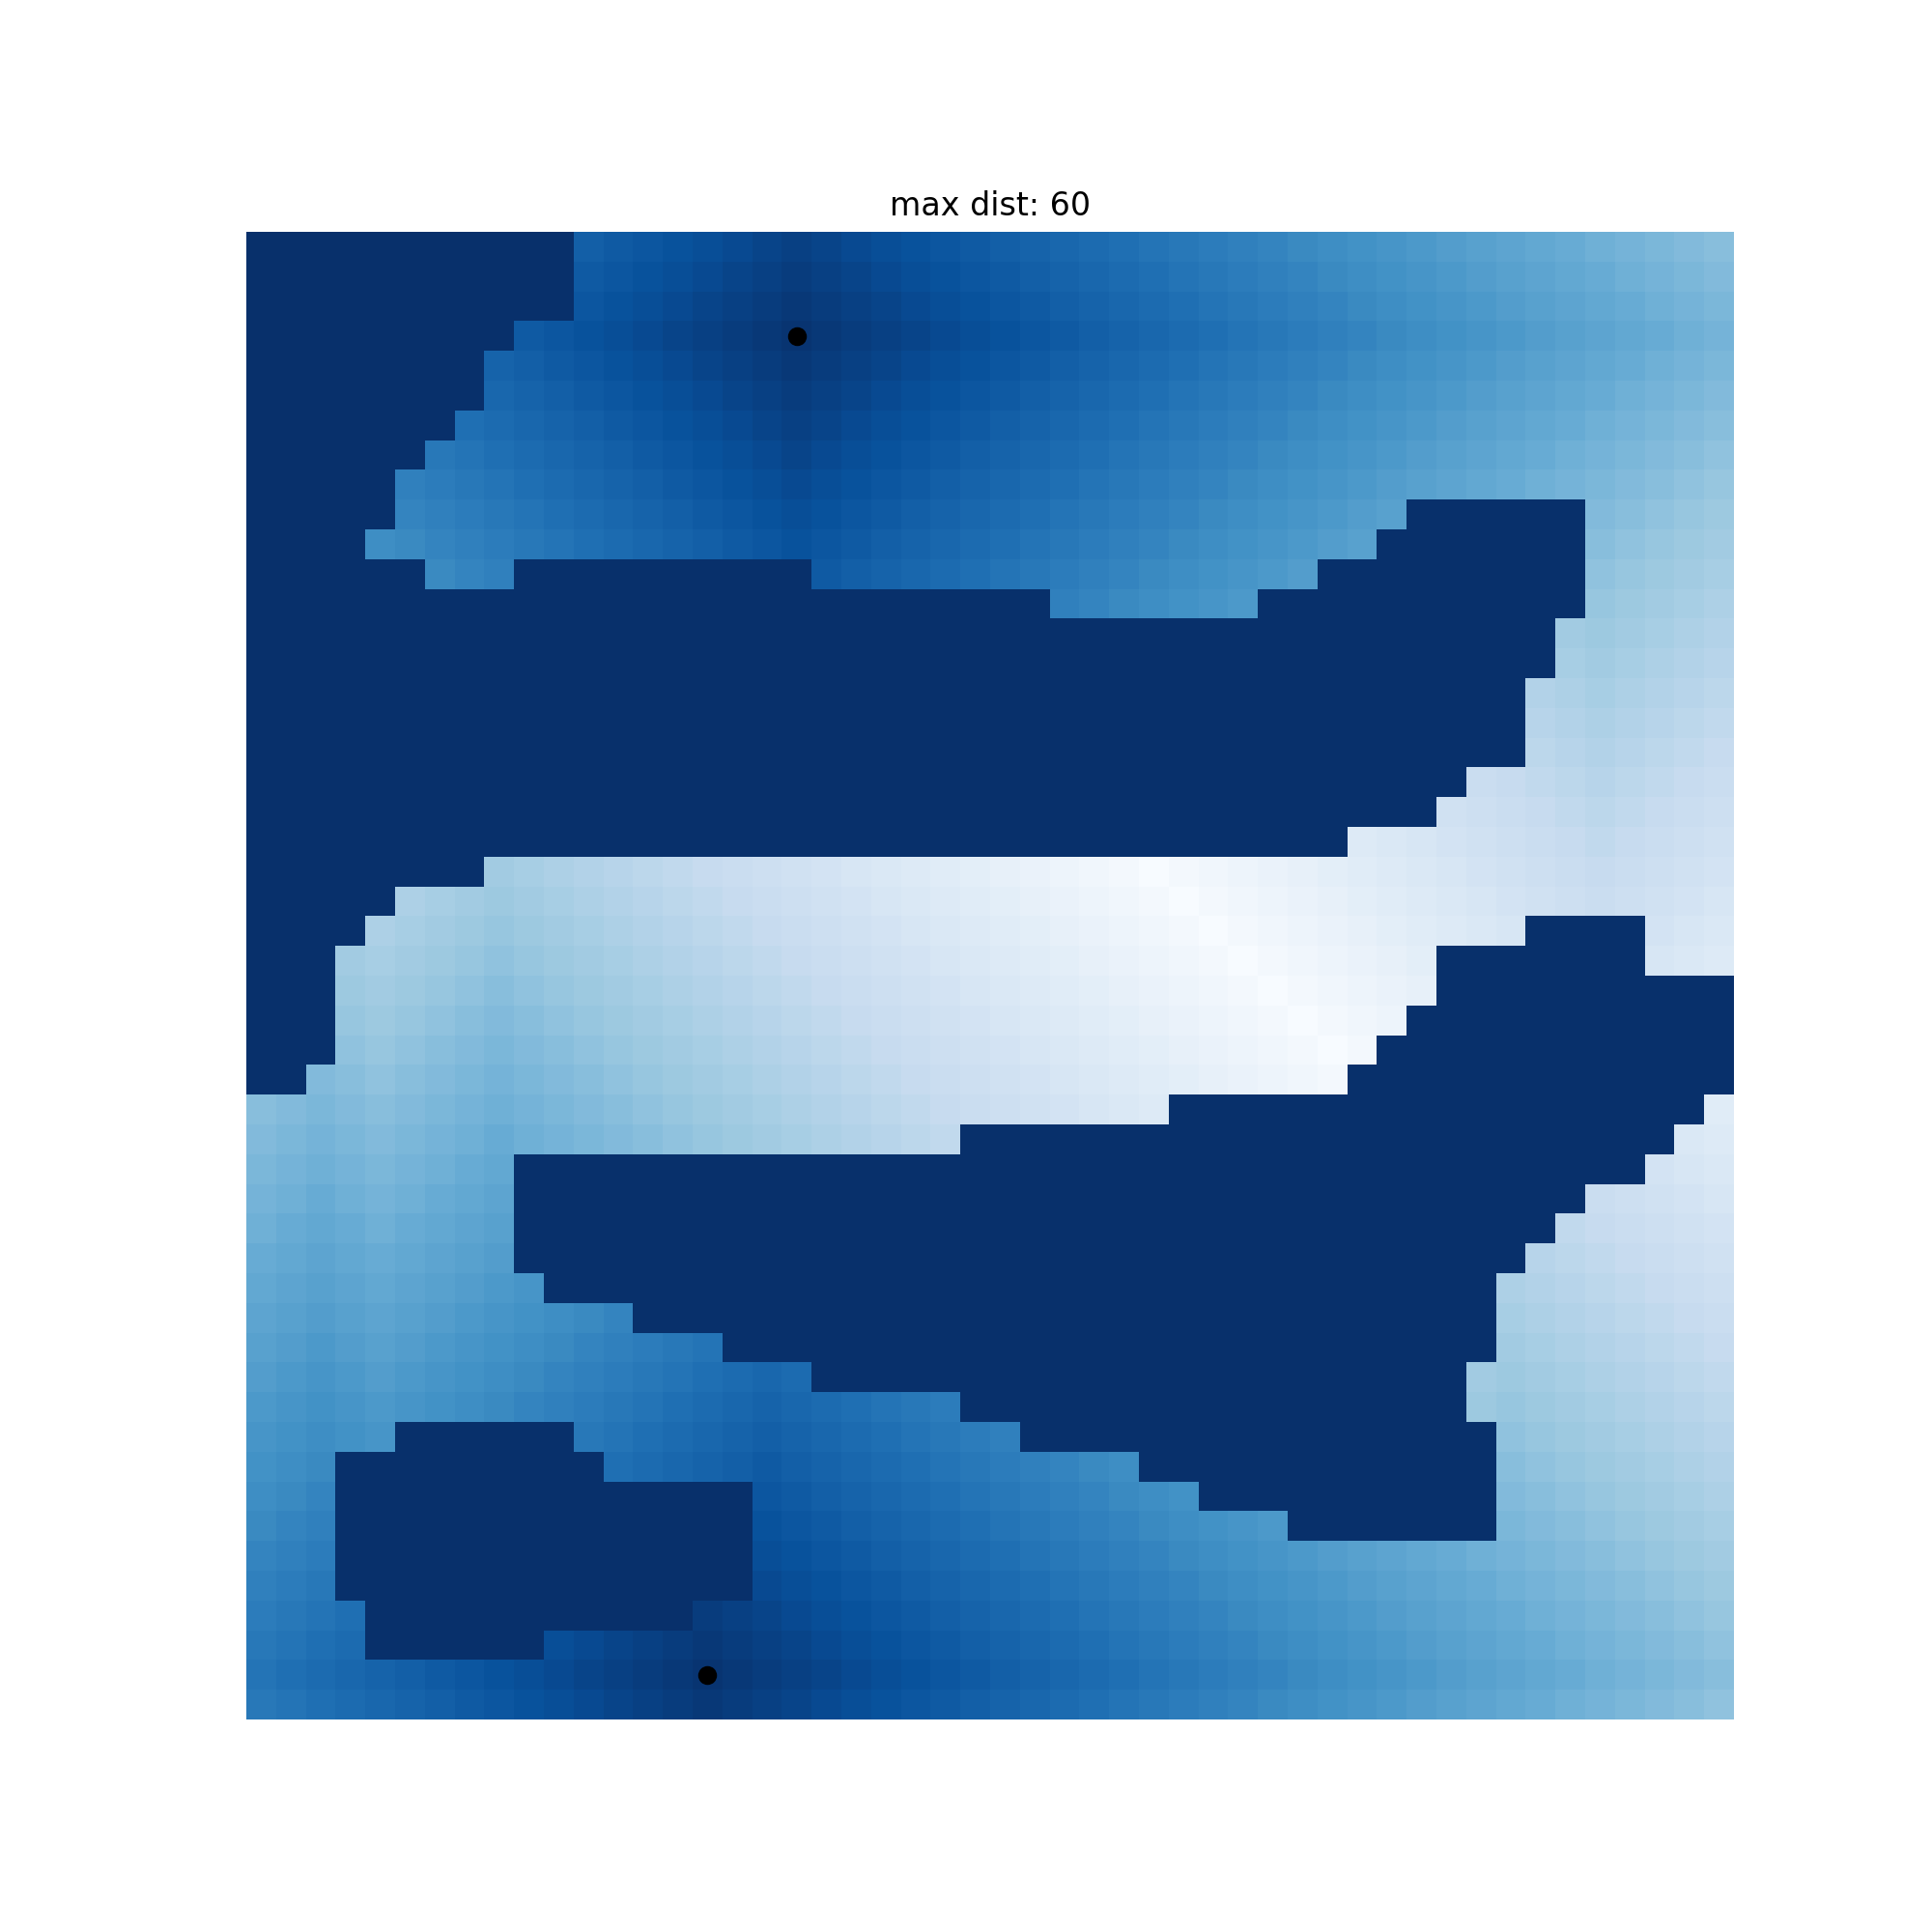

<IPython.core.display.Javascript object>


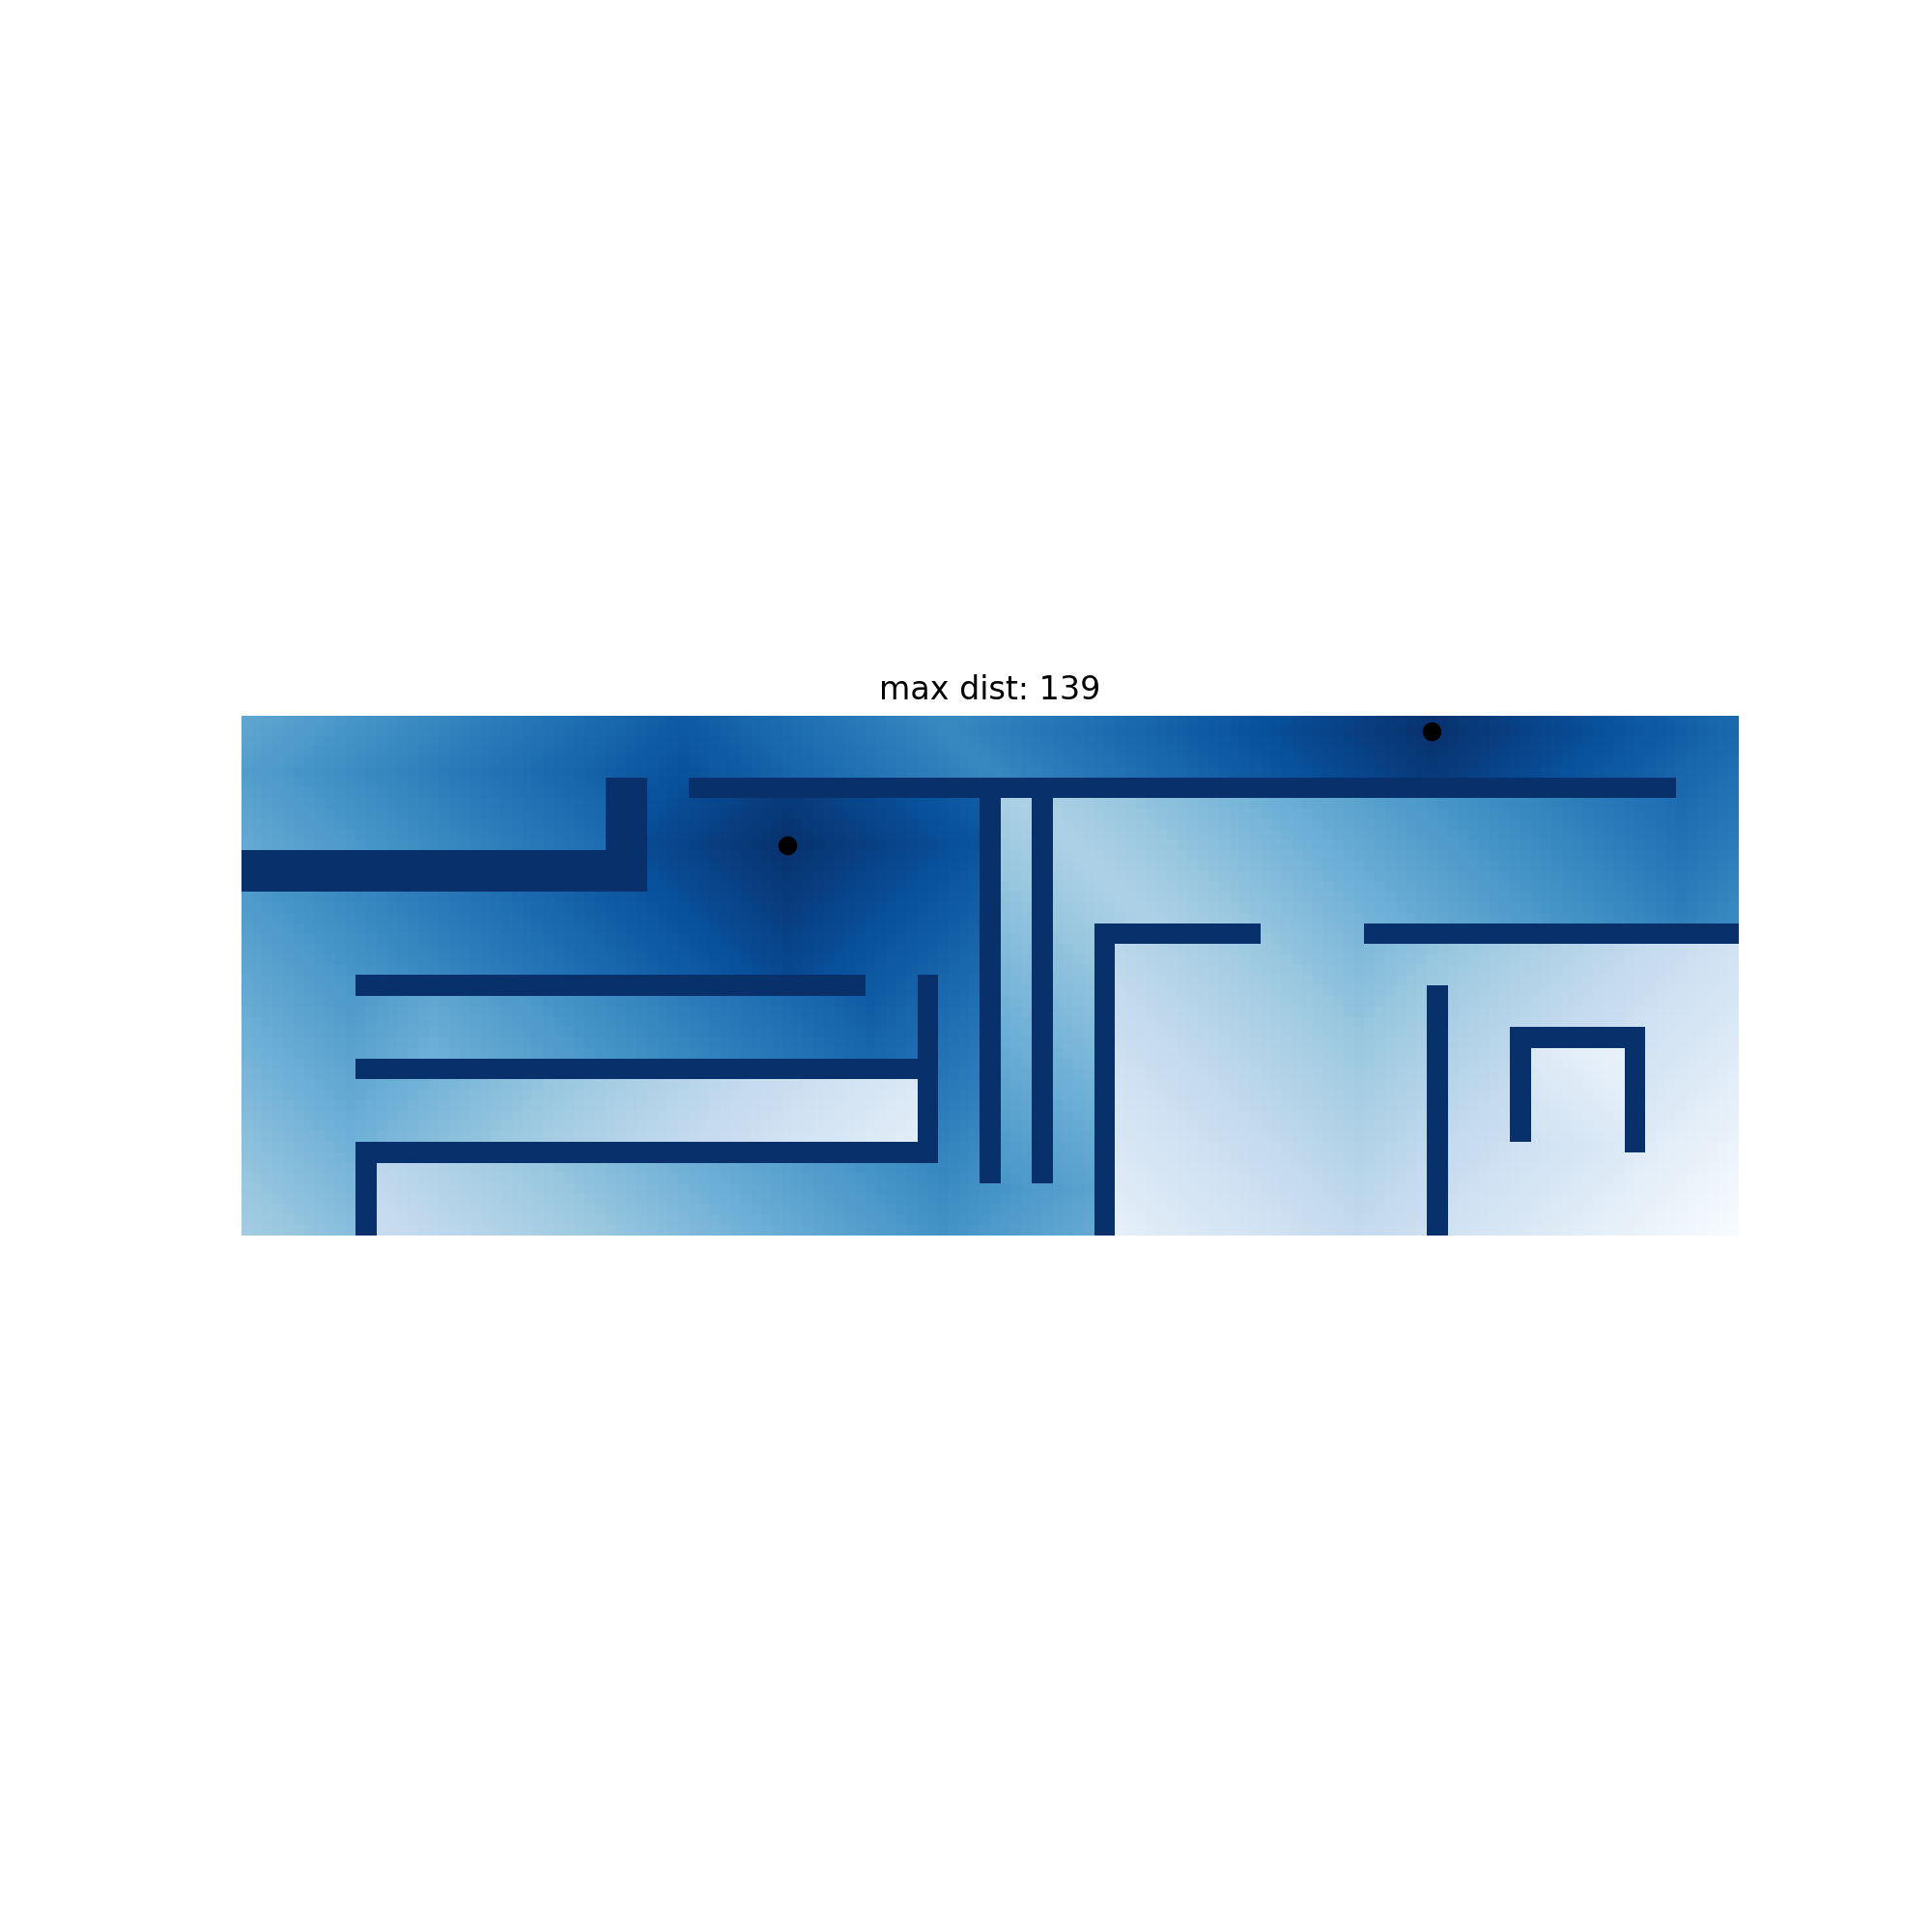

<IPython.core.display.Javascript object>


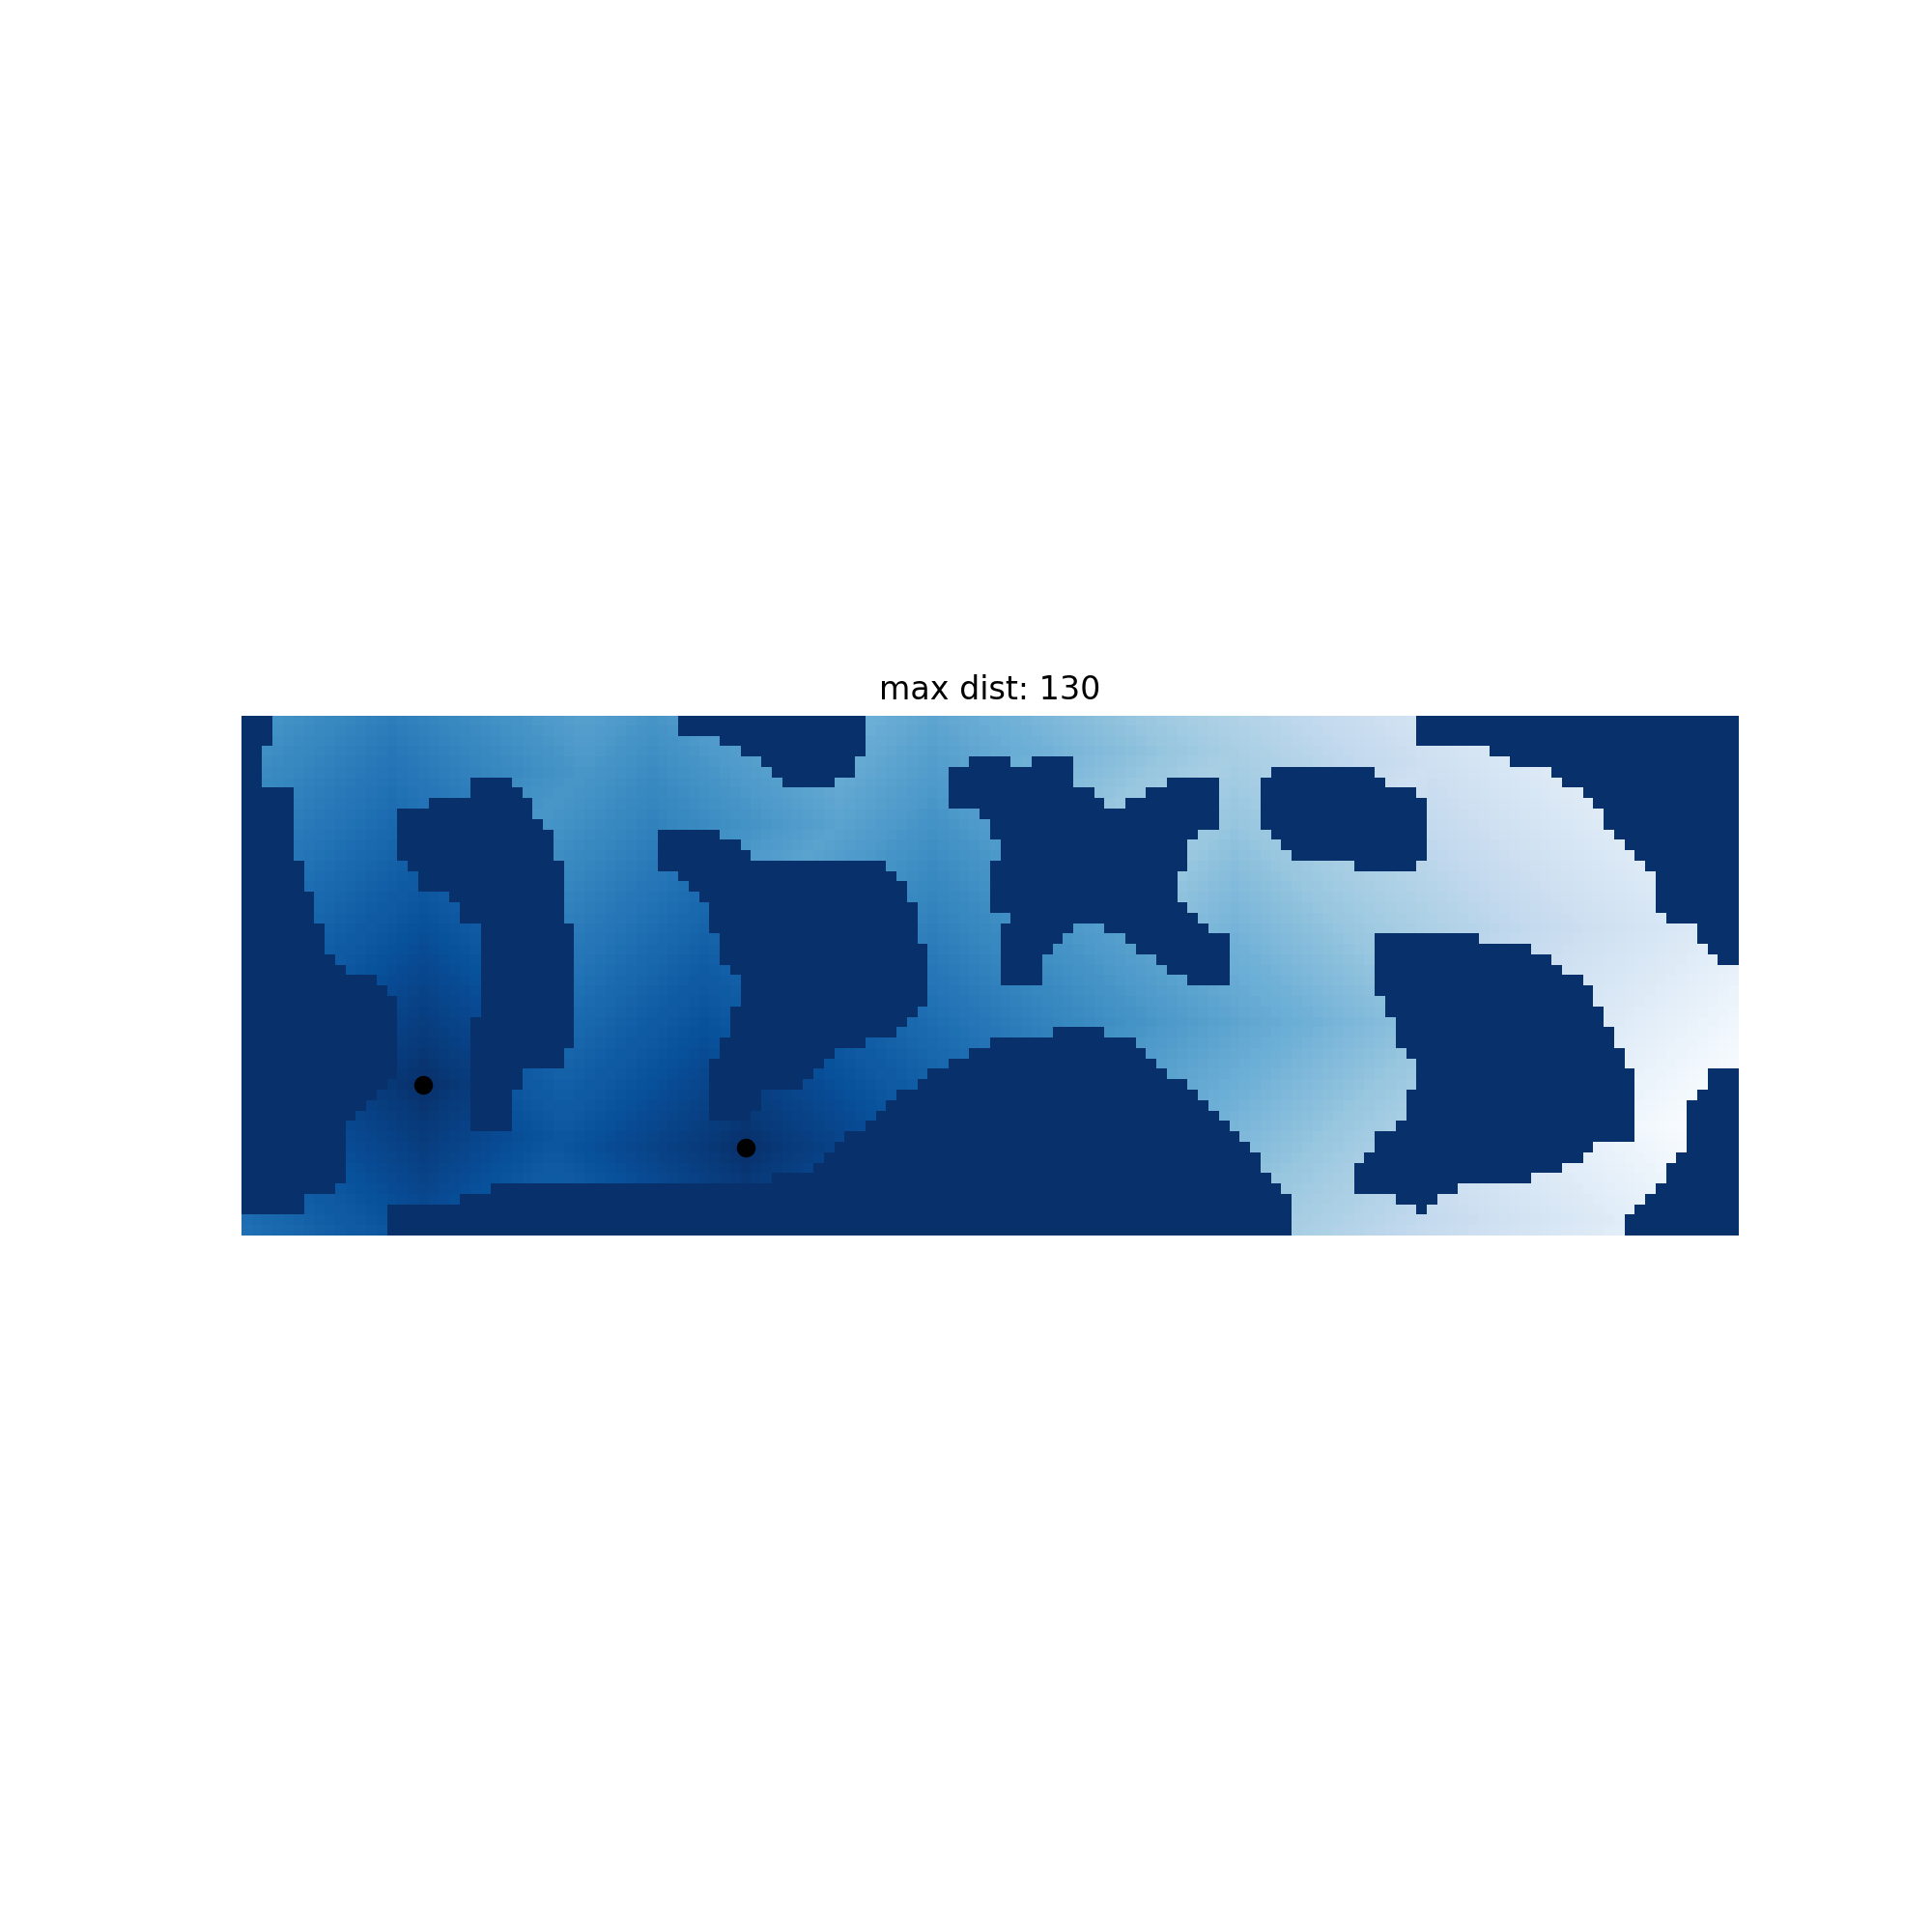

<IPython.core.display.Javascript object>


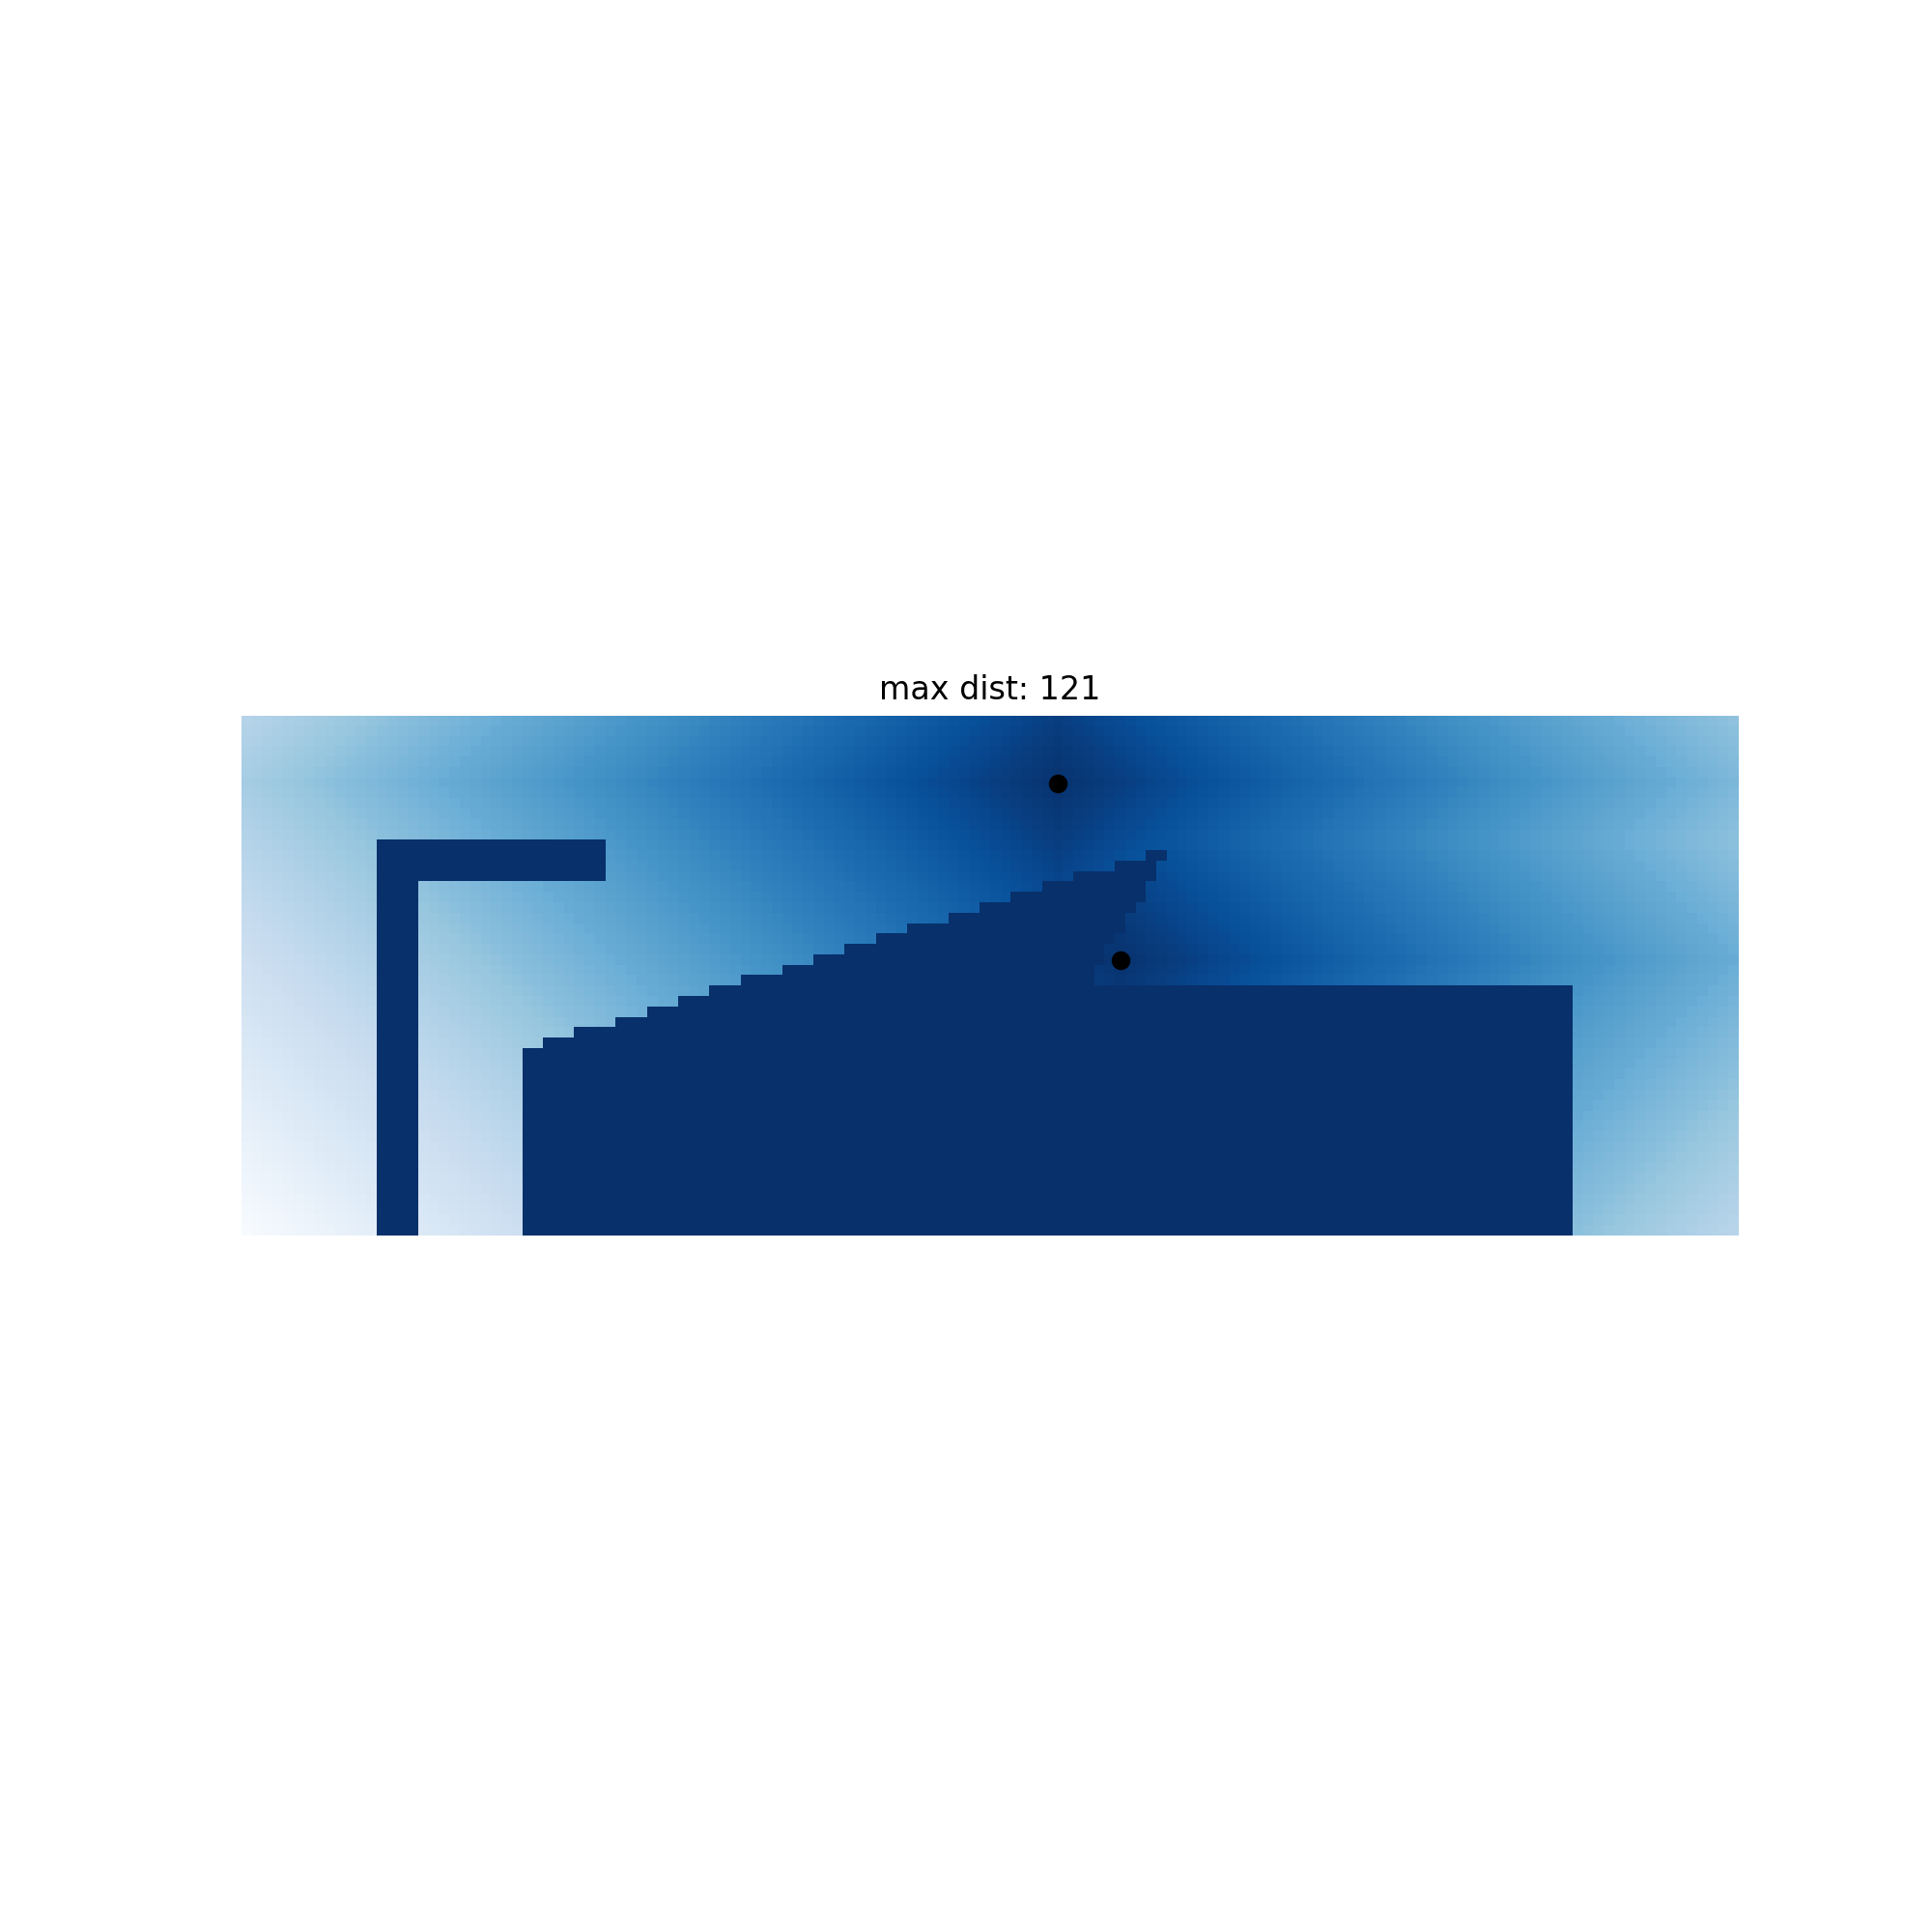

<IPython.core.display.Javascript object>


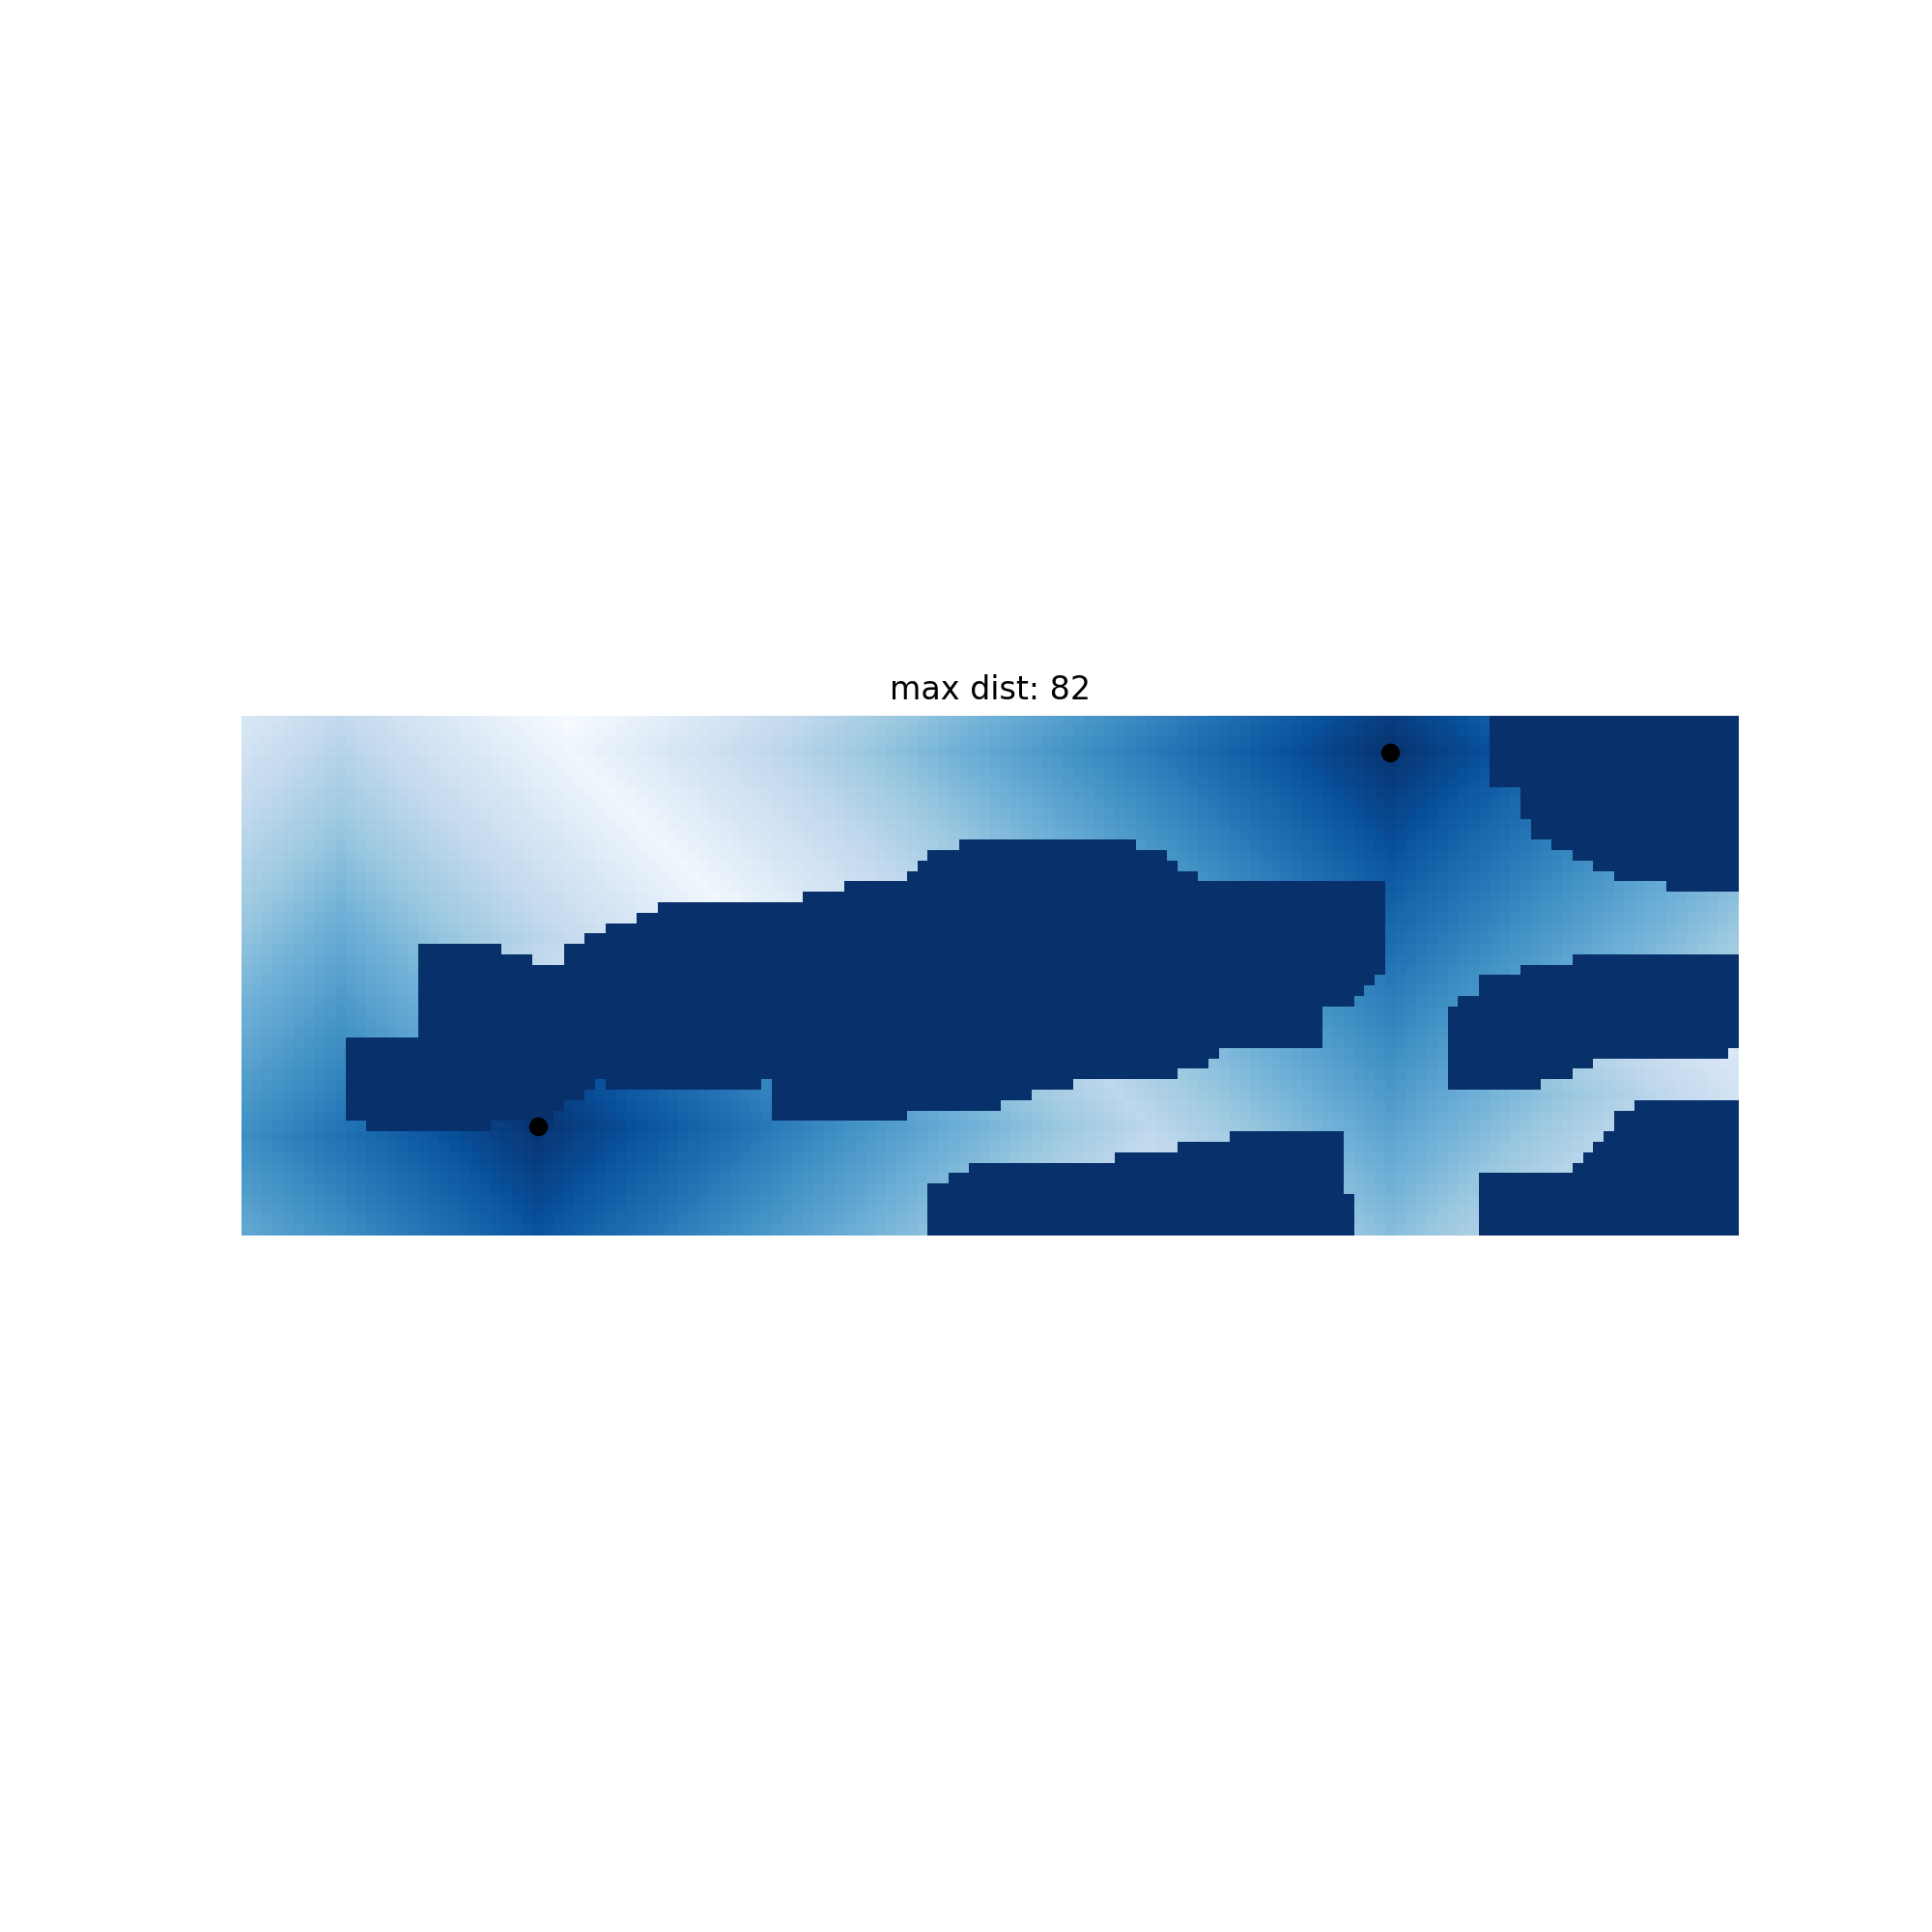

<IPython.core.display.Javascript object>


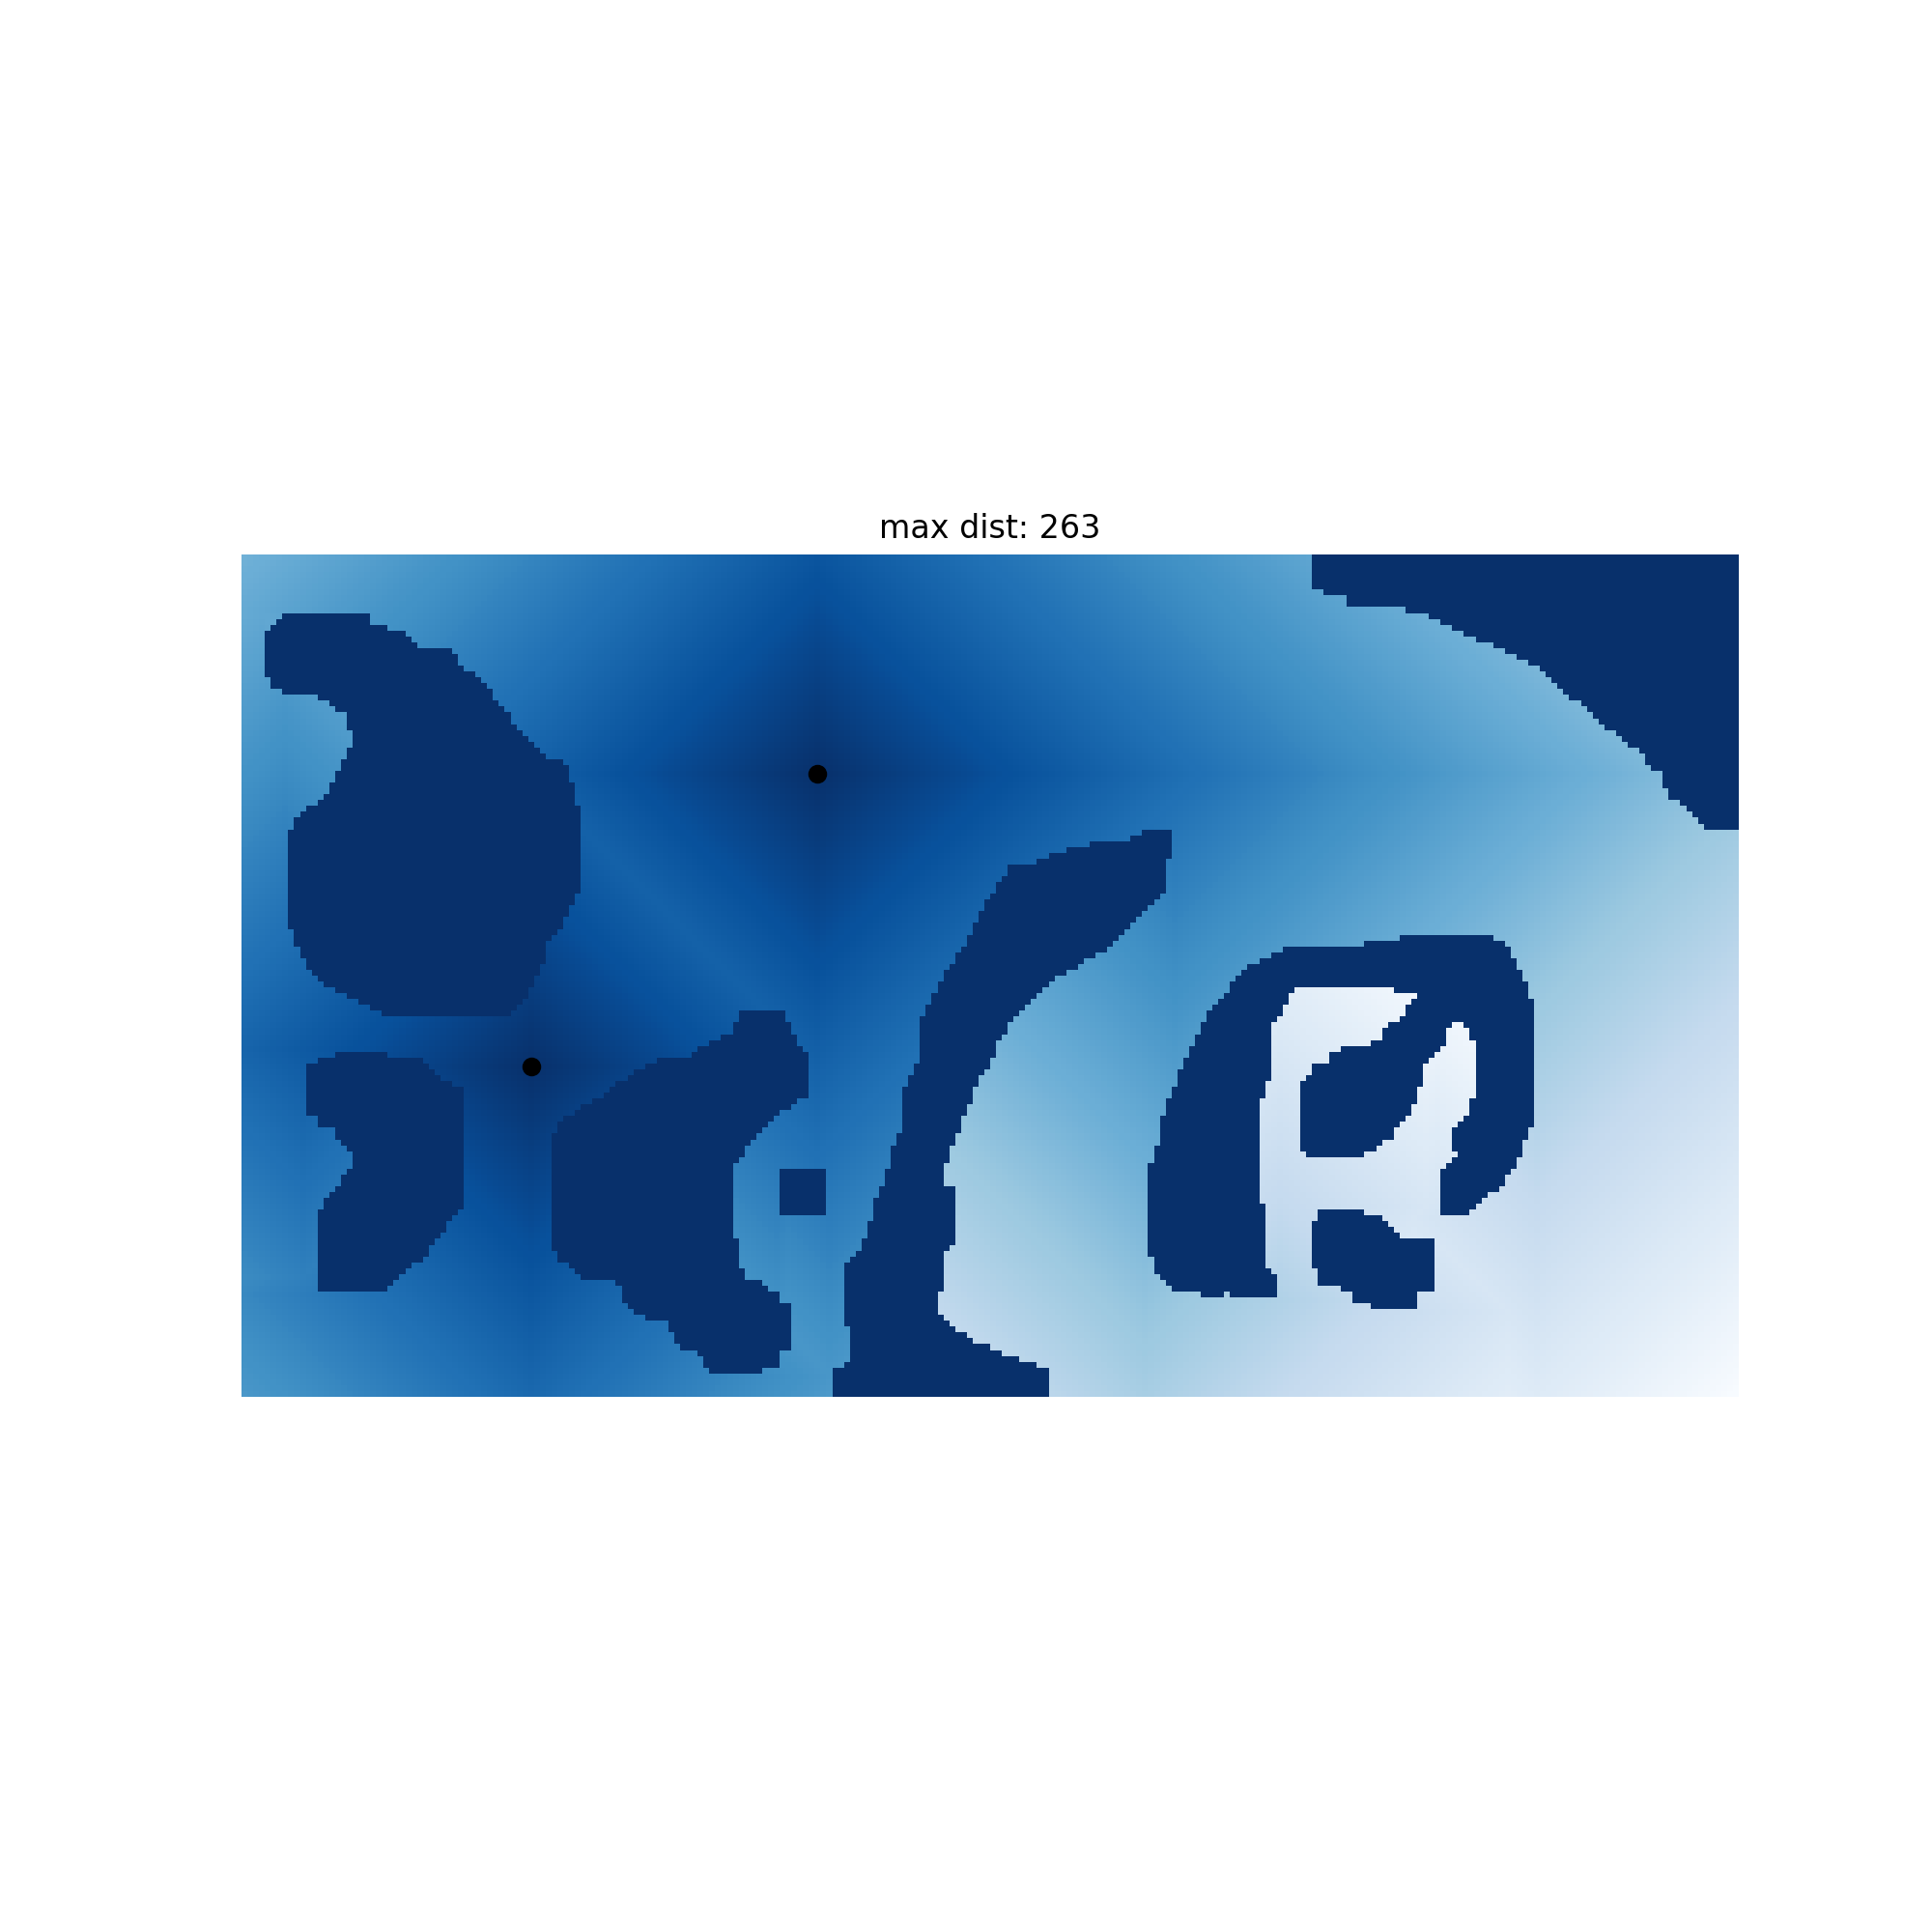

<IPython.core.display.Javascript object>


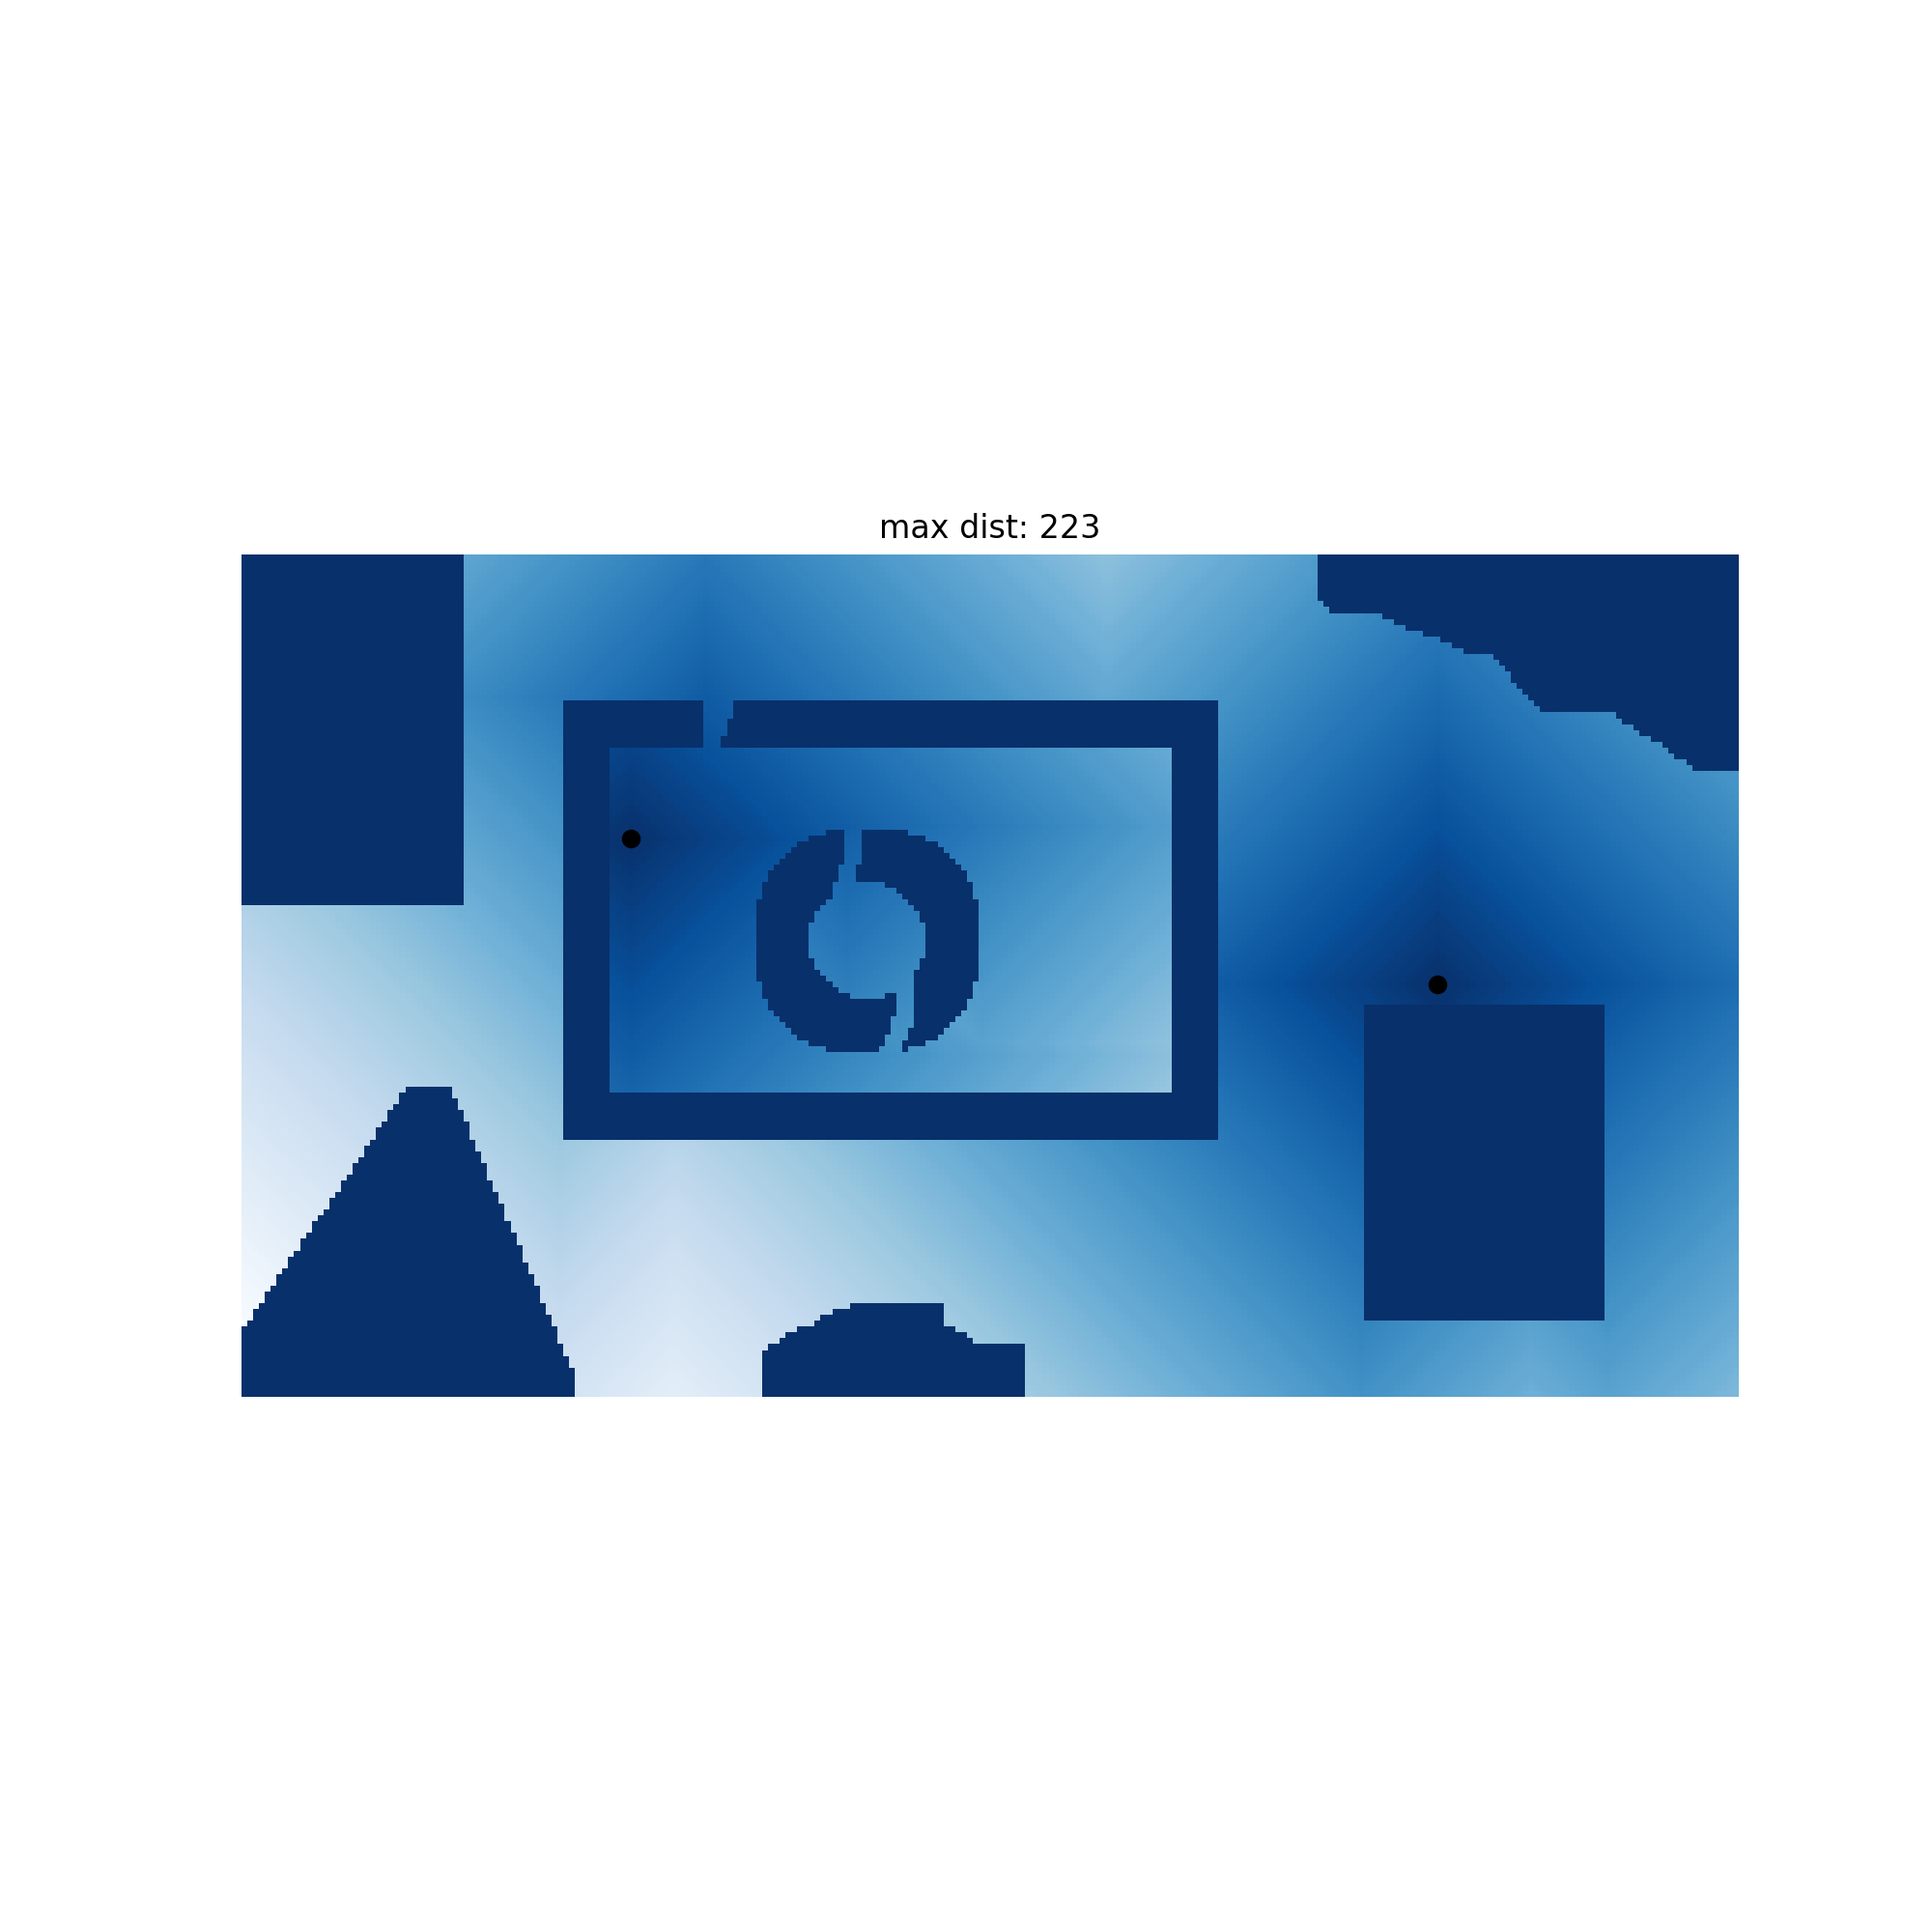

<IPython.core.display.Javascript object>


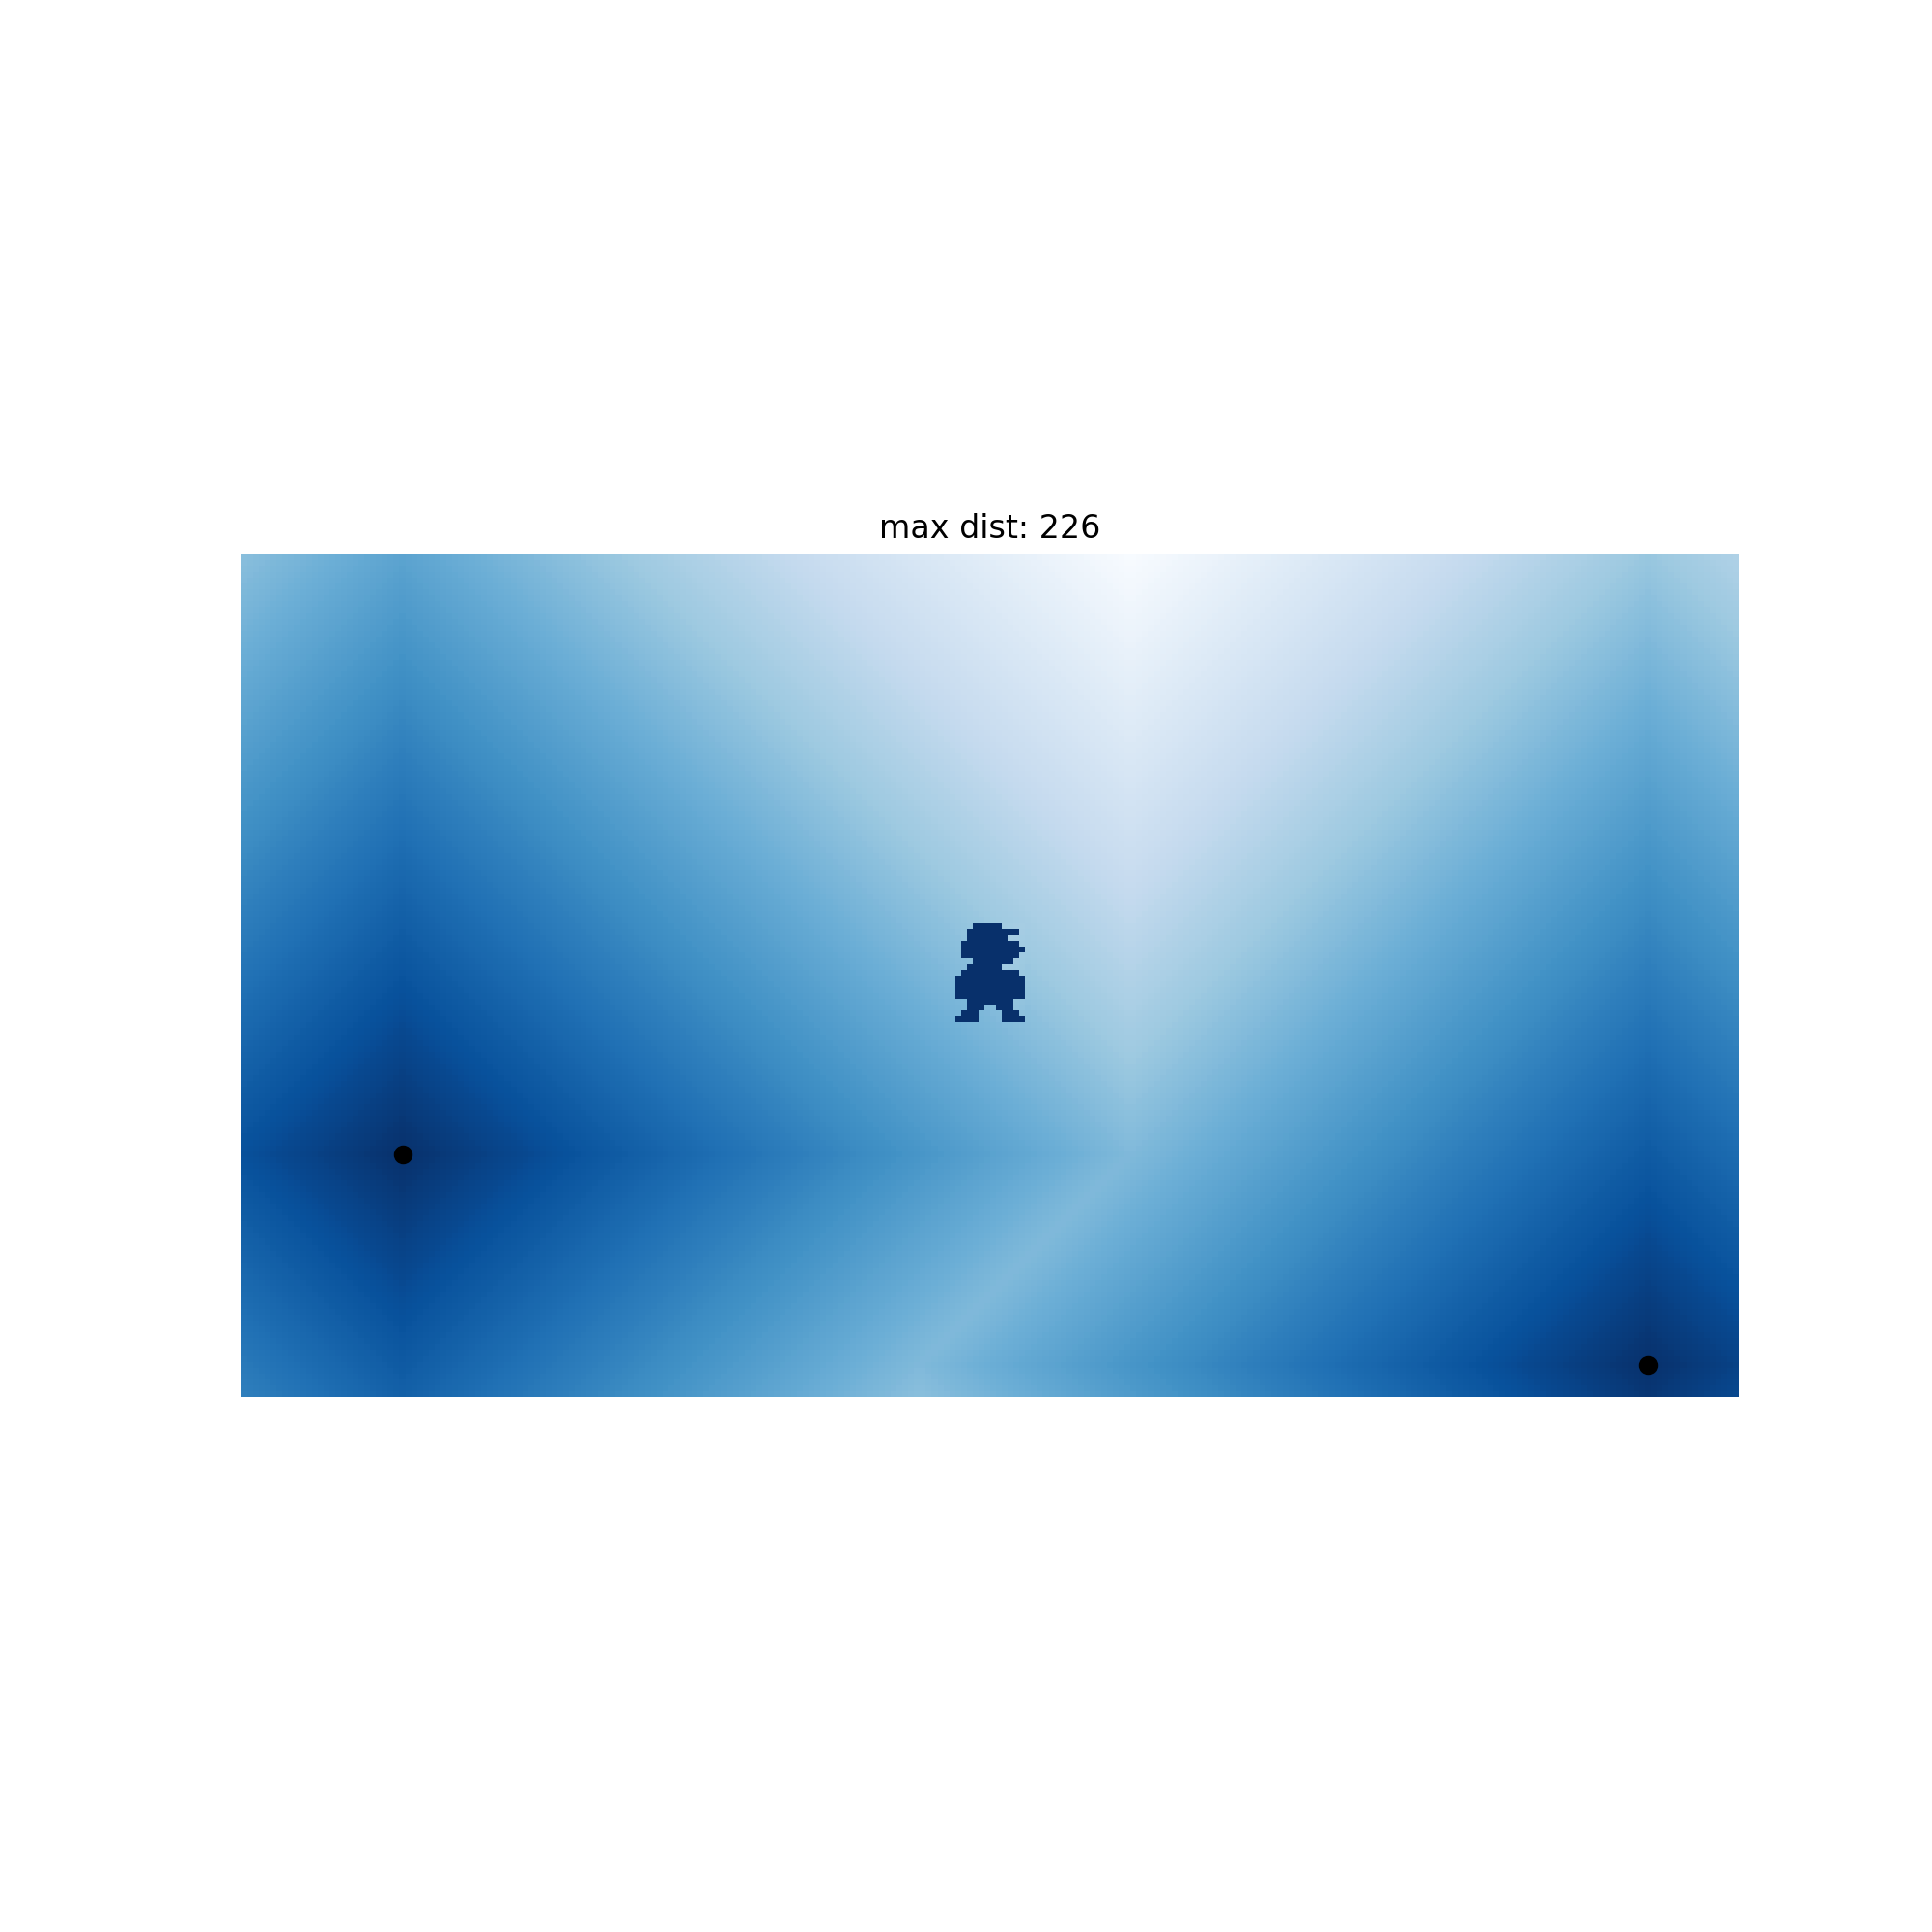

<IPython.core.display.Javascript object>


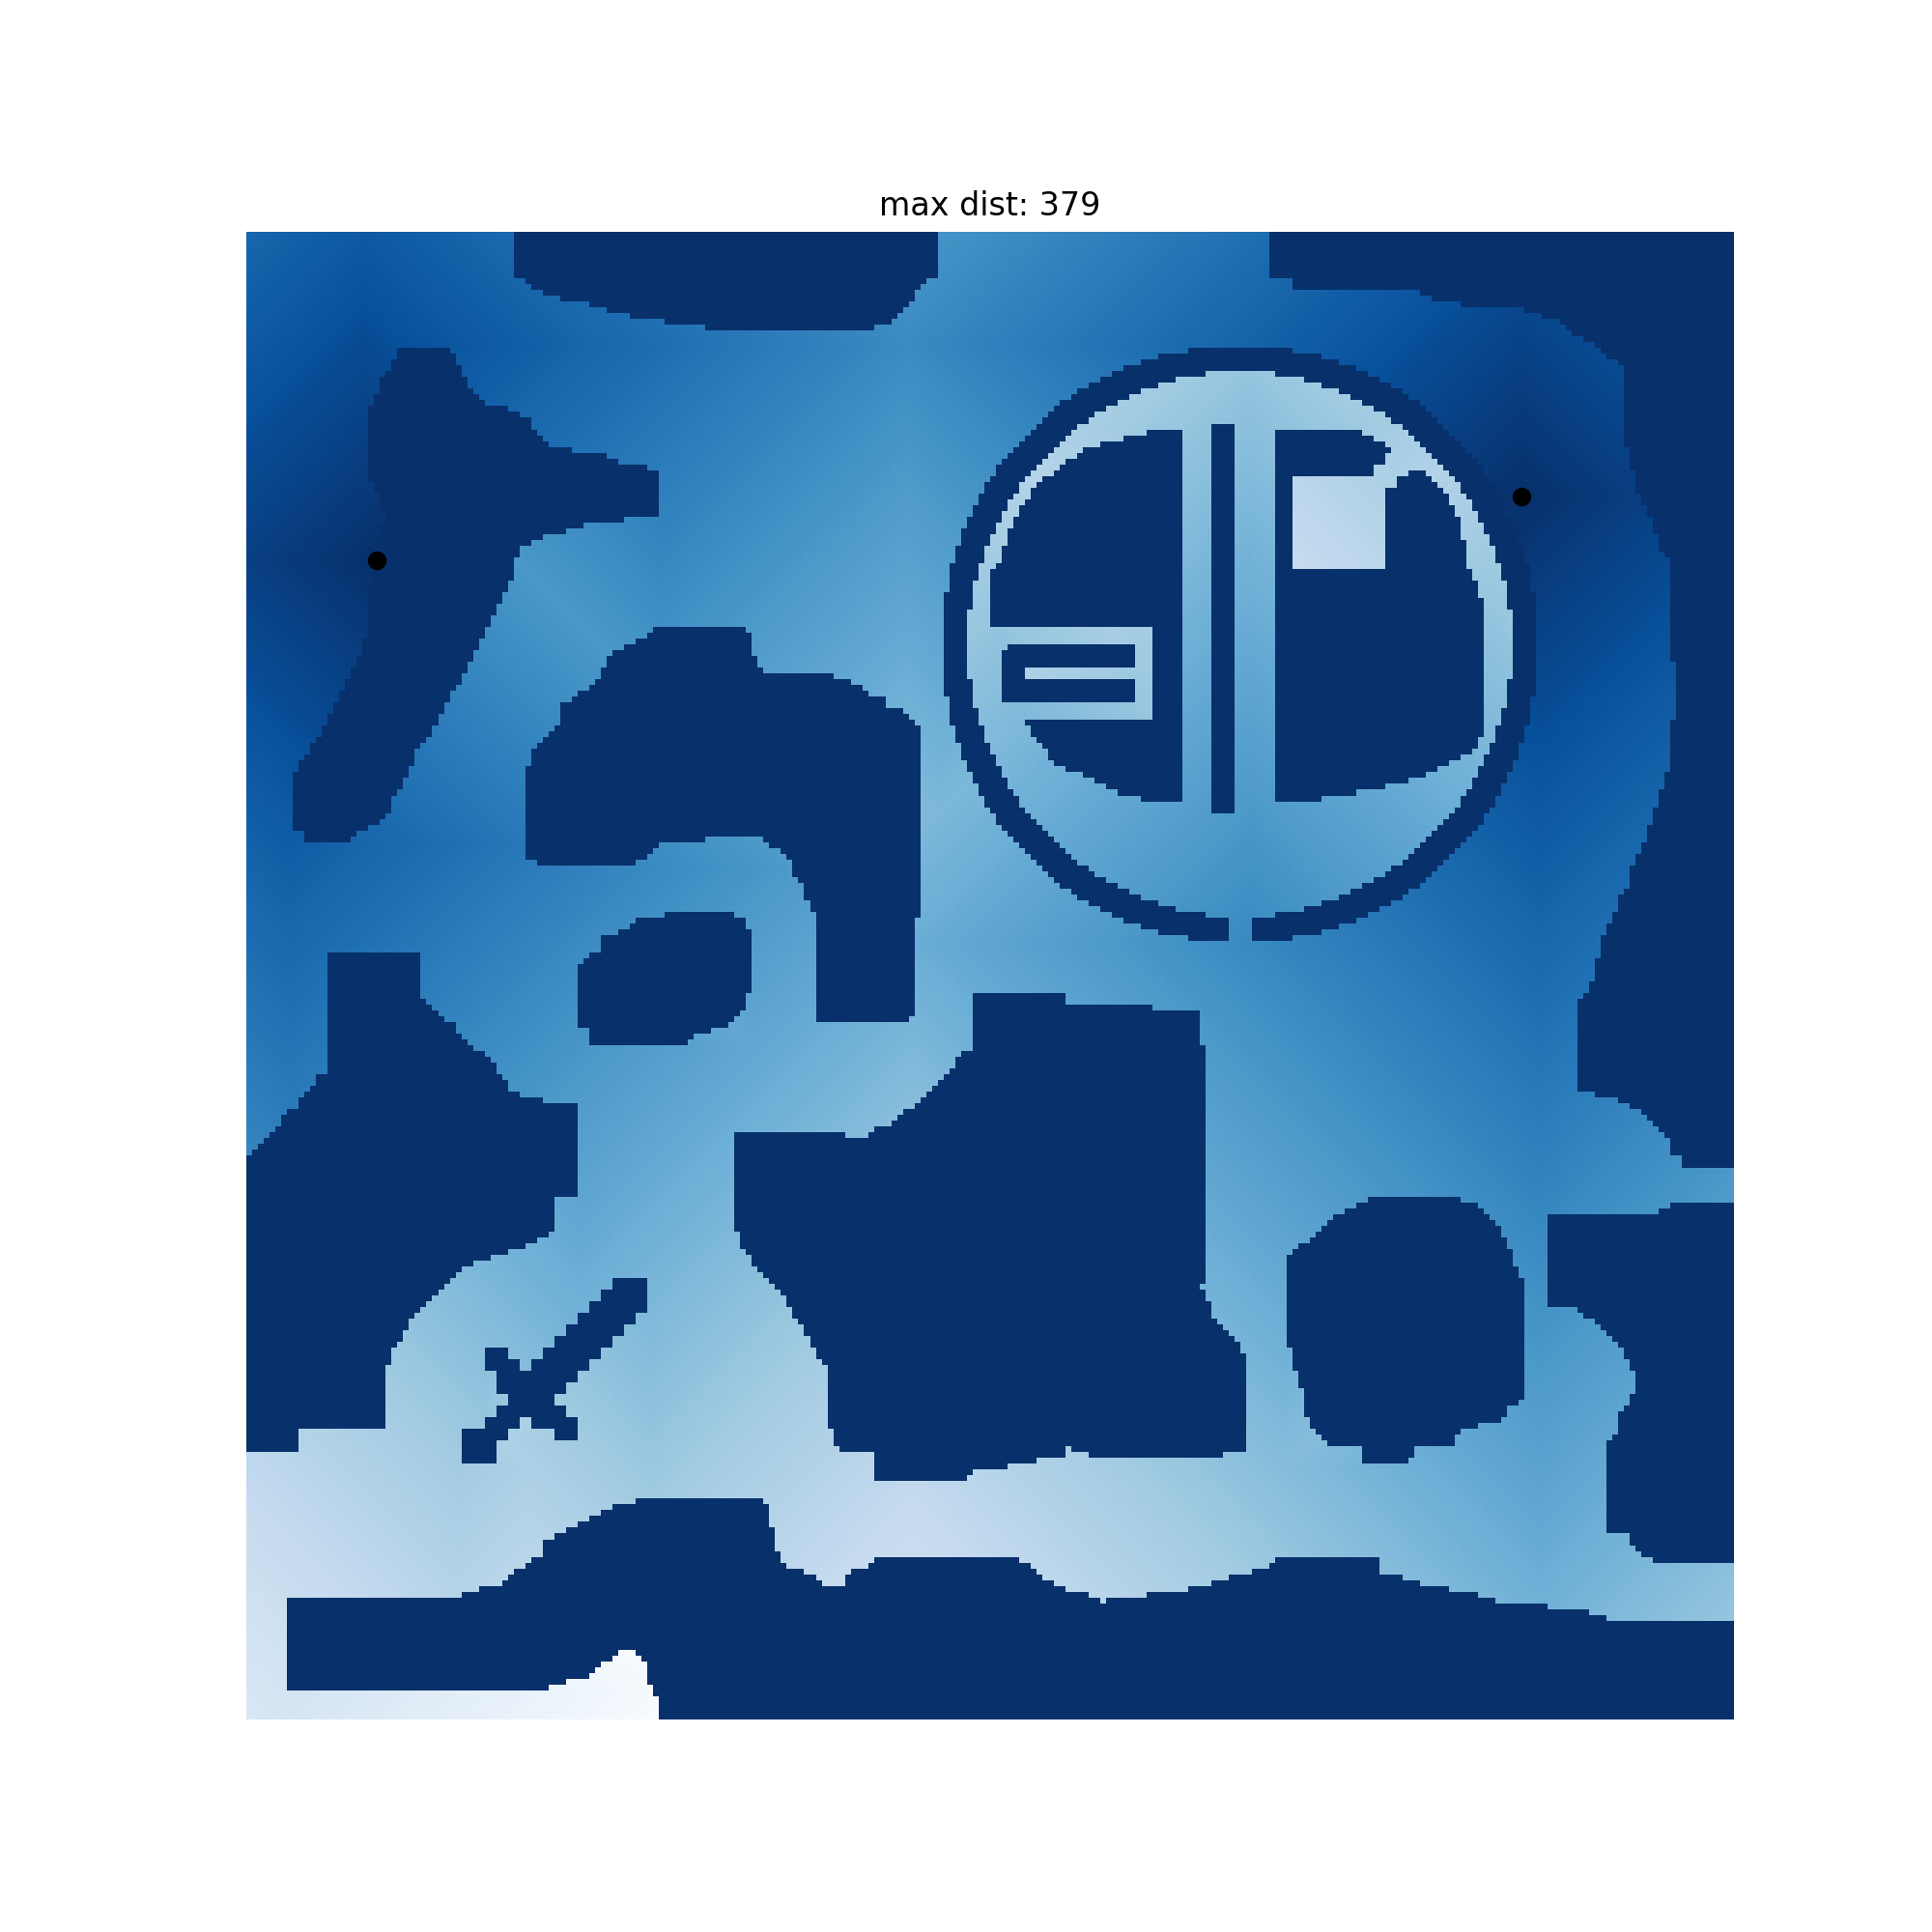

In [6]:
area_maps = get_all_area_maps("./test_maps")
for am in area_maps:
    fp = get_random_coords(am)
    dm  = dist_fill(am, fp,)
    imshow(dm,(10,10),cmap="Blues_r")
    x,y = np.array(fp).T
    plt.scatter(y,x, c="black")
    plt.title(f"max dist: {dm.max()}")

**Fuel Distance maps** generated from **point obstacles** added to no obstacle maps.  
Black points : Fuel

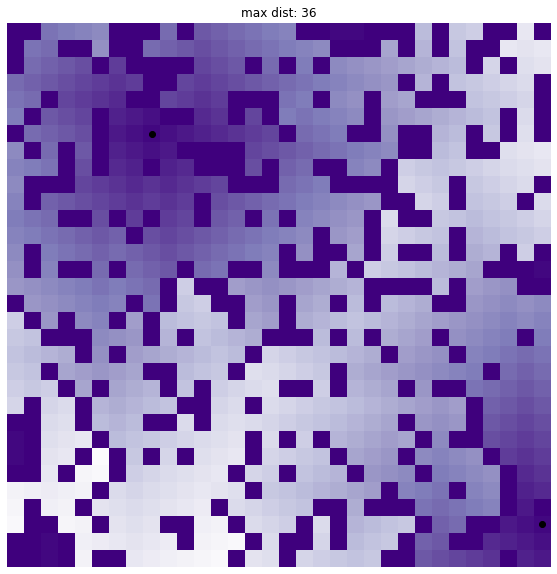

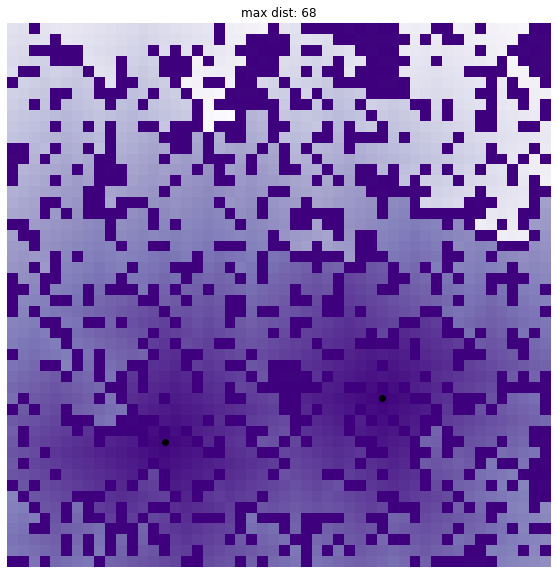

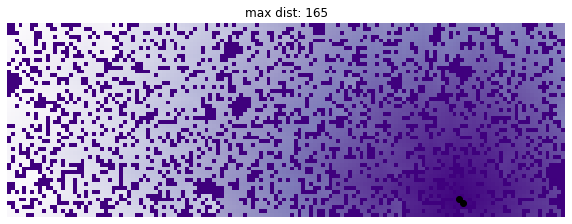

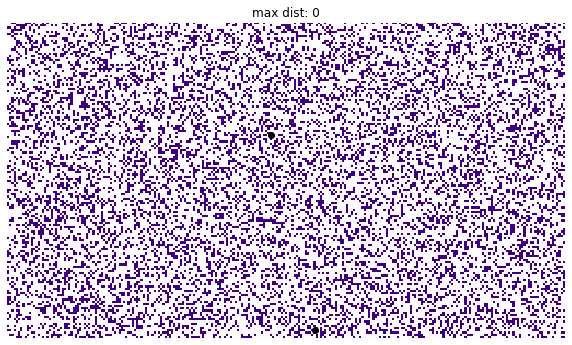

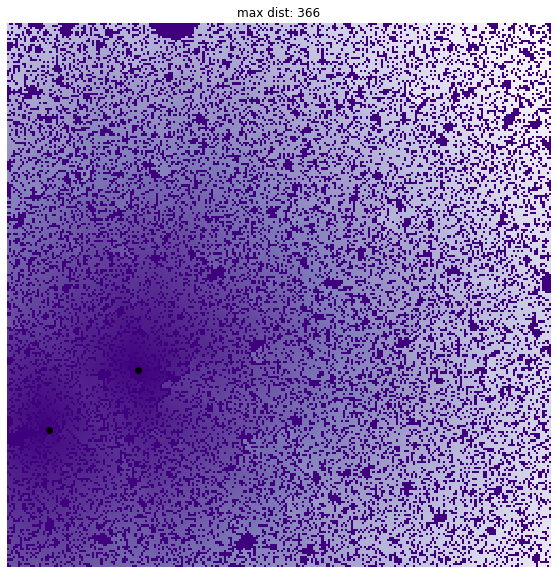

In [5]:
for am_ in generate_no_obs_area_map():
    am = generate_point_obstacles(am_, p=0.3)
    fp = get_random_coords(am)
    dm  = dist_fill(am, fp,)
    imshow(dm,(10,10),cmap="Purples_r")
    x,y = np.array(fp).T
    plt.scatter(y,x, c="black")
    plt.title(f"max dist: {dm.max()}")

# ToDo

## Path generation API
### Single Robot Path Generation
- Generate coverage path from given area map and list of relevant points (start, end, fuel).✅
- Generate fuel path from given fuel map and coverage path.✅
- Generate combined path.✅

### Multiple Robot Path Generation
- Obtain area division map from DARP.
- Pass area division map to all algos with relevant cell value to represent mapping area.
- Same interface as single robot path generation.

## Testing
### Functions to visualize
- Animation single robot✅
- Animation multiple robots
- Map Show single robot✅
- Map show multiple robots


### Metrics
- Single Robot✅
- Multiple Robots✅
#### Percents
- **Coverage** - Percentage of non obstacle cells covered by the path.✅
- **Redundancy** - Percentage of cells from the path that have been revisited (backtracked).✅

#### Timings
- **Coverage Path computation time** - Time taken by the algorithm to compute the coverage path.✅
- **Fuel Path computation time** - Time taken to compute the refuel path.✅

#### Numbers
- **Coverage cells** - Number of cells to be covered.✅
- **Non covered cells** - Cells that haven't been covered.✅
- **Backtrack** - Count of coverage path cells that have been revisited.✅
- **Coverage Path length** - Number of steps in the area coverage path.✅
- **Fuel Path length** - Number of steps in the refueling path.✅
    
### Running Tests On/Create maps for
- Resolutions, Get obstacle maps of the following resolutions.✅
    - (32, 32)✅
    - (50, 50)✅
    - (144, 50)✅
    - (256, 144)✅
    - (256, 256)✅
- Obstacle types
    - None✅
    - Point obstacles (single cell obstacles generated randomly).✅
    - Region obstacles (region obstacles that have been painted).✅
        - Corners✅
        - Central✅
        - Caves✅
        - Pipes, Bottlenecks✅
    - Combination of both.✅